In [1]:
job_name = None
n_layers = None
developing=None
paired_adata_path=None
unimodality_adata_path=None
multiome_only=None
combination=None

In [2]:
# Parameters
job_name = "aCMs_WholeSample"
n_layers = 1
developing = False
paired_adata_path = "/lustre/scratch126/cellgen/team205/heart/objects/fetal/RNA/aCMs_WholeSample_paired.h5ad"
unimodality_adata_path = "none"
combination = "multivi_aCMs_WholeSample_n_layers1"


# Set Up

In [3]:
import scvi
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import os

Global seed set to 0


/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import scanpy as sc

def all_integers_in_float_list(float_list):
    """Check if all values in a list of floats are integers."""
    return all(float_val.is_integer() for float_val in float_list)

def check_counts_layer(adata):
    """
    Check if the "counts" layer exists in the given AnnData object.
    
    Parameters:
    - adata (anndata.AnnData): The AnnData object to check.
    
    Returns:
    - bool: True if "counts" layer exists, False otherwise.
    """
    return "counts" in adata.layers.keys()

def makecountslayer(adata, apply_norm_log=True):
    """
    Ensure that the AnnData object has a "counts" layer and optionally log-normalize .X
    
    Parameters:
    - adata (anndata.AnnData): The AnnData object to be processed.
    - apply_norm_log (bool): Whether to apply normalization and log1p transformation. Default is True.
    
    Returns:
    - None: Modifies the AnnData object in place.
    """
    # Check if 'counts' layer exists
    if check_counts_layer(adata):
        print("Counts layer found, copying counts to .X...")
        # Copy data from 'counts' layer to .X
        adata.X = adata.layers["counts"].copy()
    else:
        print("No counts layer found, checking whether .X contains count data (integers)...")
        # Sample first 1000 elements from .X for integer check
        adata_X = adata.X.data[:1000].tolist()

        # Check if sampled data are all integers
        if all_integers_in_float_list(adata_X):
            print("Counts found in adata.X, saving them to a counts layer...")
            # Copy data from .X to 'counts' layer
            adata.layers["counts"] = adata.X.copy()
        else:
            raise ValueError("No count data found, cannot proceed")
    
    if apply_norm_log:
        print("Norm-logging .X...")
        # Normalize and log-transform data
        sc.pp.normalize_total(adata, target_sum=1e4)
        sc.pp.log1p(adata)
    else:
        print("NOT norm-logging")

In [5]:
from collections import Counter

def ensure_unique_var_names(adata):
    """
    Ensure that the variable names in an AnnData object are unique.
    
    Parameters:
    -----------
    adata : AnnData
        The AnnData object to be checked and processed.

    Returns:
    --------
    None
        Modifies the AnnData object in place if non-unique variable names are found.
    """
    
    # Find non-unique variable names
    var_names = list(adata.var_names)
    counter = Counter(var_names)
    non_unique_var_names = [name for name, count in counter.items() if count > 1]

    # If non-unique variable names are found, make them unique
    if non_unique_var_names:
        print("The following variable names are NOT unique:", non_unique_var_names)
        print("Running adata.var_names_make_unique()...")
        adata.var_names_make_unique()
    else:
        print("All variable names are unique.")

In [6]:
if unimodality_adata_path=="none":
    multiome_only=True
else:
    multiome_only=False

In [7]:
continuous_covariate_keys=['total_counts','pct_counts_mt','pct_counts_ribo','S_score','G2M_score']

In [8]:
model_dir=os.path.join("/lustre/scratch126/cellgen/team205/heart/objects/fetal/RNA","models") # for model
latent_variables_dir=os.path.join("/lustre/scratch126/cellgen/team205/heart/objects/fetal/RNA","latent_variables") # for latent variables

In [9]:
if job_name=="global":
    max_epochs=200
else:
    max_epochs=500
if developing:
    max_epochs=2

In [10]:
import session_info
session_info.show()

In [11]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=50, facecolor='white', color_map = 'RdPu',figsize=(4, 4))
sc.set_figure_params(dpi=80, dpi_save=150, figsize=(6,6))

In [12]:
!nvidia-smi

Thu Oct 19 16:46:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.108.03   Driver Version: 510.108.03   CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|


|   0  NVIDIA A100-SXM...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   44C    P0   104W / 400W |  21381MiB / 81920MiB |     75%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|


|    0   N/A  N/A    247245      C   python                          21379MiB |
+-----------------------------------------------------------------------------+


# Read in

In [13]:
adata_paired = sc.read_h5ad(paired_adata_path)
print(adata_paired.shape)

if developing:
    adata_paired=adata_paired[::10, :] # slices to keep every Xth cell
    
print(adata_paired.shape)
adata_paired

(5664, 544641)
(5664, 544641)


AnnData object with n_obs × n_vars = 5664 × 544641
    obs: 'sangerID', 'combinedID', 'donor', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'multiplexed', 'batch_key', 'region', 'FACSgate', 'sex', 'week', 'trimester', 'fine_grain', 'mid_grain', 'coarse_grain', 'heart_or_greatvessels', 'cycling', 'S_score', 'G2M_score', 'phase', 'stress_score', 'hb1_score'
    var: 'modality', 'gene_name_scRNA-0', 'gene_id'

In [14]:
adata_paired.obs

sangerID  \
barcode                                                                 
BHF_F_Hea11933667_BHF_F_Hea11596620_CTTCTCAAGCG...  BHF_F_Hea11933667   
BHF_F_Hea11933674_BHF_F_Hea11596627_GATTAGCTCAG...  BHF_F_Hea11933674   
BHF_F_Hea11933674_BHF_F_Hea11596627_CATGCAAGTTA...  BHF_F_Hea11933674   
BHF_F_Hea11933668_BHF_F_Hea11596621_CCTTACTCAAC...  BHF_F_Hea11933668   
BHF_F_Hea11933666_BHF_F_Hea11596619_AGCTTCCTCGT...  BHF_F_Hea11933666   
...                                                               ...   
BHF_F_Hea11064672_BHF_F_Hea11031825_GCACTTACAGC...  BHF_F_Hea11064672   
BHF_F_Hea11933669_BHF_F_Hea11596622_GCTAACAGTTA...  BHF_F_Hea11933669   
BHF_F_Hea11933673_BHF_F_Hea11596626_GCCTATTGTGT...  BHF_F_Hea11933673   
BHF_F_Hea11064671_BHF_F_Hea11031824_CGTCAATAGCT...  BHF_F_Hea11064671   
BHF_F_Hea11064671_BHF_F_Hea11031824_CTTACTAGTTG...  BHF_F_Hea11064671   

                                                                             combinedID  \
barcode                                                                                   
BHF_F_Hea11933667_BHF_F_Hea11596620_CTTCTCAAGCG...  BHF_F_Hea11933667_BHF_F_Hea11596620   
BHF_F_Hea11933674_BHF_F_Hea11596627_GATTAGCTCAG...  BHF_F_Hea11933674_BHF_F_Hea11596627   
BHF_F_Hea11933674_BHF_F_Hea11596627_CATGCAAGTTA...  BHF_F_Hea11933674_BHF_F_Hea11596627   
BHF_F_Hea11933668_BHF_F_Hea11596621_CCTTACTCAAC...  BHF_F_Hea11933668_BHF_F_Hea11596621   
BHF_F_Hea11933666_BHF_F_Hea11596619_AGCTTCCTCGT...  BHF_F_Hea11933666_BHF_F_Hea11596619   
...                                                                                 ...   
BHF_F_Hea11064672_BHF_F_Hea11031825_GCACTTACAGC...  BHF_F_Hea11064672_BHF_F_Hea11031825   
BHF_F_Hea11933669_BHF_F_Hea11596622_GCTAACAGTTA...  BHF_F_Hea11933669_BHF_F_Hea11596622   
BHF_F_Hea11933673_BHF_F_Hea11596626_GCCTATTGTGT...  BHF_F_Hea11933673_BHF_F_Hea11596626   
BHF_F_Hea11064671_BHF_F_Hea11031824_CGTCAATAGCT...  BHF_F_Hea11064671_BHF_F_Hea11031824   
BHF_F_Hea11064671_BHF_F_Hea11031824_CTTACTAGTTG...  BHF_F_Hea11064671_BHF_F_Hea11031824   

                                                    donor facility  \
barcode                                                              
BHF_F_Hea11933667_BHF_F_Hea11596620_CTTCTCAAGCG...  Hst33   Sanger   
BHF_F_Hea11933674_BHF_F_Hea11596627_GATTAGCTCAG...    C98   Sanger   
BHF_F_Hea11933674_BHF_F_Hea11596627_CATGCAAGTTA...    C98   Sanger   
BHF_F_Hea11933668_BHF_F_Hea11596621_CCTTACTCAAC...  Hst33   Sanger   
BHF_F_Hea11933666_BHF_F_Hea11596619_AGCTTCCTCGT...  Hst33   Sanger   
...                                                   ...      ...   
BHF_F_Hea11064672_BHF_F_Hea11031825_GCACTTACAGC...    C87   Sanger   
BHF_F_Hea11933669_BHF_F_Hea11596622_GCTAACAGTTA...  Hst33   Sanger   
BHF_F_Hea11933673_BHF_F_Hea11596626_GCCTATTGTGT...    C92   Sanger   
BHF_F_Hea11064671_BHF_F_Hea11031824_CGTCAATAGCT...    C85   Sanger   
BHF_F_Hea11064671_BHF_F_Hea11031824_CTTACTAGTTG...    C85   Sanger   

                                                   cell_or_nuclei  modality  \
barcode                                                                       
BHF_F_Hea11933667_BHF_F_Hea11596620_CTTCTCAAGCG...         nuclei  Multiome   
BHF_F_Hea11933674_BHF_F_Hea11596627_GATTAGCTCAG...         nuclei  Multiome   
BHF_F_Hea11933674_BHF_F_Hea11596627_CATGCAAGTTA...         nuclei  Multiome   
BHF_F_Hea11933668_BHF_F_Hea11596621_CCTTACTCAAC...         nuclei  Multiome   
BHF_F_Hea11933666_BHF_F_Hea11596619_AGCTTCCTCGT...         nuclei  Multiome   
...                                                           ...       ...   
BHF_F_Hea11064672_BHF_F_Hea11031825_GCACTTACAGC...         nuclei  Multiome   
BHF_F_Hea11933669_BHF_F_Hea11596622_GCTAACAGTTA...         nuclei  Multiome   
BHF_F_Hea11933673_BHF_F_Hea11596626_GCCTATTGTGT...         nuclei  Multiome   
BHF_F_Hea11064671_BHF_F_Hea11031824_CGTCAATAGCT...         nuclei  Multiome   
BHF_F_Hea11064671_BHF_F_Hea11031824_CTTACTAGTTG...         nuclei  M

In [15]:
adata_paired.var

modality gene_name_scRNA-0          gene_id
MIR1302-2HG               Gene Expression       MIR1302-2HG  ENSG00000243485
FAM138A                   Gene Expression           FAM138A  ENSG00000237613
OR4F5                     Gene Expression             OR4F5  ENSG00000186092
AL627309.1                Gene Expression        AL627309.1  ENSG00000238009
AL627309.3                Gene Expression        AL627309.3  ENSG00000239945
...                                   ...               ...              ...
chrX:155820072_155820572            Peaks               NaN              NaN
chrX:155874490_155874990            Peaks               NaN              NaN
chrX:155880548_155881048            Peaks               NaN              NaN
chrX:155881064_155881564            Peaks               NaN              NaN
chrX:155881618_155882118            Peaks               NaN              NaN

[544641 rows x 3 columns]

In [16]:
sum(adata_paired.var['modality']=='Gene Expression')

36601

In [17]:
ensure_unique_var_names(adata_paired)

All variable names are unique.


In [18]:
makecountslayer(adata_paired, apply_norm_log=False)

No counts layer found, checking whether .X contains count data (integers)...
Counts found in adata.X, saving them to a counts layer...
NOT norm-logging


# Organise anndata

In [19]:
if multiome_only:
    adata_mvi=scvi.data.organize_multiome_anndatas(multi_anndata=adata_paired)
    adata_mvi = adata_mvi[:, adata_mvi.var["modality"].argsort()].copy()
if multiome_only==False:
    unimodality_adata = sc.read_h5ad(unimodality_adata_path)
    print(unimodality_adata.shape)
    if developing:
        unimodality_adata=unimodality_adata[::10, :] # slices to keep every Xth cell
    ensure_unique_var_names(unimodality_adata)
    makecountslayer(unimodality_adata, apply_norm_log=False)
    adata_mvi=scvi.data.organize_multiome_anndatas(multi_anndata=adata_paired,rna_anndata=unimodality_adata)
    adata_mvi=adata_mvi[:, adata_mvi.var["modality"].argsort()].copy()

In [20]:
# We also filter features to remove those that appear in fewer than 1% of the cells
print(adata_mvi.shape)
sc.pp.filter_genes(adata_mvi, min_cells=int(adata_mvi.shape[0] * 0.01))
print(adata_mvi.shape)

(5664, 544641)


filtered out 364821 genes that are detected in less than 56 cells


(5664, 179820)


## Setup and training MultiVI (with continuous covariates)

MultiVI requires the main batch annotation to correspond to the modality of the samples.<br> Other batch annotation, such as in the case of multiple RNA-only batches, can be specified using categorical_covariate_keys.



In [21]:
adata_mvi.obs['modality'].value_counts()

paired    5664
Name: modality, dtype: int64

In [22]:
adata_mvi.obs['batch_key'].value_counts()

Hst33_Nuclei_Multiome-v1    3925
C92_Nuclei_Multiome-v1       443
C85_Nuclei_Multiome-v1       380
Hst36_Nuclei_Multiome-v1     372
C87_Nuclei_Multiome-v1       321
C98_Nuclei_Multiome-v1       186
C82_Nuclei_Multiome-v1        37
Name: batch_key, dtype: int64

In [23]:
scvi.model.MULTIVI.setup_anndata(adata_mvi, batch_key='modality',
                                categorical_covariate_keys=['batch_key'],
                                continuous_covariate_keys=continuous_covariate_keys)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [24]:
# When creating the object, we need to specify how many of the features are genes, and how many are genomic regions. 
# This is so MultiVI can determine the exact architecture for each modality.
mvi = scvi.model.MULTIVI(
    adata_mvi,
    n_genes=(adata_mvi.var['modality']=='Gene Expression').sum(),
    n_regions=(adata_mvi.var['modality']=='Peaks').sum(),
    n_layers_encoder=n_layers,
    n_layers_decoder=n_layers,
)
mvi.view_anndata_setup()

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Anndata setup with scvi-tools version 0.20.3.

Setup via `MULTIVI.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'modality',
│   'size_factor_key': None,
│   'categorical_covariate_keys': ['batch_key'],
│   'continuous_covariate_keys': ['total_counts', 'pct_counts_mt', 'pct_counts_ribo', 'S_score', 'G2M_score'],
│   'protein_expression_obsm_key': None,
│   'protein_names_uns_key': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   1    │
│         n_cells          │  5664  │
│ n_extra_categorical_covs │   1    │
│ n_extra_continuous_covs  │   5    │
│         n_labels         │   1    │
│          n_vars          │ 179820 │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│ extra_continuous_covs  │ adata.obsm['_scvi_extra_continuous_covs']  │
│         ind_x          │           adata.obs['_indices']            │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                    batch State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['modality'] │   paired   │          0          │
└───────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                    batch State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['modality'] │   paired   │          0          │
└───────────────────────┴────────────┴─────────────────────┘

                   extra_categorical_covs State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃        Categories        ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │  C82_Nuclei_Multiome-v1  │          0          │
│                        │  C85_Nuclei_Multiome-v1  │          1          │
│                        │  C87_Nuclei_Multiome-v1  │          2          │
│                        │  C92_Nuclei_Multiome-v1  │          3          │
│                        │  C98_Nuclei_Multiome-v1  │          4          │
│                        │ Hst33_Nuclei_Multiome-v1 │          5          │
│                        │ Hst36_Nuclei_Multiome-v1 │          6          │
│                        │                          │                     │
└────────────────────────┴──────────────────────────┴─────────────────────┘

  extra_continuous_covs State   
            Registry            
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       Source Location        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  adata.obs['total_counts']   │
│  adata.obs['pct_counts_mt']  │
│ adata.obs['pct_counts_ribo'] │
│     adata.obs['S_score']     │
│    adata.obs['G2M_score']    │
└──────────────────────────────┘

In [25]:
mvi.train(max_epochs=max_epochs)

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


You are using a CUDA device ('NVIDIA A100-SXM4-80GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/500:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/500:   0%|          | 1/500 [00:17<2:22:02, 17.08s/it]

Epoch 1/500:   0%|          | 1/500 [00:17<2:22:02, 17.08s/it, loss=2.18e+04, v_num=1]

Epoch 2/500:   0%|          | 1/500 [00:17<2:22:02, 17.08s/it, loss=2.18e+04, v_num=1]

Epoch 2/500:   0%|          | 2/500 [00:24<1:32:11, 11.11s/it, loss=2.18e+04, v_num=1]

Epoch 2/500:   0%|          | 2/500 [00:24<1:32:11, 11.11s/it, loss=1.87e+04, v_num=1]

Epoch 3/500:   0%|          | 2/500 [00:24<1:32:11, 11.11s/it, loss=1.87e+04, v_num=1]

Epoch 3/500:   1%|          | 3/500 [00:31<1:16:30,  9.24s/it, loss=1.87e+04, v_num=1]

Epoch 3/500:   1%|          | 3/500 [00:31<1:16:30,  9.24s/it, loss=1.7e+04, v_num=1] 

Epoch 4/500:   1%|          | 3/500 [00:31<1:16:30,  9.24s/it, loss=1.7e+04, v_num=1]

Epoch 4/500:   1%|          | 4/500 [00:38<1:08:59,  8.35s/it, loss=1.7e+04, v_num=1]

Epoch 4/500:   1%|          | 4/500 [00:38<1:08:59,  8.35s/it, loss=1.65e+04, v_num=1]

Epoch 5/500:   1%|          | 4/500 [00:38<1:08:59,  8.35s/it, loss=1.65e+04, v_num=1]

Epoch 5/500:   1%|          | 5/500 [00:44<1:04:07,  7.77s/it, loss=1.65e+04, v_num=1]

Epoch 5/500:   1%|          | 5/500 [00:44<1:04:07,  7.77s/it, loss=1.62e+04, v_num=1]

Epoch 6/500:   1%|          | 5/500 [00:44<1:04:07,  7.77s/it, loss=1.62e+04, v_num=1]

Epoch 6/500:   1%|          | 6/500 [00:51<1:00:48,  7.39s/it, loss=1.62e+04, v_num=1]

Epoch 6/500:   1%|          | 6/500 [00:51<1:00:48,  7.39s/it, loss=1.58e+04, v_num=1]

Epoch 7/500:   1%|          | 6/500 [00:51<1:00:48,  7.39s/it, loss=1.58e+04, v_num=1]

Epoch 7/500:   1%|▏         | 7/500 [00:58<59:08,  7.20s/it, loss=1.58e+04, v_num=1]  

Epoch 7/500:   1%|▏         | 7/500 [00:58<59:08,  7.20s/it, loss=1.59e+04, v_num=1]

Epoch 8/500:   1%|▏         | 7/500 [00:58<59:08,  7.20s/it, loss=1.59e+04, v_num=1]

Epoch 8/500:   2%|▏         | 8/500 [01:05<58:21,  7.12s/it, loss=1.59e+04, v_num=1]

Epoch 8/500:   2%|▏         | 8/500 [01:05<58:21,  7.12s/it, loss=1.58e+04, v_num=1]

Epoch 9/500:   2%|▏         | 8/500 [01:05<58:21,  7.12s/it, loss=1.58e+04, v_num=1]

Epoch 9/500:   2%|▏         | 9/500 [01:11<57:03,  6.97s/it, loss=1.58e+04, v_num=1]

Epoch 9/500:   2%|▏         | 9/500 [01:11<57:03,  6.97s/it, loss=1.55e+04, v_num=1]

Epoch 10/500:   2%|▏         | 9/500 [01:11<57:03,  6.97s/it, loss=1.55e+04, v_num=1]

Epoch 10/500:   2%|▏         | 10/500 [01:18<56:49,  6.96s/it, loss=1.55e+04, v_num=1]

Epoch 10/500:   2%|▏         | 10/500 [01:18<56:49,  6.96s/it, loss=1.55e+04, v_num=1]

Epoch 11/500:   2%|▏         | 10/500 [01:18<56:49,  6.96s/it, loss=1.55e+04, v_num=1]

Epoch 11/500:   2%|▏         | 11/500 [01:25<56:10,  6.89s/it, loss=1.55e+04, v_num=1]

Epoch 11/500:   2%|▏         | 11/500 [01:25<56:10,  6.89s/it, loss=1.53e+04, v_num=1]

Epoch 12/500:   2%|▏         | 11/500 [01:25<56:10,  6.89s/it, loss=1.53e+04, v_num=1]

Epoch 12/500:   2%|▏         | 12/500 [01:32<56:16,  6.92s/it, loss=1.53e+04, v_num=1]

Epoch 12/500:   2%|▏         | 12/500 [01:32<56:16,  6.92s/it, loss=1.57e+04, v_num=1]

Epoch 13/500:   2%|▏         | 12/500 [01:32<56:16,  6.92s/it, loss=1.57e+04, v_num=1]

Epoch 13/500:   3%|▎         | 13/500 [01:39<56:19,  6.94s/it, loss=1.57e+04, v_num=1]

Epoch 13/500:   3%|▎         | 13/500 [01:39<56:19,  6.94s/it, loss=1.55e+04, v_num=1]

Epoch 14/500:   3%|▎         | 13/500 [01:39<56:19,  6.94s/it, loss=1.55e+04, v_num=1]

Epoch 14/500:   3%|▎         | 14/500 [01:46<56:15,  6.95s/it, loss=1.55e+04, v_num=1]

Epoch 14/500:   3%|▎         | 14/500 [01:46<56:15,  6.95s/it, loss=1.53e+04, v_num=1]

Epoch 15/500:   3%|▎         | 14/500 [01:46<56:15,  6.95s/it, loss=1.53e+04, v_num=1]

Epoch 15/500:   3%|▎         | 15/500 [01:53<56:12,  6.95s/it, loss=1.53e+04, v_num=1]

Epoch 15/500:   3%|▎         | 15/500 [01:53<56:12,  6.95s/it, loss=1.55e+04, v_num=1]

Epoch 16/500:   3%|▎         | 15/500 [01:53<56:12,  6.95s/it, loss=1.55e+04, v_num=1]

Epoch 16/500:   3%|▎         | 16/500 [02:00<56:05,  6.95s/it, loss=1.55e+04, v_num=1]

Epoch 16/500:   3%|▎         | 16/500 [02:00<56:05,  6.95s/it, loss=1.53e+04, v_num=1]

Epoch 17/500:   3%|▎         | 16/500 [02:00<56:05,  6.95s/it, loss=1.53e+04, v_num=1]

Epoch 17/500:   3%|▎         | 17/500 [02:07<55:57,  6.95s/it, loss=1.53e+04, v_num=1]

Epoch 17/500:   3%|▎         | 17/500 [02:07<55:57,  6.95s/it, loss=1.53e+04, v_num=1]

Epoch 18/500:   3%|▎         | 17/500 [02:07<55:57,  6.95s/it, loss=1.53e+04, v_num=1]

Epoch 18/500:   4%|▎         | 18/500 [02:14<55:49,  6.95s/it, loss=1.53e+04, v_num=1]

Epoch 18/500:   4%|▎         | 18/500 [02:14<55:49,  6.95s/it, loss=1.55e+04, v_num=1]

Epoch 19/500:   4%|▎         | 18/500 [02:14<55:49,  6.95s/it, loss=1.55e+04, v_num=1]

Epoch 19/500:   4%|▍         | 19/500 [02:20<55:17,  6.90s/it, loss=1.55e+04, v_num=1]

Epoch 19/500:   4%|▍         | 19/500 [02:20<55:17,  6.90s/it, loss=1.53e+04, v_num=1]

Epoch 20/500:   4%|▍         | 19/500 [02:20<55:17,  6.90s/it, loss=1.53e+04, v_num=1]

Epoch 20/500:   4%|▍         | 20/500 [02:27<55:16,  6.91s/it, loss=1.53e+04, v_num=1]

Epoch 20/500:   4%|▍         | 20/500 [02:27<55:16,  6.91s/it, loss=1.55e+04, v_num=1]

Epoch 21/500:   4%|▍         | 20/500 [02:27<55:16,  6.91s/it, loss=1.55e+04, v_num=1]

Epoch 21/500:   4%|▍         | 21/500 [02:34<54:41,  6.85s/it, loss=1.55e+04, v_num=1]

Epoch 21/500:   4%|▍         | 21/500 [02:34<54:41,  6.85s/it, loss=1.55e+04, v_num=1]

Epoch 22/500:   4%|▍         | 21/500 [02:34<54:41,  6.85s/it, loss=1.55e+04, v_num=1]

Epoch 22/500:   4%|▍         | 22/500 [02:41<54:20,  6.82s/it, loss=1.55e+04, v_num=1]

Epoch 22/500:   4%|▍         | 22/500 [02:41<54:20,  6.82s/it, loss=1.52e+04, v_num=1]

Epoch 23/500:   4%|▍         | 22/500 [02:41<54:20,  6.82s/it, loss=1.52e+04, v_num=1]

Epoch 23/500:   5%|▍         | 23/500 [02:48<54:26,  6.85s/it, loss=1.52e+04, v_num=1]

Epoch 23/500:   5%|▍         | 23/500 [02:48<54:26,  6.85s/it, loss=1.52e+04, v_num=1]

Epoch 24/500:   5%|▍         | 23/500 [02:48<54:26,  6.85s/it, loss=1.52e+04, v_num=1]

Epoch 24/500:   5%|▍         | 24/500 [02:54<53:41,  6.77s/it, loss=1.52e+04, v_num=1]

Epoch 24/500:   5%|▍         | 24/500 [02:54<53:41,  6.77s/it, loss=1.52e+04, v_num=1]

Epoch 25/500:   5%|▍         | 24/500 [02:54<53:41,  6.77s/it, loss=1.52e+04, v_num=1]

Epoch 25/500:   5%|▌         | 25/500 [03:01<53:52,  6.80s/it, loss=1.52e+04, v_num=1]

Epoch 25/500:   5%|▌         | 25/500 [03:01<53:52,  6.80s/it, loss=1.53e+04, v_num=1]

Epoch 26/500:   5%|▌         | 25/500 [03:01<53:52,  6.80s/it, loss=1.53e+04, v_num=1]

Epoch 26/500:   5%|▌         | 26/500 [03:08<53:36,  6.79s/it, loss=1.53e+04, v_num=1]

Epoch 26/500:   5%|▌         | 26/500 [03:08<53:36,  6.79s/it, loss=1.53e+04, v_num=1]

Epoch 27/500:   5%|▌         | 26/500 [03:08<53:36,  6.79s/it, loss=1.53e+04, v_num=1]

Epoch 27/500:   5%|▌         | 27/500 [03:15<53:54,  6.84s/it, loss=1.53e+04, v_num=1]

Epoch 27/500:   5%|▌         | 27/500 [03:15<53:54,  6.84s/it, loss=1.57e+04, v_num=1]

Epoch 28/500:   5%|▌         | 27/500 [03:15<53:54,  6.84s/it, loss=1.57e+04, v_num=1]

Epoch 28/500:   6%|▌         | 28/500 [03:22<54:03,  6.87s/it, loss=1.57e+04, v_num=1]

Epoch 28/500:   6%|▌         | 28/500 [03:22<54:03,  6.87s/it, loss=1.57e+04, v_num=1]

Epoch 29/500:   6%|▌         | 28/500 [03:22<54:03,  6.87s/it, loss=1.57e+04, v_num=1]

Epoch 29/500:   6%|▌         | 29/500 [03:29<54:12,  6.91s/it, loss=1.57e+04, v_num=1]

Epoch 29/500:   6%|▌         | 29/500 [03:29<54:12,  6.91s/it, loss=1.53e+04, v_num=1]

Epoch 30/500:   6%|▌         | 29/500 [03:29<54:12,  6.91s/it, loss=1.53e+04, v_num=1]

Epoch 30/500:   6%|▌         | 30/500 [03:36<54:11,  6.92s/it, loss=1.53e+04, v_num=1]

Epoch 30/500:   6%|▌         | 30/500 [03:36<54:11,  6.92s/it, loss=1.5e+04, v_num=1] 

Epoch 31/500:   6%|▌         | 30/500 [03:36<54:11,  6.92s/it, loss=1.5e+04, v_num=1]

Epoch 31/500:   6%|▌         | 31/500 [03:43<53:31,  6.85s/it, loss=1.5e+04, v_num=1]

Epoch 31/500:   6%|▌         | 31/500 [03:43<53:31,  6.85s/it, loss=1.52e+04, v_num=1]

Epoch 32/500:   6%|▌         | 31/500 [03:43<53:31,  6.85s/it, loss=1.52e+04, v_num=1]

Epoch 32/500:   6%|▋         | 32/500 [03:49<53:22,  6.84s/it, loss=1.52e+04, v_num=1]

Epoch 32/500:   6%|▋         | 32/500 [03:49<53:22,  6.84s/it, loss=1.51e+04, v_num=1]

Epoch 33/500:   6%|▋         | 32/500 [03:49<53:22,  6.84s/it, loss=1.51e+04, v_num=1]

Epoch 33/500:   7%|▋         | 33/500 [03:56<53:03,  6.82s/it, loss=1.51e+04, v_num=1]

Epoch 33/500:   7%|▋         | 33/500 [03:56<53:03,  6.82s/it, loss=1.56e+04, v_num=1]

Epoch 34/500:   7%|▋         | 33/500 [03:56<53:03,  6.82s/it, loss=1.56e+04, v_num=1]

Epoch 34/500:   7%|▋         | 34/500 [04:03<52:46,  6.79s/it, loss=1.56e+04, v_num=1]

Epoch 34/500:   7%|▋         | 34/500 [04:03<52:46,  6.79s/it, loss=1.58e+04, v_num=1]

Epoch 35/500:   7%|▋         | 34/500 [04:03<52:46,  6.79s/it, loss=1.58e+04, v_num=1]

Epoch 35/500:   7%|▋         | 35/500 [04:10<52:30,  6.78s/it, loss=1.58e+04, v_num=1]

Epoch 35/500:   7%|▋         | 35/500 [04:10<52:30,  6.78s/it, loss=1.57e+04, v_num=1]

Epoch 36/500:   7%|▋         | 35/500 [04:10<52:30,  6.78s/it, loss=1.57e+04, v_num=1]

Epoch 36/500:   7%|▋         | 36/500 [04:17<52:50,  6.83s/it, loss=1.57e+04, v_num=1]

Epoch 36/500:   7%|▋         | 36/500 [04:17<52:50,  6.83s/it, loss=1.54e+04, v_num=1]

Epoch 37/500:   7%|▋         | 36/500 [04:17<52:50,  6.83s/it, loss=1.54e+04, v_num=1]

Epoch 37/500:   7%|▋         | 37/500 [04:23<52:20,  6.78s/it, loss=1.54e+04, v_num=1]

Epoch 37/500:   7%|▋         | 37/500 [04:23<52:20,  6.78s/it, loss=1.52e+04, v_num=1]

Epoch 38/500:   7%|▋         | 37/500 [04:23<52:20,  6.78s/it, loss=1.52e+04, v_num=1]

Epoch 38/500:   8%|▊         | 38/500 [04:30<51:51,  6.74s/it, loss=1.52e+04, v_num=1]

Epoch 38/500:   8%|▊         | 38/500 [04:30<51:51,  6.74s/it, loss=1.53e+04, v_num=1]

Epoch 39/500:   8%|▊         | 38/500 [04:30<51:51,  6.74s/it, loss=1.53e+04, v_num=1]

Epoch 39/500:   8%|▊         | 39/500 [04:37<51:50,  6.75s/it, loss=1.53e+04, v_num=1]

Epoch 39/500:   8%|▊         | 39/500 [04:37<51:50,  6.75s/it, loss=1.55e+04, v_num=1]

Epoch 40/500:   8%|▊         | 39/500 [04:37<51:50,  6.75s/it, loss=1.55e+04, v_num=1]

Epoch 40/500:   8%|▊         | 40/500 [04:43<51:42,  6.74s/it, loss=1.55e+04, v_num=1]

Epoch 40/500:   8%|▊         | 40/500 [04:43<51:42,  6.74s/it, loss=1.52e+04, v_num=1]

Epoch 41/500:   8%|▊         | 40/500 [04:43<51:42,  6.74s/it, loss=1.52e+04, v_num=1]

Epoch 41/500:   8%|▊         | 41/500 [04:50<52:01,  6.80s/it, loss=1.52e+04, v_num=1]

Epoch 41/500:   8%|▊         | 41/500 [04:50<52:01,  6.80s/it, loss=1.54e+04, v_num=1]

Epoch 42/500:   8%|▊         | 41/500 [04:50<52:01,  6.80s/it, loss=1.54e+04, v_num=1]

Epoch 42/500:   8%|▊         | 42/500 [04:57<52:18,  6.85s/it, loss=1.54e+04, v_num=1]

Epoch 42/500:   8%|▊         | 42/500 [04:57<52:18,  6.85s/it, loss=1.53e+04, v_num=1]

Epoch 43/500:   8%|▊         | 42/500 [04:57<52:18,  6.85s/it, loss=1.53e+04, v_num=1]

Epoch 43/500:   9%|▊         | 43/500 [05:04<52:36,  6.91s/it, loss=1.53e+04, v_num=1]

Epoch 43/500:   9%|▊         | 43/500 [05:04<52:36,  6.91s/it, loss=1.51e+04, v_num=1]

Epoch 44/500:   9%|▊         | 43/500 [05:04<52:36,  6.91s/it, loss=1.51e+04, v_num=1]

Epoch 44/500:   9%|▉         | 44/500 [05:11<52:33,  6.92s/it, loss=1.51e+04, v_num=1]

Epoch 44/500:   9%|▉         | 44/500 [05:11<52:33,  6.92s/it, loss=1.52e+04, v_num=1]

Epoch 45/500:   9%|▉         | 44/500 [05:11<52:33,  6.92s/it, loss=1.52e+04, v_num=1]

Epoch 45/500:   9%|▉         | 45/500 [05:18<52:33,  6.93s/it, loss=1.52e+04, v_num=1]

Epoch 45/500:   9%|▉         | 45/500 [05:18<52:33,  6.93s/it, loss=1.54e+04, v_num=1]

Epoch 46/500:   9%|▉         | 45/500 [05:18<52:33,  6.93s/it, loss=1.54e+04, v_num=1]

Epoch 46/500:   9%|▉         | 46/500 [05:25<52:17,  6.91s/it, loss=1.54e+04, v_num=1]

Epoch 46/500:   9%|▉         | 46/500 [05:25<52:17,  6.91s/it, loss=1.55e+04, v_num=1]

Epoch 47/500:   9%|▉         | 46/500 [05:25<52:17,  6.91s/it, loss=1.55e+04, v_num=1]

Epoch 47/500:   9%|▉         | 47/500 [05:32<52:17,  6.93s/it, loss=1.55e+04, v_num=1]

Epoch 47/500:   9%|▉         | 47/500 [05:32<52:17,  6.93s/it, loss=1.54e+04, v_num=1]

Epoch 48/500:   9%|▉         | 47/500 [05:32<52:17,  6.93s/it, loss=1.54e+04, v_num=1]

Epoch 48/500:  10%|▉         | 48/500 [05:39<52:03,  6.91s/it, loss=1.54e+04, v_num=1]

Epoch 48/500:  10%|▉         | 48/500 [05:39<52:03,  6.91s/it, loss=1.54e+04, v_num=1]

Epoch 49/500:  10%|▉         | 48/500 [05:39<52:03,  6.91s/it, loss=1.54e+04, v_num=1]

Epoch 49/500:  10%|▉         | 49/500 [05:46<51:31,  6.85s/it, loss=1.54e+04, v_num=1]

Epoch 49/500:  10%|▉         | 49/500 [05:46<51:31,  6.85s/it, loss=1.53e+04, v_num=1]

Epoch 50/500:  10%|▉         | 49/500 [05:46<51:31,  6.85s/it, loss=1.53e+04, v_num=1]

Epoch 50/500:  10%|█         | 50/500 [05:53<51:32,  6.87s/it, loss=1.53e+04, v_num=1]

Epoch 50/500:  10%|█         | 50/500 [05:53<51:32,  6.87s/it, loss=1.54e+04, v_num=1]

Epoch 51/500:  10%|█         | 50/500 [05:53<51:32,  6.87s/it, loss=1.54e+04, v_num=1]

Epoch 51/500:  10%|█         | 51/500 [05:59<51:35,  6.89s/it, loss=1.54e+04, v_num=1]

Epoch 51/500:  10%|█         | 51/500 [06:00<51:35,  6.89s/it, loss=1.53e+04, v_num=1]

Epoch 52/500:  10%|█         | 51/500 [06:00<51:35,  6.89s/it, loss=1.53e+04, v_num=1]

Epoch 52/500:  10%|█         | 52/500 [06:06<51:39,  6.92s/it, loss=1.53e+04, v_num=1]

Epoch 52/500:  10%|█         | 52/500 [06:06<51:39,  6.92s/it, loss=1.54e+04, v_num=1]

Epoch 53/500:  10%|█         | 52/500 [06:06<51:39,  6.92s/it, loss=1.54e+04, v_num=1]

Epoch 53/500:  11%|█         | 53/500 [06:13<50:53,  6.83s/it, loss=1.54e+04, v_num=1]

Epoch 53/500:  11%|█         | 53/500 [06:13<50:53,  6.83s/it, loss=1.51e+04, v_num=1]

Epoch 54/500:  11%|█         | 53/500 [06:13<50:53,  6.83s/it, loss=1.51e+04, v_num=1]

Epoch 54/500:  11%|█         | 54/500 [06:20<50:20,  6.77s/it, loss=1.51e+04, v_num=1]

Epoch 54/500:  11%|█         | 54/500 [06:20<50:20,  6.77s/it, loss=1.54e+04, v_num=1]

Epoch 55/500:  11%|█         | 54/500 [06:20<50:20,  6.77s/it, loss=1.54e+04, v_num=1]

Epoch 55/500:  11%|█         | 55/500 [06:27<50:13,  6.77s/it, loss=1.54e+04, v_num=1]

Epoch 55/500:  11%|█         | 55/500 [06:27<50:13,  6.77s/it, loss=1.55e+04, v_num=1]

Epoch 56/500:  11%|█         | 55/500 [06:27<50:13,  6.77s/it, loss=1.55e+04, v_num=1]

Epoch 56/500:  11%|█         | 56/500 [06:33<50:14,  6.79s/it, loss=1.55e+04, v_num=1]

Epoch 56/500:  11%|█         | 56/500 [06:33<50:14,  6.79s/it, loss=1.52e+04, v_num=1]

Epoch 57/500:  11%|█         | 56/500 [06:33<50:14,  6.79s/it, loss=1.52e+04, v_num=1]

Epoch 57/500:  11%|█▏        | 57/500 [06:40<50:39,  6.86s/it, loss=1.52e+04, v_num=1]

Epoch 57/500:  11%|█▏        | 57/500 [06:40<50:39,  6.86s/it, loss=1.52e+04, v_num=1]

Epoch 58/500:  11%|█▏        | 57/500 [06:40<50:39,  6.86s/it, loss=1.52e+04, v_num=1]

Epoch 58/500:  12%|█▏        | 58/500 [06:47<50:46,  6.89s/it, loss=1.52e+04, v_num=1]

Epoch 58/500:  12%|█▏        | 58/500 [06:47<50:46,  6.89s/it, loss=1.56e+04, v_num=1]

Epoch 59/500:  12%|█▏        | 58/500 [06:47<50:46,  6.89s/it, loss=1.56e+04, v_num=1]

Epoch 59/500:  12%|█▏        | 59/500 [06:54<49:50,  6.78s/it, loss=1.56e+04, v_num=1]

Epoch 59/500:  12%|█▏        | 59/500 [06:54<49:50,  6.78s/it, loss=1.57e+04, v_num=1]

Epoch 60/500:  12%|█▏        | 59/500 [06:54<49:50,  6.78s/it, loss=1.57e+04, v_num=1]

Epoch 60/500:  12%|█▏        | 60/500 [07:01<50:12,  6.85s/it, loss=1.57e+04, v_num=1]

Epoch 60/500:  12%|█▏        | 60/500 [07:01<50:12,  6.85s/it, loss=1.54e+04, v_num=1]

Epoch 61/500:  12%|█▏        | 60/500 [07:01<50:12,  6.85s/it, loss=1.54e+04, v_num=1]

Epoch 61/500:  12%|█▏        | 61/500 [07:08<50:16,  6.87s/it, loss=1.54e+04, v_num=1]

Epoch 61/500:  12%|█▏        | 61/500 [07:08<50:16,  6.87s/it, loss=1.52e+04, v_num=1]

Epoch 62/500:  12%|█▏        | 61/500 [07:08<50:16,  6.87s/it, loss=1.52e+04, v_num=1]

Epoch 62/500:  12%|█▏        | 62/500 [07:15<49:53,  6.84s/it, loss=1.52e+04, v_num=1]

Epoch 62/500:  12%|█▏        | 62/500 [07:15<49:53,  6.84s/it, loss=1.52e+04, v_num=1]

Epoch 63/500:  12%|█▏        | 62/500 [07:15<49:53,  6.84s/it, loss=1.52e+04, v_num=1]

Epoch 63/500:  13%|█▎        | 63/500 [07:22<50:12,  6.89s/it, loss=1.52e+04, v_num=1]

Epoch 63/500:  13%|█▎        | 63/500 [07:22<50:12,  6.89s/it, loss=1.54e+04, v_num=1]

Epoch 64/500:  13%|█▎        | 63/500 [07:22<50:12,  6.89s/it, loss=1.54e+04, v_num=1]

Epoch 64/500:  13%|█▎        | 64/500 [07:28<49:46,  6.85s/it, loss=1.54e+04, v_num=1]

Epoch 64/500:  13%|█▎        | 64/500 [07:28<49:46,  6.85s/it, loss=1.54e+04, v_num=1]

Epoch 65/500:  13%|█▎        | 64/500 [07:28<49:46,  6.85s/it, loss=1.54e+04, v_num=1]

Epoch 65/500:  13%|█▎        | 65/500 [07:35<49:37,  6.84s/it, loss=1.54e+04, v_num=1]

Epoch 65/500:  13%|█▎        | 65/500 [07:35<49:37,  6.84s/it, loss=1.56e+04, v_num=1]

Epoch 66/500:  13%|█▎        | 65/500 [07:35<49:37,  6.84s/it, loss=1.56e+04, v_num=1]

Epoch 66/500:  13%|█▎        | 66/500 [07:42<49:48,  6.88s/it, loss=1.56e+04, v_num=1]

Epoch 66/500:  13%|█▎        | 66/500 [07:42<49:48,  6.88s/it, loss=1.5e+04, v_num=1] 

Epoch 67/500:  13%|█▎        | 66/500 [07:42<49:48,  6.88s/it, loss=1.5e+04, v_num=1]

Epoch 67/500:  13%|█▎        | 67/500 [07:49<49:52,  6.91s/it, loss=1.5e+04, v_num=1]

Epoch 67/500:  13%|█▎        | 67/500 [07:49<49:52,  6.91s/it, loss=1.53e+04, v_num=1]

Epoch 68/500:  13%|█▎        | 67/500 [07:49<49:52,  6.91s/it, loss=1.53e+04, v_num=1]

Epoch 68/500:  14%|█▎        | 68/500 [07:56<49:22,  6.86s/it, loss=1.53e+04, v_num=1]

Epoch 68/500:  14%|█▎        | 68/500 [07:56<49:22,  6.86s/it, loss=1.55e+04, v_num=1]

Epoch 69/500:  14%|█▎        | 68/500 [07:56<49:22,  6.86s/it, loss=1.55e+04, v_num=1]

Epoch 69/500:  14%|█▍        | 69/500 [08:03<49:19,  6.87s/it, loss=1.55e+04, v_num=1]

Epoch 69/500:  14%|█▍        | 69/500 [08:03<49:19,  6.87s/it, loss=1.5e+04, v_num=1] 

Epoch 70/500:  14%|█▍        | 69/500 [08:03<49:19,  6.87s/it, loss=1.5e+04, v_num=1]

Epoch 70/500:  14%|█▍        | 70/500 [08:10<49:21,  6.89s/it, loss=1.5e+04, v_num=1]

Epoch 70/500:  14%|█▍        | 70/500 [08:10<49:21,  6.89s/it, loss=1.56e+04, v_num=1]

Epoch 71/500:  14%|█▍        | 70/500 [08:10<49:21,  6.89s/it, loss=1.56e+04, v_num=1]

Epoch 71/500:  14%|█▍        | 71/500 [08:17<49:25,  6.91s/it, loss=1.56e+04, v_num=1]

Epoch 71/500:  14%|█▍        | 71/500 [08:17<49:25,  6.91s/it, loss=1.52e+04, v_num=1]

Epoch 72/500:  14%|█▍        | 71/500 [08:17<49:25,  6.91s/it, loss=1.52e+04, v_num=1]

Epoch 72/500:  14%|█▍        | 72/500 [08:23<49:07,  6.89s/it, loss=1.52e+04, v_num=1]

Epoch 72/500:  14%|█▍        | 72/500 [08:23<49:07,  6.89s/it, loss=1.52e+04, v_num=1]

Epoch 73/500:  14%|█▍        | 72/500 [08:23<49:07,  6.89s/it, loss=1.52e+04, v_num=1]

Epoch 73/500:  15%|█▍        | 73/500 [08:30<48:26,  6.81s/it, loss=1.52e+04, v_num=1]

Epoch 73/500:  15%|█▍        | 73/500 [08:30<48:26,  6.81s/it, loss=1.53e+04, v_num=1]

Epoch 74/500:  15%|█▍        | 73/500 [08:30<48:26,  6.81s/it, loss=1.53e+04, v_num=1]

Epoch 74/500:  15%|█▍        | 74/500 [08:37<48:35,  6.84s/it, loss=1.53e+04, v_num=1]

Epoch 74/500:  15%|█▍        | 74/500 [08:37<48:35,  6.84s/it, loss=1.51e+04, v_num=1]

Epoch 75/500:  15%|█▍        | 74/500 [08:37<48:35,  6.84s/it, loss=1.51e+04, v_num=1]

Epoch 75/500:  15%|█▌        | 75/500 [08:44<48:16,  6.82s/it, loss=1.51e+04, v_num=1]

Epoch 75/500:  15%|█▌        | 75/500 [08:44<48:16,  6.82s/it, loss=1.53e+04, v_num=1]

Epoch 76/500:  15%|█▌        | 75/500 [08:44<48:16,  6.82s/it, loss=1.53e+04, v_num=1]

Epoch 76/500:  15%|█▌        | 76/500 [08:50<47:59,  6.79s/it, loss=1.53e+04, v_num=1]

Epoch 76/500:  15%|█▌        | 76/500 [08:50<47:59,  6.79s/it, loss=1.54e+04, v_num=1]

Epoch 77/500:  15%|█▌        | 76/500 [08:50<47:59,  6.79s/it, loss=1.54e+04, v_num=1]

Epoch 77/500:  15%|█▌        | 77/500 [08:57<47:03,  6.67s/it, loss=1.54e+04, v_num=1]

Epoch 77/500:  15%|█▌        | 77/500 [08:57<47:03,  6.67s/it, loss=1.51e+04, v_num=1]

Epoch 78/500:  15%|█▌        | 77/500 [08:57<47:03,  6.67s/it, loss=1.51e+04, v_num=1]

Epoch 78/500:  16%|█▌        | 78/500 [09:04<47:17,  6.72s/it, loss=1.51e+04, v_num=1]

Epoch 78/500:  16%|█▌        | 78/500 [09:04<47:17,  6.72s/it, loss=1.53e+04, v_num=1]

Epoch 79/500:  16%|█▌        | 78/500 [09:04<47:17,  6.72s/it, loss=1.53e+04, v_num=1]

Epoch 79/500:  16%|█▌        | 79/500 [09:10<47:12,  6.73s/it, loss=1.53e+04, v_num=1]

Epoch 79/500:  16%|█▌        | 79/500 [09:10<47:12,  6.73s/it, loss=1.53e+04, v_num=1]

Epoch 80/500:  16%|█▌        | 79/500 [09:10<47:12,  6.73s/it, loss=1.53e+04, v_num=1]

Epoch 80/500:  16%|█▌        | 80/500 [09:17<46:25,  6.63s/it, loss=1.53e+04, v_num=1]

Epoch 80/500:  16%|█▌        | 80/500 [09:17<46:25,  6.63s/it, loss=1.54e+04, v_num=1]

Epoch 81/500:  16%|█▌        | 80/500 [09:17<46:25,  6.63s/it, loss=1.54e+04, v_num=1]

Epoch 81/500:  16%|█▌        | 81/500 [09:23<46:00,  6.59s/it, loss=1.54e+04, v_num=1]

Epoch 81/500:  16%|█▌        | 81/500 [09:23<46:00,  6.59s/it, loss=1.53e+04, v_num=1]

Epoch 82/500:  16%|█▌        | 81/500 [09:23<46:00,  6.59s/it, loss=1.53e+04, v_num=1]

Epoch 82/500:  16%|█▋        | 82/500 [09:30<45:25,  6.52s/it, loss=1.53e+04, v_num=1]

Epoch 82/500:  16%|█▋        | 82/500 [09:30<45:25,  6.52s/it, loss=1.55e+04, v_num=1]

Epoch 83/500:  16%|█▋        | 82/500 [09:30<45:25,  6.52s/it, loss=1.55e+04, v_num=1]

Epoch 83/500:  17%|█▋        | 83/500 [09:36<45:49,  6.59s/it, loss=1.55e+04, v_num=1]

Epoch 83/500:  17%|█▋        | 83/500 [09:36<45:49,  6.59s/it, loss=1.57e+04, v_num=1]

Epoch 84/500:  17%|█▋        | 83/500 [09:36<45:49,  6.59s/it, loss=1.57e+04, v_num=1]

Epoch 84/500:  17%|█▋        | 84/500 [09:43<46:03,  6.64s/it, loss=1.57e+04, v_num=1]

Epoch 84/500:  17%|█▋        | 84/500 [09:43<46:03,  6.64s/it, loss=1.51e+04, v_num=1]

Epoch 85/500:  17%|█▋        | 84/500 [09:43<46:03,  6.64s/it, loss=1.51e+04, v_num=1]

Epoch 85/500:  17%|█▋        | 85/500 [09:50<46:38,  6.74s/it, loss=1.51e+04, v_num=1]

Epoch 85/500:  17%|█▋        | 85/500 [09:50<46:38,  6.74s/it, loss=1.54e+04, v_num=1]

Epoch 86/500:  17%|█▋        | 85/500 [09:50<46:38,  6.74s/it, loss=1.54e+04, v_num=1]

Epoch 86/500:  17%|█▋        | 86/500 [09:57<47:00,  6.81s/it, loss=1.54e+04, v_num=1]

Epoch 86/500:  17%|█▋        | 86/500 [09:57<47:00,  6.81s/it, loss=1.53e+04, v_num=1]

Epoch 87/500:  17%|█▋        | 86/500 [09:57<47:00,  6.81s/it, loss=1.53e+04, v_num=1]

Epoch 87/500:  17%|█▋        | 87/500 [10:04<46:55,  6.82s/it, loss=1.53e+04, v_num=1]

Epoch 87/500:  17%|█▋        | 87/500 [10:04<46:55,  6.82s/it, loss=1.51e+04, v_num=1]

Epoch 88/500:  17%|█▋        | 87/500 [10:04<46:55,  6.82s/it, loss=1.51e+04, v_num=1]

Epoch 88/500:  18%|█▊        | 88/500 [10:11<46:19,  6.75s/it, loss=1.51e+04, v_num=1]

Epoch 88/500:  18%|█▊        | 88/500 [10:11<46:19,  6.75s/it, loss=1.52e+04, v_num=1]

Epoch 89/500:  18%|█▊        | 88/500 [10:11<46:19,  6.75s/it, loss=1.52e+04, v_num=1]

Epoch 89/500:  18%|█▊        | 89/500 [10:17<45:07,  6.59s/it, loss=1.52e+04, v_num=1]

Epoch 89/500:  18%|█▊        | 89/500 [10:17<45:07,  6.59s/it, loss=1.51e+04, v_num=1]

Epoch 90/500:  18%|█▊        | 89/500 [10:17<45:07,  6.59s/it, loss=1.51e+04, v_num=1]

Epoch 90/500:  18%|█▊        | 90/500 [10:24<45:23,  6.64s/it, loss=1.51e+04, v_num=1]

Epoch 90/500:  18%|█▊        | 90/500 [10:24<45:23,  6.64s/it, loss=1.54e+04, v_num=1]

Epoch 91/500:  18%|█▊        | 90/500 [10:24<45:23,  6.64s/it, loss=1.54e+04, v_num=1]

Epoch 91/500:  18%|█▊        | 91/500 [10:30<45:44,  6.71s/it, loss=1.54e+04, v_num=1]

Epoch 91/500:  18%|█▊        | 91/500 [10:30<45:44,  6.71s/it, loss=1.53e+04, v_num=1]

Epoch 92/500:  18%|█▊        | 91/500 [10:30<45:44,  6.71s/it, loss=1.53e+04, v_num=1]

Epoch 92/500:  18%|█▊        | 92/500 [10:37<45:56,  6.76s/it, loss=1.53e+04, v_num=1]

Epoch 92/500:  18%|█▊        | 92/500 [10:37<45:56,  6.76s/it, loss=1.51e+04, v_num=1]

Epoch 93/500:  18%|█▊        | 92/500 [10:37<45:56,  6.76s/it, loss=1.51e+04, v_num=1]

Epoch 93/500:  19%|█▊        | 93/500 [10:44<46:11,  6.81s/it, loss=1.51e+04, v_num=1]

Epoch 93/500:  19%|█▊        | 93/500 [10:44<46:11,  6.81s/it, loss=1.53e+04, v_num=1]

Epoch 94/500:  19%|█▊        | 93/500 [10:44<46:11,  6.81s/it, loss=1.53e+04, v_num=1]

Epoch 94/500:  19%|█▉        | 94/500 [10:51<45:41,  6.75s/it, loss=1.53e+04, v_num=1]

Epoch 94/500:  19%|█▉        | 94/500 [10:51<45:41,  6.75s/it, loss=1.54e+04, v_num=1]

Epoch 95/500:  19%|█▉        | 94/500 [10:51<45:41,  6.75s/it, loss=1.54e+04, v_num=1]

Epoch 95/500:  19%|█▉        | 95/500 [10:57<45:02,  6.67s/it, loss=1.54e+04, v_num=1]

Epoch 95/500:  19%|█▉        | 95/500 [10:57<45:02,  6.67s/it, loss=1.53e+04, v_num=1]

Epoch 96/500:  19%|█▉        | 95/500 [10:57<45:02,  6.67s/it, loss=1.53e+04, v_num=1]

Epoch 96/500:  19%|█▉        | 96/500 [11:04<45:05,  6.70s/it, loss=1.53e+04, v_num=1]

Epoch 96/500:  19%|█▉        | 96/500 [11:04<45:05,  6.70s/it, loss=1.49e+04, v_num=1]

Epoch 97/500:  19%|█▉        | 96/500 [11:04<45:05,  6.70s/it, loss=1.49e+04, v_num=1]

Epoch 97/500:  19%|█▉        | 97/500 [11:11<45:26,  6.77s/it, loss=1.49e+04, v_num=1]

Epoch 97/500:  19%|█▉        | 97/500 [11:11<45:26,  6.77s/it, loss=1.53e+04, v_num=1]

Epoch 98/500:  19%|█▉        | 97/500 [11:11<45:26,  6.77s/it, loss=1.53e+04, v_num=1]

Epoch 98/500:  20%|█▉        | 98/500 [11:18<45:20,  6.77s/it, loss=1.53e+04, v_num=1]

Epoch 98/500:  20%|█▉        | 98/500 [11:18<45:20,  6.77s/it, loss=1.54e+04, v_num=1]

Epoch 99/500:  20%|█▉        | 98/500 [11:18<45:20,  6.77s/it, loss=1.54e+04, v_num=1]

Epoch 99/500:  20%|█▉        | 99/500 [11:25<45:34,  6.82s/it, loss=1.54e+04, v_num=1]

Epoch 99/500:  20%|█▉        | 99/500 [11:25<45:34,  6.82s/it, loss=1.55e+04, v_num=1]

Epoch 100/500:  20%|█▉        | 99/500 [11:25<45:34,  6.82s/it, loss=1.55e+04, v_num=1]

Epoch 100/500:  20%|██        | 100/500 [11:32<45:28,  6.82s/it, loss=1.55e+04, v_num=1]

Epoch 100/500:  20%|██        | 100/500 [11:32<45:28,  6.82s/it, loss=1.54e+04, v_num=1]

Epoch 101/500:  20%|██        | 100/500 [11:32<45:28,  6.82s/it, loss=1.54e+04, v_num=1]

Epoch 101/500:  20%|██        | 101/500 [11:39<45:39,  6.87s/it, loss=1.54e+04, v_num=1]

Epoch 101/500:  20%|██        | 101/500 [11:39<45:39,  6.87s/it, loss=1.54e+04, v_num=1]

Epoch 102/500:  20%|██        | 101/500 [11:39<45:39,  6.87s/it, loss=1.54e+04, v_num=1]

Epoch 102/500:  20%|██        | 102/500 [11:46<45:44,  6.90s/it, loss=1.54e+04, v_num=1]

Epoch 102/500:  20%|██        | 102/500 [11:46<45:44,  6.90s/it, loss=1.52e+04, v_num=1]

Epoch 103/500:  20%|██        | 102/500 [11:46<45:44,  6.90s/it, loss=1.52e+04, v_num=1]

Epoch 103/500:  21%|██        | 103/500 [11:52<45:45,  6.91s/it, loss=1.52e+04, v_num=1]

Epoch 103/500:  21%|██        | 103/500 [11:52<45:45,  6.91s/it, loss=1.55e+04, v_num=1]

Epoch 104/500:  21%|██        | 103/500 [11:52<45:45,  6.91s/it, loss=1.55e+04, v_num=1]

Epoch 104/500:  21%|██        | 104/500 [11:59<45:28,  6.89s/it, loss=1.55e+04, v_num=1]

Epoch 104/500:  21%|██        | 104/500 [11:59<45:28,  6.89s/it, loss=1.52e+04, v_num=1]

Epoch 105/500:  21%|██        | 104/500 [11:59<45:28,  6.89s/it, loss=1.52e+04, v_num=1]

Epoch 105/500:  21%|██        | 105/500 [12:06<45:30,  6.91s/it, loss=1.52e+04, v_num=1]

Epoch 105/500:  21%|██        | 105/500 [12:06<45:30,  6.91s/it, loss=1.52e+04, v_num=1]

Epoch 106/500:  21%|██        | 105/500 [12:06<45:30,  6.91s/it, loss=1.52e+04, v_num=1]

Epoch 106/500:  21%|██        | 106/500 [12:13<45:05,  6.87s/it, loss=1.52e+04, v_num=1]

Epoch 106/500:  21%|██        | 106/500 [12:13<45:05,  6.87s/it, loss=1.54e+04, v_num=1]

Epoch 107/500:  21%|██        | 106/500 [12:13<45:05,  6.87s/it, loss=1.54e+04, v_num=1]

Epoch 107/500:  21%|██▏       | 107/500 [12:20<45:03,  6.88s/it, loss=1.54e+04, v_num=1]

Epoch 107/500:  21%|██▏       | 107/500 [12:20<45:03,  6.88s/it, loss=1.54e+04, v_num=1]

Epoch 108/500:  21%|██▏       | 107/500 [12:20<45:03,  6.88s/it, loss=1.54e+04, v_num=1]

Epoch 108/500:  22%|██▏       | 108/500 [12:27<44:56,  6.88s/it, loss=1.54e+04, v_num=1]

Epoch 108/500:  22%|██▏       | 108/500 [12:27<44:56,  6.88s/it, loss=1.53e+04, v_num=1]

Epoch 109/500:  22%|██▏       | 108/500 [12:27<44:56,  6.88s/it, loss=1.53e+04, v_num=1]

Epoch 109/500:  22%|██▏       | 109/500 [12:34<45:03,  6.91s/it, loss=1.53e+04, v_num=1]

Epoch 109/500:  22%|██▏       | 109/500 [12:34<45:03,  6.91s/it, loss=1.53e+04, v_num=1]

Epoch 110/500:  22%|██▏       | 109/500 [12:34<45:03,  6.91s/it, loss=1.53e+04, v_num=1]

Epoch 110/500:  22%|██▏       | 110/500 [12:41<44:58,  6.92s/it, loss=1.53e+04, v_num=1]

Epoch 110/500:  22%|██▏       | 110/500 [12:41<44:58,  6.92s/it, loss=1.53e+04, v_num=1]

Epoch 111/500:  22%|██▏       | 110/500 [12:41<44:58,  6.92s/it, loss=1.53e+04, v_num=1]

Epoch 111/500:  22%|██▏       | 111/500 [12:48<44:43,  6.90s/it, loss=1.53e+04, v_num=1]

Epoch 111/500:  22%|██▏       | 111/500 [12:48<44:43,  6.90s/it, loss=1.51e+04, v_num=1]

Epoch 112/500:  22%|██▏       | 111/500 [12:48<44:43,  6.90s/it, loss=1.51e+04, v_num=1]

Epoch 112/500:  22%|██▏       | 112/500 [12:55<44:37,  6.90s/it, loss=1.51e+04, v_num=1]

Epoch 112/500:  22%|██▏       | 112/500 [12:55<44:37,  6.90s/it, loss=1.54e+04, v_num=1]

Epoch 113/500:  22%|██▏       | 112/500 [12:55<44:37,  6.90s/it, loss=1.54e+04, v_num=1]

Epoch 113/500:  23%|██▎       | 113/500 [13:01<44:35,  6.91s/it, loss=1.54e+04, v_num=1]

Epoch 113/500:  23%|██▎       | 113/500 [13:01<44:35,  6.91s/it, loss=1.55e+04, v_num=1]

Epoch 114/500:  23%|██▎       | 113/500 [13:01<44:35,  6.91s/it, loss=1.55e+04, v_num=1]

Epoch 114/500:  23%|██▎       | 114/500 [13:08<44:35,  6.93s/it, loss=1.55e+04, v_num=1]

Epoch 114/500:  23%|██▎       | 114/500 [13:08<44:35,  6.93s/it, loss=1.5e+04, v_num=1] 

Epoch 115/500:  23%|██▎       | 114/500 [13:08<44:35,  6.93s/it, loss=1.5e+04, v_num=1]

Epoch 115/500:  23%|██▎       | 115/500 [13:15<43:32,  6.79s/it, loss=1.5e+04, v_num=1]

Epoch 115/500:  23%|██▎       | 115/500 [13:15<43:32,  6.79s/it, loss=1.52e+04, v_num=1]

Epoch 116/500:  23%|██▎       | 115/500 [13:15<43:32,  6.79s/it, loss=1.52e+04, v_num=1]

Epoch 116/500:  23%|██▎       | 116/500 [13:22<43:51,  6.85s/it, loss=1.52e+04, v_num=1]

Epoch 116/500:  23%|██▎       | 116/500 [13:22<43:51,  6.85s/it, loss=1.54e+04, v_num=1]

Epoch 117/500:  23%|██▎       | 116/500 [13:22<43:51,  6.85s/it, loss=1.54e+04, v_num=1]

Epoch 117/500:  23%|██▎       | 117/500 [13:29<44:14,  6.93s/it, loss=1.54e+04, v_num=1]

Epoch 117/500:  23%|██▎       | 117/500 [13:29<44:14,  6.93s/it, loss=1.51e+04, v_num=1]

Epoch 118/500:  23%|██▎       | 117/500 [13:29<44:14,  6.93s/it, loss=1.51e+04, v_num=1]

Epoch 118/500:  24%|██▎       | 118/500 [13:36<43:55,  6.90s/it, loss=1.51e+04, v_num=1]

Epoch 118/500:  24%|██▎       | 118/500 [13:36<43:55,  6.90s/it, loss=1.52e+04, v_num=1]

Epoch 119/500:  24%|██▎       | 118/500 [13:36<43:55,  6.90s/it, loss=1.52e+04, v_num=1]

Epoch 119/500:  24%|██▍       | 119/500 [13:43<43:48,  6.90s/it, loss=1.52e+04, v_num=1]

Epoch 119/500:  24%|██▍       | 119/500 [13:43<43:48,  6.90s/it, loss=1.54e+04, v_num=1]

Epoch 120/500:  24%|██▍       | 119/500 [13:43<43:48,  6.90s/it, loss=1.54e+04, v_num=1]

Epoch 120/500:  24%|██▍       | 120/500 [13:50<43:57,  6.94s/it, loss=1.54e+04, v_num=1]

Epoch 120/500:  24%|██▍       | 120/500 [13:50<43:57,  6.94s/it, loss=1.55e+04, v_num=1]

Epoch 121/500:  24%|██▍       | 120/500 [13:50<43:57,  6.94s/it, loss=1.55e+04, v_num=1]

Epoch 121/500:  24%|██▍       | 121/500 [13:56<43:06,  6.82s/it, loss=1.55e+04, v_num=1]

Epoch 121/500:  24%|██▍       | 121/500 [13:56<43:06,  6.82s/it, loss=1.52e+04, v_num=1]

Epoch 122/500:  24%|██▍       | 121/500 [13:56<43:06,  6.82s/it, loss=1.52e+04, v_num=1]

Epoch 122/500:  24%|██▍       | 122/500 [14:03<43:16,  6.87s/it, loss=1.52e+04, v_num=1]

Epoch 122/500:  24%|██▍       | 122/500 [14:03<43:16,  6.87s/it, loss=1.55e+04, v_num=1]

Epoch 123/500:  24%|██▍       | 122/500 [14:03<43:16,  6.87s/it, loss=1.55e+04, v_num=1]

Epoch 123/500:  25%|██▍       | 123/500 [14:10<43:16,  6.89s/it, loss=1.55e+04, v_num=1]

Epoch 123/500:  25%|██▍       | 123/500 [14:10<43:16,  6.89s/it, loss=1.51e+04, v_num=1]

Epoch 124/500:  25%|██▍       | 123/500 [14:10<43:16,  6.89s/it, loss=1.51e+04, v_num=1]

Epoch 124/500:  25%|██▍       | 124/500 [14:17<43:11,  6.89s/it, loss=1.51e+04, v_num=1]

Epoch 124/500:  25%|██▍       | 124/500 [14:17<43:11,  6.89s/it, loss=1.54e+04, v_num=1]

Epoch 125/500:  25%|██▍       | 124/500 [14:17<43:11,  6.89s/it, loss=1.54e+04, v_num=1]

Epoch 125/500:  25%|██▌       | 125/500 [14:24<43:12,  6.91s/it, loss=1.54e+04, v_num=1]

Epoch 125/500:  25%|██▌       | 125/500 [14:24<43:12,  6.91s/it, loss=1.52e+04, v_num=1]

Epoch 126/500:  25%|██▌       | 125/500 [14:24<43:12,  6.91s/it, loss=1.52e+04, v_num=1]

Epoch 126/500:  25%|██▌       | 126/500 [14:31<42:49,  6.87s/it, loss=1.52e+04, v_num=1]

Epoch 126/500:  25%|██▌       | 126/500 [14:31<42:49,  6.87s/it, loss=1.51e+04, v_num=1]

Epoch 127/500:  25%|██▌       | 126/500 [14:31<42:49,  6.87s/it, loss=1.51e+04, v_num=1]

Epoch 127/500:  25%|██▌       | 127/500 [14:38<42:32,  6.84s/it, loss=1.51e+04, v_num=1]

Epoch 127/500:  25%|██▌       | 127/500 [14:38<42:32,  6.84s/it, loss=1.54e+04, v_num=1]

Epoch 128/500:  25%|██▌       | 127/500 [14:38<42:32,  6.84s/it, loss=1.54e+04, v_num=1]

Epoch 128/500:  26%|██▌       | 128/500 [14:45<42:39,  6.88s/it, loss=1.54e+04, v_num=1]

Epoch 128/500:  26%|██▌       | 128/500 [14:45<42:39,  6.88s/it, loss=1.52e+04, v_num=1]

Epoch 129/500:  26%|██▌       | 128/500 [14:45<42:39,  6.88s/it, loss=1.52e+04, v_num=1]

Epoch 129/500:  26%|██▌       | 129/500 [14:52<42:36,  6.89s/it, loss=1.52e+04, v_num=1]

Epoch 129/500:  26%|██▌       | 129/500 [14:52<42:36,  6.89s/it, loss=1.54e+04, v_num=1]

Epoch 130/500:  26%|██▌       | 129/500 [14:52<42:36,  6.89s/it, loss=1.54e+04, v_num=1]

Epoch 130/500:  26%|██▌       | 130/500 [14:58<42:20,  6.87s/it, loss=1.54e+04, v_num=1]

Epoch 130/500:  26%|██▌       | 130/500 [14:58<42:20,  6.87s/it, loss=1.54e+04, v_num=1]

Epoch 131/500:  26%|██▌       | 130/500 [14:58<42:20,  6.87s/it, loss=1.54e+04, v_num=1]

Epoch 131/500:  26%|██▌       | 131/500 [15:05<41:29,  6.75s/it, loss=1.54e+04, v_num=1]

Epoch 131/500:  26%|██▌       | 131/500 [15:05<41:29,  6.75s/it, loss=1.5e+04, v_num=1] 

Epoch 132/500:  26%|██▌       | 131/500 [15:05<41:29,  6.75s/it, loss=1.5e+04, v_num=1]

Epoch 132/500:  26%|██▋       | 132/500 [15:11<41:06,  6.70s/it, loss=1.5e+04, v_num=1]

Epoch 132/500:  26%|██▋       | 132/500 [15:11<41:06,  6.70s/it, loss=1.54e+04, v_num=1]

Epoch 133/500:  26%|██▋       | 132/500 [15:11<41:06,  6.70s/it, loss=1.54e+04, v_num=1]

Epoch 133/500:  27%|██▋       | 133/500 [15:18<40:19,  6.59s/it, loss=1.54e+04, v_num=1]

Epoch 133/500:  27%|██▋       | 133/500 [15:18<40:19,  6.59s/it, loss=1.53e+04, v_num=1]

Epoch 134/500:  27%|██▋       | 133/500 [15:18<40:19,  6.59s/it, loss=1.53e+04, v_num=1]

Epoch 134/500:  27%|██▋       | 134/500 [15:24<40:02,  6.57s/it, loss=1.53e+04, v_num=1]

Epoch 134/500:  27%|██▋       | 134/500 [15:24<40:02,  6.57s/it, loss=1.51e+04, v_num=1]

Epoch 135/500:  27%|██▋       | 134/500 [15:24<40:02,  6.57s/it, loss=1.51e+04, v_num=1]

Epoch 135/500:  27%|██▋       | 135/500 [15:31<39:37,  6.51s/it, loss=1.51e+04, v_num=1]

Epoch 135/500:  27%|██▋       | 135/500 [15:31<39:37,  6.51s/it, loss=1.52e+04, v_num=1]

Epoch 136/500:  27%|██▋       | 135/500 [15:31<39:37,  6.51s/it, loss=1.52e+04, v_num=1]

Epoch 136/500:  27%|██▋       | 136/500 [15:37<40:04,  6.61s/it, loss=1.52e+04, v_num=1]

Epoch 136/500:  27%|██▋       | 136/500 [15:37<40:04,  6.61s/it, loss=1.53e+04, v_num=1]

Epoch 137/500:  27%|██▋       | 136/500 [15:37<40:04,  6.61s/it, loss=1.53e+04, v_num=1]

Epoch 137/500:  27%|██▋       | 137/500 [15:44<40:40,  6.72s/it, loss=1.53e+04, v_num=1]

Epoch 137/500:  27%|██▋       | 137/500 [15:44<40:40,  6.72s/it, loss=1.51e+04, v_num=1]

Epoch 138/500:  27%|██▋       | 137/500 [15:44<40:40,  6.72s/it, loss=1.51e+04, v_num=1]

Epoch 138/500:  28%|██▊       | 138/500 [15:51<40:57,  6.79s/it, loss=1.51e+04, v_num=1]

Epoch 138/500:  28%|██▊       | 138/500 [15:51<40:57,  6.79s/it, loss=1.52e+04, v_num=1]

Epoch 139/500:  28%|██▊       | 138/500 [15:51<40:57,  6.79s/it, loss=1.52e+04, v_num=1]

Epoch 139/500:  28%|██▊       | 139/500 [15:58<40:45,  6.78s/it, loss=1.52e+04, v_num=1]

Epoch 139/500:  28%|██▊       | 139/500 [15:58<40:45,  6.78s/it, loss=1.51e+04, v_num=1]

Epoch 140/500:  28%|██▊       | 139/500 [15:58<40:45,  6.78s/it, loss=1.51e+04, v_num=1]

Epoch 140/500:  28%|██▊       | 140/500 [16:05<41:00,  6.83s/it, loss=1.51e+04, v_num=1]

Epoch 140/500:  28%|██▊       | 140/500 [16:05<41:00,  6.83s/it, loss=1.54e+04, v_num=1]

Epoch 141/500:  28%|██▊       | 140/500 [16:05<41:00,  6.83s/it, loss=1.54e+04, v_num=1]

Epoch 141/500:  28%|██▊       | 141/500 [16:12<40:36,  6.79s/it, loss=1.54e+04, v_num=1]

Epoch 141/500:  28%|██▊       | 141/500 [16:12<40:36,  6.79s/it, loss=1.52e+04, v_num=1]

Epoch 142/500:  28%|██▊       | 141/500 [16:12<40:36,  6.79s/it, loss=1.52e+04, v_num=1]

Epoch 142/500:  28%|██▊       | 142/500 [16:18<39:48,  6.67s/it, loss=1.52e+04, v_num=1]

Epoch 142/500:  28%|██▊       | 142/500 [16:18<39:48,  6.67s/it, loss=1.51e+04, v_num=1]

Epoch 143/500:  28%|██▊       | 142/500 [16:18<39:48,  6.67s/it, loss=1.51e+04, v_num=1]

Epoch 143/500:  29%|██▊       | 143/500 [16:25<39:48,  6.69s/it, loss=1.51e+04, v_num=1]

Epoch 143/500:  29%|██▊       | 143/500 [16:25<39:48,  6.69s/it, loss=1.52e+04, v_num=1]

Epoch 144/500:  29%|██▊       | 143/500 [16:25<39:48,  6.69s/it, loss=1.52e+04, v_num=1]

Epoch 144/500:  29%|██▉       | 144/500 [16:32<39:42,  6.69s/it, loss=1.52e+04, v_num=1]

Epoch 144/500:  29%|██▉       | 144/500 [16:32<39:42,  6.69s/it, loss=1.51e+04, v_num=1]

Epoch 145/500:  29%|██▉       | 144/500 [16:32<39:42,  6.69s/it, loss=1.51e+04, v_num=1]

Epoch 145/500:  29%|██▉       | 145/500 [16:38<39:47,  6.73s/it, loss=1.51e+04, v_num=1]

Epoch 145/500:  29%|██▉       | 145/500 [16:38<39:47,  6.73s/it, loss=1.52e+04, v_num=1]

Epoch 146/500:  29%|██▉       | 145/500 [16:38<39:47,  6.73s/it, loss=1.52e+04, v_num=1]

Epoch 146/500:  29%|██▉       | 146/500 [16:45<40:06,  6.80s/it, loss=1.52e+04, v_num=1]

Epoch 146/500:  29%|██▉       | 146/500 [16:45<40:06,  6.80s/it, loss=1.52e+04, v_num=1]

Epoch 147/500:  29%|██▉       | 146/500 [16:45<40:06,  6.80s/it, loss=1.52e+04, v_num=1]

Epoch 147/500:  29%|██▉       | 147/500 [16:52<39:38,  6.74s/it, loss=1.52e+04, v_num=1]

Epoch 147/500:  29%|██▉       | 147/500 [16:52<39:38,  6.74s/it, loss=1.52e+04, v_num=1]

Epoch 148/500:  29%|██▉       | 147/500 [16:52<39:38,  6.74s/it, loss=1.52e+04, v_num=1]

Epoch 148/500:  30%|██▉       | 148/500 [16:59<39:58,  6.81s/it, loss=1.52e+04, v_num=1]

Epoch 148/500:  30%|██▉       | 148/500 [16:59<39:58,  6.81s/it, loss=1.5e+04, v_num=1] 

Epoch 149/500:  30%|██▉       | 148/500 [16:59<39:58,  6.81s/it, loss=1.5e+04, v_num=1]

Epoch 149/500:  30%|██▉       | 149/500 [17:06<40:06,  6.86s/it, loss=1.5e+04, v_num=1]

Epoch 149/500:  30%|██▉       | 149/500 [17:06<40:06,  6.86s/it, loss=1.5e+04, v_num=1]

Epoch 150/500:  30%|██▉       | 149/500 [17:06<40:06,  6.86s/it, loss=1.5e+04, v_num=1]

Epoch 150/500:  30%|███       | 150/500 [17:13<40:17,  6.91s/it, loss=1.5e+04, v_num=1]

Epoch 150/500:  30%|███       | 150/500 [17:13<40:17,  6.91s/it, loss=1.5e+04, v_num=1]

Epoch 151/500:  30%|███       | 150/500 [17:13<40:17,  6.91s/it, loss=1.5e+04, v_num=1]

Epoch 151/500:  30%|███       | 151/500 [17:20<40:17,  6.93s/it, loss=1.5e+04, v_num=1]

Epoch 151/500:  30%|███       | 151/500 [17:20<40:17,  6.93s/it, loss=1.54e+04, v_num=1]

Epoch 152/500:  30%|███       | 151/500 [17:20<40:17,  6.93s/it, loss=1.54e+04, v_num=1]

Epoch 152/500:  30%|███       | 152/500 [17:27<39:53,  6.88s/it, loss=1.54e+04, v_num=1]

Epoch 152/500:  30%|███       | 152/500 [17:27<39:53,  6.88s/it, loss=1.52e+04, v_num=1]

Epoch 153/500:  30%|███       | 152/500 [17:27<39:53,  6.88s/it, loss=1.52e+04, v_num=1]

Epoch 153/500:  31%|███       | 153/500 [17:33<39:32,  6.84s/it, loss=1.52e+04, v_num=1]

Epoch 153/500:  31%|███       | 153/500 [17:33<39:32,  6.84s/it, loss=1.49e+04, v_num=1]

Epoch 154/500:  31%|███       | 153/500 [17:33<39:32,  6.84s/it, loss=1.49e+04, v_num=1]

Epoch 154/500:  31%|███       | 154/500 [17:40<39:37,  6.87s/it, loss=1.49e+04, v_num=1]

Epoch 154/500:  31%|███       | 154/500 [17:40<39:37,  6.87s/it, loss=1.52e+04, v_num=1]

Epoch 155/500:  31%|███       | 154/500 [17:40<39:37,  6.87s/it, loss=1.52e+04, v_num=1]

Epoch 155/500:  31%|███       | 155/500 [17:47<39:27,  6.86s/it, loss=1.52e+04, v_num=1]

Epoch 155/500:  31%|███       | 155/500 [17:47<39:27,  6.86s/it, loss=1.53e+04, v_num=1]

Epoch 156/500:  31%|███       | 155/500 [17:47<39:27,  6.86s/it, loss=1.53e+04, v_num=1]

Epoch 156/500:  31%|███       | 156/500 [17:54<39:22,  6.87s/it, loss=1.53e+04, v_num=1]

Epoch 156/500:  31%|███       | 156/500 [17:54<39:22,  6.87s/it, loss=1.56e+04, v_num=1]

Epoch 157/500:  31%|███       | 156/500 [17:54<39:22,  6.87s/it, loss=1.56e+04, v_num=1]

Epoch 157/500:  31%|███▏      | 157/500 [18:01<39:28,  6.90s/it, loss=1.56e+04, v_num=1]

Epoch 157/500:  31%|███▏      | 157/500 [18:01<39:28,  6.90s/it, loss=1.51e+04, v_num=1]

Epoch 158/500:  31%|███▏      | 157/500 [18:01<39:28,  6.90s/it, loss=1.51e+04, v_num=1]

Epoch 158/500:  32%|███▏      | 158/500 [18:08<39:08,  6.87s/it, loss=1.51e+04, v_num=1]

Epoch 158/500:  32%|███▏      | 158/500 [18:08<39:08,  6.87s/it, loss=1.51e+04, v_num=1]

Epoch 159/500:  32%|███▏      | 158/500 [18:08<39:08,  6.87s/it, loss=1.51e+04, v_num=1]

Epoch 159/500:  32%|███▏      | 159/500 [18:15<38:45,  6.82s/it, loss=1.51e+04, v_num=1]

Epoch 159/500:  32%|███▏      | 159/500 [18:15<38:45,  6.82s/it, loss=1.5e+04, v_num=1] 

Epoch 160/500:  32%|███▏      | 159/500 [18:15<38:45,  6.82s/it, loss=1.5e+04, v_num=1]

Epoch 160/500:  32%|███▏      | 160/500 [18:21<38:30,  6.80s/it, loss=1.5e+04, v_num=1]

Epoch 160/500:  32%|███▏      | 160/500 [18:21<38:30,  6.80s/it, loss=1.51e+04, v_num=1]

Epoch 161/500:  32%|███▏      | 160/500 [18:21<38:30,  6.80s/it, loss=1.51e+04, v_num=1]

Epoch 161/500:  32%|███▏      | 161/500 [18:28<38:36,  6.83s/it, loss=1.51e+04, v_num=1]

Epoch 161/500:  32%|███▏      | 161/500 [18:28<38:36,  6.83s/it, loss=1.52e+04, v_num=1]

Epoch 162/500:  32%|███▏      | 161/500 [18:28<38:36,  6.83s/it, loss=1.52e+04, v_num=1]

Epoch 162/500:  32%|███▏      | 162/500 [18:35<38:45,  6.88s/it, loss=1.52e+04, v_num=1]

Epoch 162/500:  32%|███▏      | 162/500 [18:35<38:45,  6.88s/it, loss=1.51e+04, v_num=1]

Epoch 163/500:  32%|███▏      | 162/500 [18:35<38:45,  6.88s/it, loss=1.51e+04, v_num=1]

Epoch 163/500:  33%|███▎      | 163/500 [18:42<38:46,  6.90s/it, loss=1.51e+04, v_num=1]

Epoch 163/500:  33%|███▎      | 163/500 [18:42<38:46,  6.90s/it, loss=1.51e+04, v_num=1]

Epoch 164/500:  33%|███▎      | 163/500 [18:42<38:46,  6.90s/it, loss=1.51e+04, v_num=1]

Epoch 164/500:  33%|███▎      | 164/500 [18:49<38:43,  6.92s/it, loss=1.51e+04, v_num=1]

Epoch 164/500:  33%|███▎      | 164/500 [18:49<38:43,  6.92s/it, loss=1.54e+04, v_num=1]

Epoch 165/500:  33%|███▎      | 164/500 [18:49<38:43,  6.92s/it, loss=1.54e+04, v_num=1]

Epoch 165/500:  33%|███▎      | 165/500 [18:56<38:18,  6.86s/it, loss=1.54e+04, v_num=1]

Epoch 165/500:  33%|███▎      | 165/500 [18:56<38:18,  6.86s/it, loss=1.55e+04, v_num=1]

Epoch 166/500:  33%|███▎      | 165/500 [18:56<38:18,  6.86s/it, loss=1.55e+04, v_num=1]

Epoch 166/500:  33%|███▎      | 166/500 [19:03<38:19,  6.88s/it, loss=1.55e+04, v_num=1]

Epoch 166/500:  33%|███▎      | 166/500 [19:03<38:19,  6.88s/it, loss=1.56e+04, v_num=1]

Epoch 167/500:  33%|███▎      | 166/500 [19:03<38:19,  6.88s/it, loss=1.56e+04, v_num=1]

Epoch 167/500:  33%|███▎      | 167/500 [19:10<37:57,  6.84s/it, loss=1.56e+04, v_num=1]

Epoch 167/500:  33%|███▎      | 167/500 [19:10<37:57,  6.84s/it, loss=1.51e+04, v_num=1]

Epoch 168/500:  33%|███▎      | 167/500 [19:10<37:57,  6.84s/it, loss=1.51e+04, v_num=1]

Epoch 168/500:  34%|███▎      | 168/500 [19:17<38:11,  6.90s/it, loss=1.51e+04, v_num=1]

Epoch 168/500:  34%|███▎      | 168/500 [19:17<38:11,  6.90s/it, loss=1.54e+04, v_num=1]

Epoch 169/500:  34%|███▎      | 168/500 [19:17<38:11,  6.90s/it, loss=1.54e+04, v_num=1]

Epoch 169/500:  34%|███▍      | 169/500 [19:23<38:06,  6.91s/it, loss=1.54e+04, v_num=1]

Epoch 169/500:  34%|███▍      | 169/500 [19:23<38:06,  6.91s/it, loss=1.51e+04, v_num=1]

Epoch 170/500:  34%|███▍      | 169/500 [19:23<38:06,  6.91s/it, loss=1.51e+04, v_num=1]

Epoch 170/500:  34%|███▍      | 170/500 [19:30<38:05,  6.93s/it, loss=1.51e+04, v_num=1]

Epoch 170/500:  34%|███▍      | 170/500 [19:30<38:05,  6.93s/it, loss=1.53e+04, v_num=1]

Epoch 171/500:  34%|███▍      | 170/500 [19:30<38:05,  6.93s/it, loss=1.53e+04, v_num=1]

Epoch 171/500:  34%|███▍      | 171/500 [19:37<38:01,  6.94s/it, loss=1.53e+04, v_num=1]

Epoch 171/500:  34%|███▍      | 171/500 [19:37<38:01,  6.94s/it, loss=1.52e+04, v_num=1]

Epoch 172/500:  34%|███▍      | 171/500 [19:37<38:01,  6.94s/it, loss=1.52e+04, v_num=1]

Epoch 172/500:  34%|███▍      | 172/500 [19:44<37:43,  6.90s/it, loss=1.52e+04, v_num=1]

Epoch 172/500:  34%|███▍      | 172/500 [19:44<37:43,  6.90s/it, loss=1.49e+04, v_num=1]

Epoch 173/500:  34%|███▍      | 172/500 [19:44<37:43,  6.90s/it, loss=1.49e+04, v_num=1]

Epoch 173/500:  35%|███▍      | 173/500 [19:51<37:44,  6.93s/it, loss=1.49e+04, v_num=1]

Epoch 173/500:  35%|███▍      | 173/500 [19:51<37:44,  6.93s/it, loss=1.48e+04, v_num=1]

Epoch 174/500:  35%|███▍      | 173/500 [19:51<37:44,  6.93s/it, loss=1.48e+04, v_num=1]

Epoch 174/500:  35%|███▍      | 174/500 [19:58<37:35,  6.92s/it, loss=1.48e+04, v_num=1]

Epoch 174/500:  35%|███▍      | 174/500 [19:58<37:35,  6.92s/it, loss=1.5e+04, v_num=1] 

Epoch 175/500:  35%|███▍      | 174/500 [19:58<37:35,  6.92s/it, loss=1.5e+04, v_num=1]

Epoch 175/500:  35%|███▌      | 175/500 [20:05<37:16,  6.88s/it, loss=1.5e+04, v_num=1]

Epoch 175/500:  35%|███▌      | 175/500 [20:05<37:16,  6.88s/it, loss=1.51e+04, v_num=1]

Epoch 176/500:  35%|███▌      | 175/500 [20:05<37:16,  6.88s/it, loss=1.51e+04, v_num=1]

Epoch 176/500:  35%|███▌      | 176/500 [20:12<37:15,  6.90s/it, loss=1.51e+04, v_num=1]

Epoch 176/500:  35%|███▌      | 176/500 [20:12<37:15,  6.90s/it, loss=1.52e+04, v_num=1]

Epoch 177/500:  35%|███▌      | 176/500 [20:12<37:15,  6.90s/it, loss=1.52e+04, v_num=1]

Epoch 177/500:  35%|███▌      | 177/500 [20:19<37:10,  6.91s/it, loss=1.52e+04, v_num=1]

Epoch 177/500:  35%|███▌      | 177/500 [20:19<37:10,  6.91s/it, loss=1.52e+04, v_num=1]

Epoch 178/500:  35%|███▌      | 177/500 [20:19<37:10,  6.91s/it, loss=1.52e+04, v_num=1]

Epoch 178/500:  36%|███▌      | 178/500 [20:25<36:45,  6.85s/it, loss=1.52e+04, v_num=1]

Epoch 178/500:  36%|███▌      | 178/500 [20:25<36:45,  6.85s/it, loss=1.51e+04, v_num=1]

Epoch 179/500:  36%|███▌      | 178/500 [20:26<36:45,  6.85s/it, loss=1.51e+04, v_num=1]

Epoch 179/500:  36%|███▌      | 179/500 [20:32<36:50,  6.89s/it, loss=1.51e+04, v_num=1]

Epoch 179/500:  36%|███▌      | 179/500 [20:32<36:50,  6.89s/it, loss=1.51e+04, v_num=1]

Epoch 180/500:  36%|███▌      | 179/500 [20:32<36:50,  6.89s/it, loss=1.51e+04, v_num=1]

Epoch 180/500:  36%|███▌      | 180/500 [20:39<36:44,  6.89s/it, loss=1.51e+04, v_num=1]

Epoch 180/500:  36%|███▌      | 180/500 [20:39<36:44,  6.89s/it, loss=1.48e+04, v_num=1]

Epoch 181/500:  36%|███▌      | 180/500 [20:39<36:44,  6.89s/it, loss=1.48e+04, v_num=1]

Epoch 181/500:  36%|███▌      | 181/500 [20:46<36:25,  6.85s/it, loss=1.48e+04, v_num=1]

Epoch 181/500:  36%|███▌      | 181/500 [20:46<36:25,  6.85s/it, loss=1.51e+04, v_num=1]

Epoch 182/500:  36%|███▌      | 181/500 [20:46<36:25,  6.85s/it, loss=1.51e+04, v_num=1]

Epoch 182/500:  36%|███▋      | 182/500 [20:53<36:26,  6.88s/it, loss=1.51e+04, v_num=1]

Epoch 182/500:  36%|███▋      | 182/500 [20:53<36:26,  6.88s/it, loss=1.51e+04, v_num=1]

Epoch 183/500:  36%|███▋      | 182/500 [20:53<36:26,  6.88s/it, loss=1.51e+04, v_num=1]

Epoch 183/500:  37%|███▋      | 183/500 [21:00<36:26,  6.90s/it, loss=1.51e+04, v_num=1]

Epoch 183/500:  37%|███▋      | 183/500 [21:00<36:26,  6.90s/it, loss=1.48e+04, v_num=1]

Epoch 184/500:  37%|███▋      | 183/500 [21:00<36:26,  6.90s/it, loss=1.48e+04, v_num=1]

Epoch 184/500:  37%|███▋      | 184/500 [21:07<36:15,  6.88s/it, loss=1.48e+04, v_num=1]

Epoch 184/500:  37%|███▋      | 184/500 [21:07<36:15,  6.88s/it, loss=1.51e+04, v_num=1]

Epoch 185/500:  37%|███▋      | 184/500 [21:07<36:15,  6.88s/it, loss=1.51e+04, v_num=1]

Epoch 185/500:  37%|███▋      | 185/500 [21:14<36:02,  6.86s/it, loss=1.51e+04, v_num=1]

Epoch 185/500:  37%|███▋      | 185/500 [21:14<36:02,  6.86s/it, loss=1.51e+04, v_num=1]

Epoch 186/500:  37%|███▋      | 185/500 [21:14<36:02,  6.86s/it, loss=1.51e+04, v_num=1]

Epoch 186/500:  37%|███▋      | 186/500 [21:21<36:02,  6.89s/it, loss=1.51e+04, v_num=1]

Epoch 186/500:  37%|███▋      | 186/500 [21:21<36:02,  6.89s/it, loss=1.5e+04, v_num=1] 

Epoch 187/500:  37%|███▋      | 186/500 [21:21<36:02,  6.89s/it, loss=1.5e+04, v_num=1]

Epoch 187/500:  37%|███▋      | 187/500 [21:28<35:59,  6.90s/it, loss=1.5e+04, v_num=1]

Epoch 187/500:  37%|███▋      | 187/500 [21:28<35:59,  6.90s/it, loss=1.52e+04, v_num=1]

Epoch 188/500:  37%|███▋      | 187/500 [21:28<35:59,  6.90s/it, loss=1.52e+04, v_num=1]

Epoch 188/500:  38%|███▊      | 188/500 [21:35<36:03,  6.93s/it, loss=1.52e+04, v_num=1]

Epoch 188/500:  38%|███▊      | 188/500 [21:35<36:03,  6.93s/it, loss=1.52e+04, v_num=1]

Epoch 189/500:  38%|███▊      | 188/500 [21:35<36:03,  6.93s/it, loss=1.52e+04, v_num=1]

Epoch 189/500:  38%|███▊      | 189/500 [21:42<35:58,  6.94s/it, loss=1.52e+04, v_num=1]

Epoch 189/500:  38%|███▊      | 189/500 [21:42<35:58,  6.94s/it, loss=1.54e+04, v_num=1]

Epoch 190/500:  38%|███▊      | 189/500 [21:42<35:58,  6.94s/it, loss=1.54e+04, v_num=1]

Epoch 190/500:  38%|███▊      | 190/500 [21:48<35:16,  6.83s/it, loss=1.54e+04, v_num=1]

Epoch 190/500:  38%|███▊      | 190/500 [21:48<35:16,  6.83s/it, loss=1.53e+04, v_num=1]

Epoch 191/500:  38%|███▊      | 190/500 [21:48<35:16,  6.83s/it, loss=1.53e+04, v_num=1]

Epoch 191/500:  38%|███▊      | 191/500 [21:55<35:20,  6.86s/it, loss=1.53e+04, v_num=1]

Epoch 191/500:  38%|███▊      | 191/500 [21:55<35:20,  6.86s/it, loss=1.52e+04, v_num=1]

Epoch 192/500:  38%|███▊      | 191/500 [21:55<35:20,  6.86s/it, loss=1.52e+04, v_num=1]

Epoch 192/500:  38%|███▊      | 192/500 [22:02<35:22,  6.89s/it, loss=1.52e+04, v_num=1]

Epoch 192/500:  38%|███▊      | 192/500 [22:02<35:22,  6.89s/it, loss=1.5e+04, v_num=1] 

Epoch 193/500:  38%|███▊      | 192/500 [22:02<35:22,  6.89s/it, loss=1.5e+04, v_num=1]

Epoch 193/500:  39%|███▊      | 193/500 [22:09<34:49,  6.81s/it, loss=1.5e+04, v_num=1]

Epoch 193/500:  39%|███▊      | 193/500 [22:09<34:49,  6.81s/it, loss=1.51e+04, v_num=1]

Epoch 194/500:  39%|███▊      | 193/500 [22:09<34:49,  6.81s/it, loss=1.51e+04, v_num=1]

Epoch 194/500:  39%|███▉      | 194/500 [22:15<34:50,  6.83s/it, loss=1.51e+04, v_num=1]

Epoch 194/500:  39%|███▉      | 194/500 [22:15<34:50,  6.83s/it, loss=1.51e+04, v_num=1]

Epoch 195/500:  39%|███▉      | 194/500 [22:15<34:50,  6.83s/it, loss=1.51e+04, v_num=1]

Epoch 195/500:  39%|███▉      | 195/500 [22:23<35:03,  6.90s/it, loss=1.51e+04, v_num=1]

Epoch 195/500:  39%|███▉      | 195/500 [22:23<35:03,  6.90s/it, loss=1.5e+04, v_num=1] 

Epoch 196/500:  39%|███▉      | 195/500 [22:23<35:03,  6.90s/it, loss=1.5e+04, v_num=1]

Epoch 196/500:  39%|███▉      | 196/500 [22:30<35:09,  6.94s/it, loss=1.5e+04, v_num=1]

Epoch 196/500:  39%|███▉      | 196/500 [22:30<35:09,  6.94s/it, loss=1.52e+04, v_num=1]

Epoch 197/500:  39%|███▉      | 196/500 [22:30<35:09,  6.94s/it, loss=1.52e+04, v_num=1]

Epoch 197/500:  39%|███▉      | 197/500 [22:36<34:43,  6.88s/it, loss=1.52e+04, v_num=1]

Epoch 197/500:  39%|███▉      | 197/500 [22:36<34:43,  6.88s/it, loss=1.51e+04, v_num=1]

Epoch 198/500:  39%|███▉      | 197/500 [22:36<34:43,  6.88s/it, loss=1.51e+04, v_num=1]

Epoch 198/500:  40%|███▉      | 198/500 [22:43<34:31,  6.86s/it, loss=1.51e+04, v_num=1]

Epoch 198/500:  40%|███▉      | 198/500 [22:43<34:31,  6.86s/it, loss=1.51e+04, v_num=1]

Epoch 199/500:  40%|███▉      | 198/500 [22:43<34:31,  6.86s/it, loss=1.51e+04, v_num=1]

Epoch 199/500:  40%|███▉      | 199/500 [22:50<33:58,  6.77s/it, loss=1.51e+04, v_num=1]

Epoch 199/500:  40%|███▉      | 199/500 [22:50<33:58,  6.77s/it, loss=1.49e+04, v_num=1]

Epoch 200/500:  40%|███▉      | 199/500 [22:50<33:58,  6.77s/it, loss=1.49e+04, v_num=1]

Epoch 200/500:  40%|████      | 200/500 [22:57<34:01,  6.80s/it, loss=1.49e+04, v_num=1]

Epoch 200/500:  40%|████      | 200/500 [22:57<34:01,  6.80s/it, loss=1.5e+04, v_num=1] 

Epoch 201/500:  40%|████      | 200/500 [22:57<34:01,  6.80s/it, loss=1.5e+04, v_num=1]

Epoch 201/500:  40%|████      | 201/500 [23:04<34:05,  6.84s/it, loss=1.5e+04, v_num=1]

Epoch 201/500:  40%|████      | 201/500 [23:04<34:05,  6.84s/it, loss=1.5e+04, v_num=1]

Epoch 202/500:  40%|████      | 201/500 [23:04<34:05,  6.84s/it, loss=1.5e+04, v_num=1]

Epoch 202/500:  40%|████      | 202/500 [23:10<34:06,  6.87s/it, loss=1.5e+04, v_num=1]

Epoch 202/500:  40%|████      | 202/500 [23:10<34:06,  6.87s/it, loss=1.52e+04, v_num=1]

Epoch 203/500:  40%|████      | 202/500 [23:10<34:06,  6.87s/it, loss=1.52e+04, v_num=1]

Epoch 203/500:  41%|████      | 203/500 [23:17<34:08,  6.90s/it, loss=1.52e+04, v_num=1]

Epoch 203/500:  41%|████      | 203/500 [23:17<34:08,  6.90s/it, loss=1.51e+04, v_num=1]

Epoch 204/500:  41%|████      | 203/500 [23:17<34:08,  6.90s/it, loss=1.51e+04, v_num=1]

Epoch 204/500:  41%|████      | 204/500 [23:24<33:53,  6.87s/it, loss=1.51e+04, v_num=1]

Epoch 204/500:  41%|████      | 204/500 [23:24<33:53,  6.87s/it, loss=1.51e+04, v_num=1]

Epoch 205/500:  41%|████      | 204/500 [23:24<33:53,  6.87s/it, loss=1.51e+04, v_num=1]

Epoch 205/500:  41%|████      | 205/500 [23:31<33:23,  6.79s/it, loss=1.51e+04, v_num=1]

Epoch 205/500:  41%|████      | 205/500 [23:31<33:23,  6.79s/it, loss=1.54e+04, v_num=1]

Epoch 206/500:  41%|████      | 205/500 [23:31<33:23,  6.79s/it, loss=1.54e+04, v_num=1]

Epoch 206/500:  41%|████      | 206/500 [23:38<33:26,  6.83s/it, loss=1.54e+04, v_num=1]

Epoch 206/500:  41%|████      | 206/500 [23:38<33:26,  6.83s/it, loss=1.51e+04, v_num=1]

Epoch 207/500:  41%|████      | 206/500 [23:38<33:26,  6.83s/it, loss=1.51e+04, v_num=1]

Epoch 207/500:  41%|████▏     | 207/500 [23:45<33:35,  6.88s/it, loss=1.51e+04, v_num=1]

Epoch 207/500:  41%|████▏     | 207/500 [23:45<33:35,  6.88s/it, loss=1.52e+04, v_num=1]

Epoch 208/500:  41%|████▏     | 207/500 [23:45<33:35,  6.88s/it, loss=1.52e+04, v_num=1]

Epoch 208/500:  42%|████▏     | 208/500 [23:52<33:38,  6.91s/it, loss=1.52e+04, v_num=1]

Epoch 208/500:  42%|████▏     | 208/500 [23:52<33:38,  6.91s/it, loss=1.49e+04, v_num=1]

Epoch 209/500:  42%|████▏     | 208/500 [23:52<33:38,  6.91s/it, loss=1.49e+04, v_num=1]

Epoch 209/500:  42%|████▏     | 209/500 [23:58<33:08,  6.83s/it, loss=1.49e+04, v_num=1]

Epoch 209/500:  42%|████▏     | 209/500 [23:58<33:08,  6.83s/it, loss=1.49e+04, v_num=1]

Epoch 210/500:  42%|████▏     | 209/500 [23:58<33:08,  6.83s/it, loss=1.49e+04, v_num=1]

Epoch 210/500:  42%|████▏     | 210/500 [24:05<33:00,  6.83s/it, loss=1.49e+04, v_num=1]

Epoch 210/500:  42%|████▏     | 210/500 [24:05<33:00,  6.83s/it, loss=1.52e+04, v_num=1]

Epoch 211/500:  42%|████▏     | 210/500 [24:05<33:00,  6.83s/it, loss=1.52e+04, v_num=1]

Epoch 211/500:  42%|████▏     | 211/500 [24:12<32:40,  6.78s/it, loss=1.52e+04, v_num=1]

Epoch 211/500:  42%|████▏     | 211/500 [24:12<32:40,  6.78s/it, loss=1.49e+04, v_num=1]

Epoch 212/500:  42%|████▏     | 211/500 [24:12<32:40,  6.78s/it, loss=1.49e+04, v_num=1]

Epoch 212/500:  42%|████▏     | 212/500 [24:19<32:50,  6.84s/it, loss=1.49e+04, v_num=1]

Epoch 212/500:  42%|████▏     | 212/500 [24:19<32:50,  6.84s/it, loss=1.52e+04, v_num=1]

Epoch 213/500:  42%|████▏     | 212/500 [24:19<32:50,  6.84s/it, loss=1.52e+04, v_num=1]

Epoch 213/500:  43%|████▎     | 213/500 [24:26<32:39,  6.83s/it, loss=1.52e+04, v_num=1]

Epoch 213/500:  43%|████▎     | 213/500 [24:26<32:39,  6.83s/it, loss=1.49e+04, v_num=1]

Epoch 214/500:  43%|████▎     | 213/500 [24:26<32:39,  6.83s/it, loss=1.49e+04, v_num=1]

Epoch 214/500:  43%|████▎     | 214/500 [24:32<32:24,  6.80s/it, loss=1.49e+04, v_num=1]

Epoch 214/500:  43%|████▎     | 214/500 [24:32<32:24,  6.80s/it, loss=1.49e+04, v_num=1]

Epoch 215/500:  43%|████▎     | 214/500 [24:32<32:24,  6.80s/it, loss=1.49e+04, v_num=1]

Epoch 215/500:  43%|████▎     | 215/500 [24:39<32:23,  6.82s/it, loss=1.49e+04, v_num=1]

Epoch 215/500:  43%|████▎     | 215/500 [24:39<32:23,  6.82s/it, loss=1.52e+04, v_num=1]

Epoch 216/500:  43%|████▎     | 215/500 [24:39<32:23,  6.82s/it, loss=1.52e+04, v_num=1]

Epoch 216/500:  43%|████▎     | 216/500 [24:46<32:32,  6.87s/it, loss=1.52e+04, v_num=1]

Epoch 216/500:  43%|████▎     | 216/500 [24:46<32:32,  6.87s/it, loss=1.53e+04, v_num=1]

Epoch 217/500:  43%|████▎     | 216/500 [24:46<32:32,  6.87s/it, loss=1.53e+04, v_num=1]

Epoch 217/500:  43%|████▎     | 217/500 [24:53<32:23,  6.87s/it, loss=1.53e+04, v_num=1]

Epoch 217/500:  43%|████▎     | 217/500 [24:53<32:23,  6.87s/it, loss=1.48e+04, v_num=1]

Epoch 218/500:  43%|████▎     | 217/500 [24:53<32:23,  6.87s/it, loss=1.48e+04, v_num=1]

Epoch 218/500:  44%|████▎     | 218/500 [25:00<32:29,  6.91s/it, loss=1.48e+04, v_num=1]

Epoch 218/500:  44%|████▎     | 218/500 [25:00<32:29,  6.91s/it, loss=1.5e+04, v_num=1] 

Epoch 219/500:  44%|████▎     | 218/500 [25:00<32:29,  6.91s/it, loss=1.5e+04, v_num=1]

Epoch 219/500:  44%|████▍     | 219/500 [25:07<32:05,  6.85s/it, loss=1.5e+04, v_num=1]

Epoch 219/500:  44%|████▍     | 219/500 [25:07<32:05,  6.85s/it, loss=1.56e+04, v_num=1]

Epoch 220/500:  44%|████▍     | 219/500 [25:07<32:05,  6.85s/it, loss=1.56e+04, v_num=1]

Epoch 220/500:  44%|████▍     | 220/500 [25:14<32:04,  6.87s/it, loss=1.56e+04, v_num=1]

Epoch 220/500:  44%|████▍     | 220/500 [25:14<32:04,  6.87s/it, loss=1.5e+04, v_num=1] 

Epoch 221/500:  44%|████▍     | 220/500 [25:14<32:04,  6.87s/it, loss=1.5e+04, v_num=1]

Epoch 221/500:  44%|████▍     | 221/500 [25:21<31:56,  6.87s/it, loss=1.5e+04, v_num=1]

Epoch 221/500:  44%|████▍     | 221/500 [25:21<31:56,  6.87s/it, loss=1.5e+04, v_num=1]

Epoch 222/500:  44%|████▍     | 221/500 [25:21<31:56,  6.87s/it, loss=1.5e+04, v_num=1]

Epoch 222/500:  44%|████▍     | 222/500 [25:28<31:53,  6.88s/it, loss=1.5e+04, v_num=1]

Epoch 222/500:  44%|████▍     | 222/500 [25:28<31:53,  6.88s/it, loss=1.55e+04, v_num=1]

Epoch 223/500:  44%|████▍     | 222/500 [25:28<31:53,  6.88s/it, loss=1.55e+04, v_num=1]

Epoch 223/500:  45%|████▍     | 223/500 [25:35<31:55,  6.92s/it, loss=1.55e+04, v_num=1]

Epoch 223/500:  45%|████▍     | 223/500 [25:35<31:55,  6.92s/it, loss=1.49e+04, v_num=1]

Epoch 224/500:  45%|████▍     | 223/500 [25:35<31:55,  6.92s/it, loss=1.49e+04, v_num=1]

Epoch 224/500:  45%|████▍     | 224/500 [25:42<32:02,  6.97s/it, loss=1.49e+04, v_num=1]

Epoch 224/500:  45%|████▍     | 224/500 [25:42<32:02,  6.97s/it, loss=1.5e+04, v_num=1] 

Epoch 225/500:  45%|████▍     | 224/500 [25:42<32:02,  6.97s/it, loss=1.5e+04, v_num=1]

Epoch 225/500:  45%|████▌     | 225/500 [25:49<31:56,  6.97s/it, loss=1.5e+04, v_num=1]

Epoch 225/500:  45%|████▌     | 225/500 [25:49<31:56,  6.97s/it, loss=1.51e+04, v_num=1]

Epoch 226/500:  45%|████▌     | 225/500 [25:49<31:56,  6.97s/it, loss=1.51e+04, v_num=1]

Epoch 226/500:  45%|████▌     | 226/500 [25:56<31:49,  6.97s/it, loss=1.51e+04, v_num=1]

Epoch 226/500:  45%|████▌     | 226/500 [25:56<31:49,  6.97s/it, loss=1.47e+04, v_num=1]

Epoch 227/500:  45%|████▌     | 226/500 [25:56<31:49,  6.97s/it, loss=1.47e+04, v_num=1]

Epoch 227/500:  45%|████▌     | 227/500 [26:02<31:40,  6.96s/it, loss=1.47e+04, v_num=1]

Epoch 227/500:  45%|████▌     | 227/500 [26:02<31:40,  6.96s/it, loss=1.51e+04, v_num=1]

Epoch 228/500:  45%|████▌     | 227/500 [26:02<31:40,  6.96s/it, loss=1.51e+04, v_num=1]

Epoch 228/500:  46%|████▌     | 228/500 [26:09<31:01,  6.84s/it, loss=1.51e+04, v_num=1]

Epoch 228/500:  46%|████▌     | 228/500 [26:09<31:01,  6.84s/it, loss=1.5e+04, v_num=1] 

Epoch 229/500:  46%|████▌     | 228/500 [26:09<31:01,  6.84s/it, loss=1.5e+04, v_num=1]

Epoch 229/500:  46%|████▌     | 229/500 [26:16<30:52,  6.84s/it, loss=1.5e+04, v_num=1]

Epoch 229/500:  46%|████▌     | 229/500 [26:16<30:52,  6.84s/it, loss=1.52e+04, v_num=1]

Epoch 230/500:  46%|████▌     | 229/500 [26:16<30:52,  6.84s/it, loss=1.52e+04, v_num=1]

Epoch 230/500:  46%|████▌     | 230/500 [26:23<30:37,  6.81s/it, loss=1.52e+04, v_num=1]

Epoch 230/500:  46%|████▌     | 230/500 [26:23<30:37,  6.81s/it, loss=1.52e+04, v_num=1]

Epoch 231/500:  46%|████▌     | 230/500 [26:23<30:37,  6.81s/it, loss=1.52e+04, v_num=1]

Epoch 231/500:  46%|████▌     | 231/500 [26:30<30:39,  6.84s/it, loss=1.52e+04, v_num=1]

Epoch 231/500:  46%|████▌     | 231/500 [26:30<30:39,  6.84s/it, loss=1.51e+04, v_num=1]

Epoch 232/500:  46%|████▌     | 231/500 [26:30<30:39,  6.84s/it, loss=1.51e+04, v_num=1]

Epoch 232/500:  46%|████▋     | 232/500 [26:36<30:43,  6.88s/it, loss=1.51e+04, v_num=1]

Epoch 232/500:  46%|████▋     | 232/500 [26:36<30:43,  6.88s/it, loss=1.54e+04, v_num=1]

Epoch 233/500:  46%|████▋     | 232/500 [26:36<30:43,  6.88s/it, loss=1.54e+04, v_num=1]

Epoch 233/500:  47%|████▋     | 233/500 [26:43<30:45,  6.91s/it, loss=1.54e+04, v_num=1]

Epoch 233/500:  47%|████▋     | 233/500 [26:43<30:45,  6.91s/it, loss=1.5e+04, v_num=1] 

Epoch 234/500:  47%|████▋     | 233/500 [26:43<30:45,  6.91s/it, loss=1.5e+04, v_num=1]

Epoch 234/500:  47%|████▋     | 234/500 [26:50<30:41,  6.92s/it, loss=1.5e+04, v_num=1]

Epoch 234/500:  47%|████▋     | 234/500 [26:50<30:41,  6.92s/it, loss=1.49e+04, v_num=1]

Epoch 235/500:  47%|████▋     | 234/500 [26:50<30:41,  6.92s/it, loss=1.49e+04, v_num=1]

Epoch 235/500:  47%|████▋     | 235/500 [26:57<30:34,  6.92s/it, loss=1.49e+04, v_num=1]

Epoch 235/500:  47%|████▋     | 235/500 [26:57<30:34,  6.92s/it, loss=1.51e+04, v_num=1]

Epoch 236/500:  47%|████▋     | 235/500 [26:57<30:34,  6.92s/it, loss=1.51e+04, v_num=1]

Epoch 236/500:  47%|████▋     | 236/500 [27:04<30:31,  6.94s/it, loss=1.51e+04, v_num=1]

Epoch 236/500:  47%|████▋     | 236/500 [27:04<30:31,  6.94s/it, loss=1.52e+04, v_num=1]

Epoch 237/500:  47%|████▋     | 236/500 [27:04<30:31,  6.94s/it, loss=1.52e+04, v_num=1]

Epoch 237/500:  47%|████▋     | 237/500 [27:11<30:31,  6.97s/it, loss=1.52e+04, v_num=1]

Epoch 237/500:  47%|████▋     | 237/500 [27:11<30:31,  6.97s/it, loss=1.48e+04, v_num=1]

Epoch 238/500:  47%|████▋     | 237/500 [27:11<30:31,  6.97s/it, loss=1.48e+04, v_num=1]

Epoch 238/500:  48%|████▊     | 238/500 [27:18<30:23,  6.96s/it, loss=1.48e+04, v_num=1]

Epoch 238/500:  48%|████▊     | 238/500 [27:18<30:23,  6.96s/it, loss=1.51e+04, v_num=1]

Epoch 239/500:  48%|████▊     | 238/500 [27:18<30:23,  6.96s/it, loss=1.51e+04, v_num=1]

Epoch 239/500:  48%|████▊     | 239/500 [27:25<30:11,  6.94s/it, loss=1.51e+04, v_num=1]

Epoch 239/500:  48%|████▊     | 239/500 [27:25<30:11,  6.94s/it, loss=1.49e+04, v_num=1]

Epoch 240/500:  48%|████▊     | 239/500 [27:25<30:11,  6.94s/it, loss=1.49e+04, v_num=1]

Epoch 240/500:  48%|████▊     | 240/500 [27:32<30:06,  6.95s/it, loss=1.49e+04, v_num=1]

Epoch 240/500:  48%|████▊     | 240/500 [27:32<30:06,  6.95s/it, loss=1.51e+04, v_num=1]

Epoch 241/500:  48%|████▊     | 240/500 [27:32<30:06,  6.95s/it, loss=1.51e+04, v_num=1]

Epoch 241/500:  48%|████▊     | 241/500 [27:39<30:03,  6.96s/it, loss=1.51e+04, v_num=1]

Epoch 241/500:  48%|████▊     | 241/500 [27:39<30:03,  6.96s/it, loss=1.5e+04, v_num=1] 

Epoch 242/500:  48%|████▊     | 241/500 [27:39<30:03,  6.96s/it, loss=1.5e+04, v_num=1]

Epoch 242/500:  48%|████▊     | 242/500 [27:46<29:46,  6.93s/it, loss=1.5e+04, v_num=1]

Epoch 242/500:  48%|████▊     | 242/500 [27:46<29:46,  6.93s/it, loss=1.53e+04, v_num=1]

Epoch 243/500:  48%|████▊     | 242/500 [27:46<29:46,  6.93s/it, loss=1.53e+04, v_num=1]

Epoch 243/500:  49%|████▊     | 243/500 [27:53<29:37,  6.92s/it, loss=1.53e+04, v_num=1]

Epoch 243/500:  49%|████▊     | 243/500 [27:53<29:37,  6.92s/it, loss=1.54e+04, v_num=1]

Epoch 244/500:  49%|████▊     | 243/500 [27:53<29:37,  6.92s/it, loss=1.54e+04, v_num=1]

Epoch 244/500:  49%|████▉     | 244/500 [28:00<29:11,  6.84s/it, loss=1.54e+04, v_num=1]

Epoch 244/500:  49%|████▉     | 244/500 [28:00<29:11,  6.84s/it, loss=1.48e+04, v_num=1]

Epoch 245/500:  49%|████▉     | 244/500 [28:00<29:11,  6.84s/it, loss=1.48e+04, v_num=1]

Epoch 245/500:  49%|████▉     | 245/500 [28:07<29:12,  6.87s/it, loss=1.48e+04, v_num=1]

Epoch 245/500:  49%|████▉     | 245/500 [28:07<29:12,  6.87s/it, loss=1.49e+04, v_num=1]

Epoch 246/500:  49%|████▉     | 245/500 [28:07<29:12,  6.87s/it, loss=1.49e+04, v_num=1]

Epoch 246/500:  49%|████▉     | 246/500 [28:13<29:05,  6.87s/it, loss=1.49e+04, v_num=1]

Epoch 246/500:  49%|████▉     | 246/500 [28:13<29:05,  6.87s/it, loss=1.51e+04, v_num=1]

Epoch 247/500:  49%|████▉     | 246/500 [28:13<29:05,  6.87s/it, loss=1.51e+04, v_num=1]

Epoch 247/500:  49%|████▉     | 247/500 [28:20<29:06,  6.90s/it, loss=1.51e+04, v_num=1]

Epoch 247/500:  49%|████▉     | 247/500 [28:20<29:06,  6.90s/it, loss=1.52e+04, v_num=1]

Epoch 248/500:  49%|████▉     | 247/500 [28:20<29:06,  6.90s/it, loss=1.52e+04, v_num=1]

Epoch 248/500:  50%|████▉     | 248/500 [28:27<28:54,  6.88s/it, loss=1.52e+04, v_num=1]

Epoch 248/500:  50%|████▉     | 248/500 [28:27<28:54,  6.88s/it, loss=1.51e+04, v_num=1]

Epoch 249/500:  50%|████▉     | 248/500 [28:27<28:54,  6.88s/it, loss=1.51e+04, v_num=1]

Epoch 249/500:  50%|████▉     | 249/500 [28:34<28:36,  6.84s/it, loss=1.51e+04, v_num=1]

Epoch 249/500:  50%|████▉     | 249/500 [28:34<28:36,  6.84s/it, loss=1.49e+04, v_num=1]

Epoch 250/500:  50%|████▉     | 249/500 [28:34<28:36,  6.84s/it, loss=1.49e+04, v_num=1]

Epoch 250/500:  50%|█████     | 250/500 [28:41<28:14,  6.78s/it, loss=1.49e+04, v_num=1]

Epoch 250/500:  50%|█████     | 250/500 [28:41<28:14,  6.78s/it, loss=1.51e+04, v_num=1]

Epoch 251/500:  50%|█████     | 250/500 [28:41<28:14,  6.78s/it, loss=1.51e+04, v_num=1]

Epoch 251/500:  50%|█████     | 251/500 [28:48<28:21,  6.83s/it, loss=1.51e+04, v_num=1]

Epoch 251/500:  50%|█████     | 251/500 [28:48<28:21,  6.83s/it, loss=1.53e+04, v_num=1]

Epoch 252/500:  50%|█████     | 251/500 [28:48<28:21,  6.83s/it, loss=1.53e+04, v_num=1]

Epoch 252/500:  50%|█████     | 252/500 [28:54<28:06,  6.80s/it, loss=1.53e+04, v_num=1]

Epoch 252/500:  50%|█████     | 252/500 [28:54<28:06,  6.80s/it, loss=1.48e+04, v_num=1]

Epoch 253/500:  50%|█████     | 252/500 [28:54<28:06,  6.80s/it, loss=1.48e+04, v_num=1]

Epoch 253/500:  51%|█████     | 253/500 [29:01<28:07,  6.83s/it, loss=1.48e+04, v_num=1]

Epoch 253/500:  51%|█████     | 253/500 [29:01<28:07,  6.83s/it, loss=1.54e+04, v_num=1]

Epoch 254/500:  51%|█████     | 253/500 [29:01<28:07,  6.83s/it, loss=1.54e+04, v_num=1]

Epoch 254/500:  51%|█████     | 254/500 [29:08<28:00,  6.83s/it, loss=1.54e+04, v_num=1]

Epoch 254/500:  51%|█████     | 254/500 [29:08<28:00,  6.83s/it, loss=1.47e+04, v_num=1]

Epoch 255/500:  51%|█████     | 254/500 [29:08<28:00,  6.83s/it, loss=1.47e+04, v_num=1]

Epoch 255/500:  51%|█████     | 255/500 [29:15<27:48,  6.81s/it, loss=1.47e+04, v_num=1]

Epoch 255/500:  51%|█████     | 255/500 [29:15<27:48,  6.81s/it, loss=1.49e+04, v_num=1]

Epoch 256/500:  51%|█████     | 255/500 [29:15<27:48,  6.81s/it, loss=1.49e+04, v_num=1]

Epoch 256/500:  51%|█████     | 256/500 [29:22<27:44,  6.82s/it, loss=1.49e+04, v_num=1]

Epoch 256/500:  51%|█████     | 256/500 [29:22<27:44,  6.82s/it, loss=1.5e+04, v_num=1] 

Epoch 257/500:  51%|█████     | 256/500 [29:22<27:44,  6.82s/it, loss=1.5e+04, v_num=1]

Epoch 257/500:  51%|█████▏    | 257/500 [29:29<27:50,  6.88s/it, loss=1.5e+04, v_num=1]

Epoch 257/500:  51%|█████▏    | 257/500 [29:29<27:50,  6.88s/it, loss=1.51e+04, v_num=1]

Epoch 258/500:  51%|█████▏    | 257/500 [29:29<27:50,  6.88s/it, loss=1.51e+04, v_num=1]

Epoch 258/500:  52%|█████▏    | 258/500 [29:36<27:50,  6.90s/it, loss=1.51e+04, v_num=1]

Epoch 258/500:  52%|█████▏    | 258/500 [29:36<27:50,  6.90s/it, loss=1.51e+04, v_num=1]

Epoch 259/500:  52%|█████▏    | 258/500 [29:36<27:50,  6.90s/it, loss=1.51e+04, v_num=1]

Epoch 259/500:  52%|█████▏    | 259/500 [29:43<27:50,  6.93s/it, loss=1.51e+04, v_num=1]

Epoch 259/500:  52%|█████▏    | 259/500 [29:43<27:50,  6.93s/it, loss=1.53e+04, v_num=1]

Epoch 260/500:  52%|█████▏    | 259/500 [29:43<27:50,  6.93s/it, loss=1.53e+04, v_num=1]

Epoch 260/500:  52%|█████▏    | 260/500 [29:49<27:44,  6.93s/it, loss=1.53e+04, v_num=1]

Epoch 260/500:  52%|█████▏    | 260/500 [29:50<27:44,  6.93s/it, loss=1.52e+04, v_num=1]

Epoch 261/500:  52%|█████▏    | 260/500 [29:50<27:44,  6.93s/it, loss=1.52e+04, v_num=1]

Epoch 261/500:  52%|█████▏    | 261/500 [29:56<27:19,  6.86s/it, loss=1.52e+04, v_num=1]

Epoch 261/500:  52%|█████▏    | 261/500 [29:56<27:19,  6.86s/it, loss=1.51e+04, v_num=1]

Epoch 262/500:  52%|█████▏    | 261/500 [29:56<27:19,  6.86s/it, loss=1.51e+04, v_num=1]

Epoch 262/500:  52%|█████▏    | 262/500 [30:03<26:42,  6.74s/it, loss=1.51e+04, v_num=1]

Epoch 262/500:  52%|█████▏    | 262/500 [30:03<26:42,  6.74s/it, loss=1.52e+04, v_num=1]

Epoch 263/500:  52%|█████▏    | 262/500 [30:03<26:42,  6.74s/it, loss=1.52e+04, v_num=1]

Epoch 263/500:  53%|█████▎    | 263/500 [30:09<26:45,  6.77s/it, loss=1.52e+04, v_num=1]

Epoch 263/500:  53%|█████▎    | 263/500 [30:09<26:45,  6.77s/it, loss=1.5e+04, v_num=1] 

Epoch 264/500:  53%|█████▎    | 263/500 [30:09<26:45,  6.77s/it, loss=1.5e+04, v_num=1]

Epoch 264/500:  53%|█████▎    | 264/500 [30:16<26:36,  6.77s/it, loss=1.5e+04, v_num=1]

Epoch 264/500:  53%|█████▎    | 264/500 [30:16<26:36,  6.77s/it, loss=1.51e+04, v_num=1]

Epoch 265/500:  53%|█████▎    | 264/500 [30:16<26:36,  6.77s/it, loss=1.51e+04, v_num=1]

Epoch 265/500:  53%|█████▎    | 265/500 [30:23<26:44,  6.83s/it, loss=1.51e+04, v_num=1]

Epoch 265/500:  53%|█████▎    | 265/500 [30:23<26:44,  6.83s/it, loss=1.51e+04, v_num=1]

Epoch 266/500:  53%|█████▎    | 265/500 [30:23<26:44,  6.83s/it, loss=1.51e+04, v_num=1]

Epoch 266/500:  53%|█████▎    | 266/500 [30:30<26:26,  6.78s/it, loss=1.51e+04, v_num=1]

Epoch 266/500:  53%|█████▎    | 266/500 [30:30<26:26,  6.78s/it, loss=1.5e+04, v_num=1] 

Epoch 267/500:  53%|█████▎    | 266/500 [30:30<26:26,  6.78s/it, loss=1.5e+04, v_num=1]

Epoch 267/500:  53%|█████▎    | 267/500 [30:37<26:32,  6.83s/it, loss=1.5e+04, v_num=1]

Epoch 267/500:  53%|█████▎    | 267/500 [30:37<26:32,  6.83s/it, loss=1.52e+04, v_num=1]

Epoch 268/500:  53%|█████▎    | 267/500 [30:37<26:32,  6.83s/it, loss=1.52e+04, v_num=1]

Epoch 268/500:  54%|█████▎    | 268/500 [30:44<26:35,  6.88s/it, loss=1.52e+04, v_num=1]

Epoch 268/500:  54%|█████▎    | 268/500 [30:44<26:35,  6.88s/it, loss=1.48e+04, v_num=1]

Epoch 269/500:  54%|█████▎    | 268/500 [30:44<26:35,  6.88s/it, loss=1.48e+04, v_num=1]

Epoch 269/500:  54%|█████▍    | 269/500 [30:51<26:30,  6.88s/it, loss=1.48e+04, v_num=1]

Epoch 269/500:  54%|█████▍    | 269/500 [30:51<26:30,  6.88s/it, loss=1.5e+04, v_num=1] 

Epoch 270/500:  54%|█████▍    | 269/500 [30:51<26:30,  6.88s/it, loss=1.5e+04, v_num=1]

Epoch 270/500:  54%|█████▍    | 270/500 [30:58<26:31,  6.92s/it, loss=1.5e+04, v_num=1]

Epoch 270/500:  54%|█████▍    | 270/500 [30:58<26:31,  6.92s/it, loss=1.51e+04, v_num=1]

Epoch 271/500:  54%|█████▍    | 270/500 [30:58<26:31,  6.92s/it, loss=1.51e+04, v_num=1]

Epoch 271/500:  54%|█████▍    | 271/500 [31:05<26:27,  6.93s/it, loss=1.51e+04, v_num=1]

Epoch 271/500:  54%|█████▍    | 271/500 [31:05<26:27,  6.93s/it, loss=1.47e+04, v_num=1]

Epoch 272/500:  54%|█████▍    | 271/500 [31:05<26:27,  6.93s/it, loss=1.47e+04, v_num=1]

Epoch 272/500:  54%|█████▍    | 272/500 [31:12<26:13,  6.90s/it, loss=1.47e+04, v_num=1]

Epoch 272/500:  54%|█████▍    | 272/500 [31:12<26:13,  6.90s/it, loss=1.51e+04, v_num=1]

Epoch 273/500:  54%|█████▍    | 272/500 [31:12<26:13,  6.90s/it, loss=1.51e+04, v_num=1]

Epoch 273/500:  55%|█████▍    | 273/500 [31:18<26:11,  6.92s/it, loss=1.51e+04, v_num=1]

Epoch 273/500:  55%|█████▍    | 273/500 [31:18<26:11,  6.92s/it, loss=1.5e+04, v_num=1] 

Epoch 274/500:  55%|█████▍    | 273/500 [31:18<26:11,  6.92s/it, loss=1.5e+04, v_num=1]

Epoch 274/500:  55%|█████▍    | 274/500 [31:25<25:41,  6.82s/it, loss=1.5e+04, v_num=1]

Epoch 274/500:  55%|█████▍    | 274/500 [31:25<25:41,  6.82s/it, loss=1.5e+04, v_num=1]

Epoch 275/500:  55%|█████▍    | 274/500 [31:25<25:41,  6.82s/it, loss=1.5e+04, v_num=1]

Epoch 275/500:  55%|█████▌    | 275/500 [31:32<25:16,  6.74s/it, loss=1.5e+04, v_num=1]

Epoch 275/500:  55%|█████▌    | 275/500 [31:32<25:16,  6.74s/it, loss=1.48e+04, v_num=1]

Epoch 276/500:  55%|█████▌    | 275/500 [31:32<25:16,  6.74s/it, loss=1.48e+04, v_num=1]

Epoch 276/500:  55%|█████▌    | 276/500 [31:38<25:18,  6.78s/it, loss=1.48e+04, v_num=1]

Epoch 276/500:  55%|█████▌    | 276/500 [31:38<25:18,  6.78s/it, loss=1.51e+04, v_num=1]

Epoch 277/500:  55%|█████▌    | 276/500 [31:38<25:18,  6.78s/it, loss=1.51e+04, v_num=1]

Epoch 277/500:  55%|█████▌    | 277/500 [31:45<25:12,  6.78s/it, loss=1.51e+04, v_num=1]

Epoch 277/500:  55%|█████▌    | 277/500 [31:45<25:12,  6.78s/it, loss=1.51e+04, v_num=1]

Epoch 278/500:  55%|█████▌    | 277/500 [31:45<25:12,  6.78s/it, loss=1.51e+04, v_num=1]

Epoch 278/500:  56%|█████▌    | 278/500 [31:52<25:04,  6.78s/it, loss=1.51e+04, v_num=1]

Epoch 278/500:  56%|█████▌    | 278/500 [31:52<25:04,  6.78s/it, loss=1.5e+04, v_num=1] 

Epoch 279/500:  56%|█████▌    | 278/500 [31:52<25:04,  6.78s/it, loss=1.5e+04, v_num=1]

Epoch 279/500:  56%|█████▌    | 279/500 [31:59<25:06,  6.82s/it, loss=1.5e+04, v_num=1]

Epoch 279/500:  56%|█████▌    | 279/500 [31:59<25:06,  6.82s/it, loss=1.5e+04, v_num=1]

Epoch 280/500:  56%|█████▌    | 279/500 [31:59<25:06,  6.82s/it, loss=1.5e+04, v_num=1]

Epoch 280/500:  56%|█████▌    | 280/500 [32:06<25:12,  6.88s/it, loss=1.5e+04, v_num=1]

Epoch 280/500:  56%|█████▌    | 280/500 [32:06<25:12,  6.88s/it, loss=1.48e+04, v_num=1]

Epoch 281/500:  56%|█████▌    | 280/500 [32:06<25:12,  6.88s/it, loss=1.48e+04, v_num=1]

Epoch 281/500:  56%|█████▌    | 281/500 [32:13<24:58,  6.84s/it, loss=1.48e+04, v_num=1]

Epoch 281/500:  56%|█████▌    | 281/500 [32:13<24:58,  6.84s/it, loss=1.52e+04, v_num=1]

Epoch 282/500:  56%|█████▌    | 281/500 [32:13<24:58,  6.84s/it, loss=1.52e+04, v_num=1]

Epoch 282/500:  56%|█████▋    | 282/500 [32:20<24:55,  6.86s/it, loss=1.52e+04, v_num=1]

Epoch 282/500:  56%|█████▋    | 282/500 [32:20<24:55,  6.86s/it, loss=1.5e+04, v_num=1] 

Epoch 283/500:  56%|█████▋    | 282/500 [32:20<24:55,  6.86s/it, loss=1.5e+04, v_num=1]

Epoch 283/500:  57%|█████▋    | 283/500 [32:27<25:03,  6.93s/it, loss=1.5e+04, v_num=1]

Epoch 283/500:  57%|█████▋    | 283/500 [32:27<25:03,  6.93s/it, loss=1.51e+04, v_num=1]

Epoch 284/500:  57%|█████▋    | 283/500 [32:27<25:03,  6.93s/it, loss=1.51e+04, v_num=1]

Epoch 284/500:  57%|█████▋    | 284/500 [32:33<24:35,  6.83s/it, loss=1.51e+04, v_num=1]

Epoch 284/500:  57%|█████▋    | 284/500 [32:33<24:35,  6.83s/it, loss=1.53e+04, v_num=1]

Epoch 285/500:  57%|█████▋    | 284/500 [32:33<24:35,  6.83s/it, loss=1.53e+04, v_num=1]

Epoch 285/500:  57%|█████▋    | 285/500 [32:40<24:35,  6.86s/it, loss=1.53e+04, v_num=1]

Epoch 285/500:  57%|█████▋    | 285/500 [32:40<24:35,  6.86s/it, loss=1.49e+04, v_num=1]

Epoch 286/500:  57%|█████▋    | 285/500 [32:40<24:35,  6.86s/it, loss=1.49e+04, v_num=1]

Epoch 286/500:  57%|█████▋    | 286/500 [32:47<24:35,  6.89s/it, loss=1.49e+04, v_num=1]

Epoch 286/500:  57%|█████▋    | 286/500 [32:47<24:35,  6.89s/it, loss=1.47e+04, v_num=1]

Epoch 287/500:  57%|█████▋    | 286/500 [32:47<24:35,  6.89s/it, loss=1.47e+04, v_num=1]

Epoch 287/500:  57%|█████▋    | 287/500 [32:54<24:07,  6.80s/it, loss=1.47e+04, v_num=1]

Epoch 287/500:  57%|█████▋    | 287/500 [32:54<24:07,  6.80s/it, loss=1.5e+04, v_num=1] 

Epoch 288/500:  57%|█████▋    | 287/500 [32:54<24:07,  6.80s/it, loss=1.5e+04, v_num=1]

Epoch 288/500:  58%|█████▊    | 288/500 [33:01<24:13,  6.85s/it, loss=1.5e+04, v_num=1]

Epoch 288/500:  58%|█████▊    | 288/500 [33:01<24:13,  6.85s/it, loss=1.5e+04, v_num=1]

Epoch 289/500:  58%|█████▊    | 288/500 [33:01<24:13,  6.85s/it, loss=1.5e+04, v_num=1]

Epoch 289/500:  58%|█████▊    | 289/500 [33:08<24:03,  6.84s/it, loss=1.5e+04, v_num=1]

Epoch 289/500:  58%|█████▊    | 289/500 [33:08<24:03,  6.84s/it, loss=1.49e+04, v_num=1]

Epoch 290/500:  58%|█████▊    | 289/500 [33:08<24:03,  6.84s/it, loss=1.49e+04, v_num=1]

Epoch 290/500:  58%|█████▊    | 290/500 [33:15<24:01,  6.87s/it, loss=1.49e+04, v_num=1]

Epoch 290/500:  58%|█████▊    | 290/500 [33:15<24:01,  6.87s/it, loss=1.48e+04, v_num=1]

Epoch 291/500:  58%|█████▊    | 290/500 [33:15<24:01,  6.87s/it, loss=1.48e+04, v_num=1]

Epoch 291/500:  58%|█████▊    | 291/500 [33:22<24:11,  6.94s/it, loss=1.48e+04, v_num=1]

Epoch 291/500:  58%|█████▊    | 291/500 [33:22<24:11,  6.94s/it, loss=1.5e+04, v_num=1] 

Epoch 292/500:  58%|█████▊    | 291/500 [33:22<24:11,  6.94s/it, loss=1.5e+04, v_num=1]

Epoch 292/500:  58%|█████▊    | 292/500 [33:28<23:55,  6.90s/it, loss=1.5e+04, v_num=1]

Epoch 292/500:  58%|█████▊    | 292/500 [33:28<23:55,  6.90s/it, loss=1.48e+04, v_num=1]

Epoch 293/500:  58%|█████▊    | 292/500 [33:28<23:55,  6.90s/it, loss=1.48e+04, v_num=1]

Epoch 293/500:  59%|█████▊    | 293/500 [33:35<23:26,  6.79s/it, loss=1.48e+04, v_num=1]

Epoch 293/500:  59%|█████▊    | 293/500 [33:35<23:26,  6.79s/it, loss=1.52e+04, v_num=1]

Epoch 294/500:  59%|█████▊    | 293/500 [33:35<23:26,  6.79s/it, loss=1.52e+04, v_num=1]

Epoch 294/500:  59%|█████▉    | 294/500 [33:42<23:27,  6.83s/it, loss=1.52e+04, v_num=1]

Epoch 294/500:  59%|█████▉    | 294/500 [33:42<23:27,  6.83s/it, loss=1.51e+04, v_num=1]

Epoch 295/500:  59%|█████▉    | 294/500 [33:42<23:27,  6.83s/it, loss=1.51e+04, v_num=1]

Epoch 295/500:  59%|█████▉    | 295/500 [33:49<23:31,  6.88s/it, loss=1.51e+04, v_num=1]

Epoch 295/500:  59%|█████▉    | 295/500 [33:49<23:31,  6.88s/it, loss=1.49e+04, v_num=1]

Epoch 296/500:  59%|█████▉    | 295/500 [33:49<23:31,  6.88s/it, loss=1.49e+04, v_num=1]

Epoch 296/500:  59%|█████▉    | 296/500 [33:56<23:22,  6.87s/it, loss=1.49e+04, v_num=1]

Epoch 296/500:  59%|█████▉    | 296/500 [33:56<23:22,  6.87s/it, loss=1.48e+04, v_num=1]

Epoch 297/500:  59%|█████▉    | 296/500 [33:56<23:22,  6.87s/it, loss=1.48e+04, v_num=1]

Epoch 297/500:  59%|█████▉    | 297/500 [34:03<23:27,  6.93s/it, loss=1.48e+04, v_num=1]

Epoch 297/500:  59%|█████▉    | 297/500 [34:03<23:27,  6.93s/it, loss=1.5e+04, v_num=1] 

Epoch 298/500:  59%|█████▉    | 297/500 [34:03<23:27,  6.93s/it, loss=1.5e+04, v_num=1]

Epoch 298/500:  60%|█████▉    | 298/500 [34:10<23:19,  6.93s/it, loss=1.5e+04, v_num=1]

Epoch 298/500:  60%|█████▉    | 298/500 [34:10<23:19,  6.93s/it, loss=1.49e+04, v_num=1]

Epoch 299/500:  60%|█████▉    | 298/500 [34:10<23:19,  6.93s/it, loss=1.49e+04, v_num=1]

Epoch 299/500:  60%|█████▉    | 299/500 [34:16<22:49,  6.81s/it, loss=1.49e+04, v_num=1]

Epoch 299/500:  60%|█████▉    | 299/500 [34:16<22:49,  6.81s/it, loss=1.47e+04, v_num=1]

Epoch 300/500:  60%|█████▉    | 299/500 [34:16<22:49,  6.81s/it, loss=1.47e+04, v_num=1]

Epoch 300/500:  60%|██████    | 300/500 [34:23<22:42,  6.81s/it, loss=1.47e+04, v_num=1]

Epoch 300/500:  60%|██████    | 300/500 [34:23<22:42,  6.81s/it, loss=1.49e+04, v_num=1]

Epoch 301/500:  60%|██████    | 300/500 [34:23<22:42,  6.81s/it, loss=1.49e+04, v_num=1]

Epoch 301/500:  60%|██████    | 301/500 [34:30<22:19,  6.73s/it, loss=1.49e+04, v_num=1]

Epoch 301/500:  60%|██████    | 301/500 [34:30<22:19,  6.73s/it, loss=1.5e+04, v_num=1] 

Epoch 302/500:  60%|██████    | 301/500 [34:30<22:19,  6.73s/it, loss=1.5e+04, v_num=1]

Epoch 302/500:  60%|██████    | 302/500 [34:37<22:25,  6.80s/it, loss=1.5e+04, v_num=1]

Epoch 302/500:  60%|██████    | 302/500 [34:37<22:25,  6.80s/it, loss=1.48e+04, v_num=1]

Epoch 303/500:  60%|██████    | 302/500 [34:37<22:25,  6.80s/it, loss=1.48e+04, v_num=1]

Epoch 303/500:  61%|██████    | 303/500 [34:44<22:26,  6.84s/it, loss=1.48e+04, v_num=1]

Epoch 303/500:  61%|██████    | 303/500 [34:44<22:26,  6.84s/it, loss=1.48e+04, v_num=1]

Epoch 304/500:  61%|██████    | 303/500 [34:44<22:26,  6.84s/it, loss=1.48e+04, v_num=1]

Epoch 304/500:  61%|██████    | 304/500 [34:50<22:21,  6.84s/it, loss=1.48e+04, v_num=1]

Epoch 304/500:  61%|██████    | 304/500 [34:50<22:21,  6.84s/it, loss=1.52e+04, v_num=1]

Epoch 305/500:  61%|██████    | 304/500 [34:50<22:21,  6.84s/it, loss=1.52e+04, v_num=1]

Epoch 305/500:  61%|██████    | 305/500 [34:57<22:19,  6.87s/it, loss=1.52e+04, v_num=1]

Epoch 305/500:  61%|██████    | 305/500 [34:57<22:19,  6.87s/it, loss=1.51e+04, v_num=1]

Epoch 306/500:  61%|██████    | 305/500 [34:57<22:19,  6.87s/it, loss=1.51e+04, v_num=1]

Epoch 306/500:  61%|██████    | 306/500 [35:04<22:04,  6.83s/it, loss=1.51e+04, v_num=1]

Epoch 306/500:  61%|██████    | 306/500 [35:04<22:04,  6.83s/it, loss=1.48e+04, v_num=1]

Epoch 307/500:  61%|██████    | 306/500 [35:04<22:04,  6.83s/it, loss=1.48e+04, v_num=1]

Epoch 307/500:  61%|██████▏   | 307/500 [35:11<22:04,  6.86s/it, loss=1.48e+04, v_num=1]

Epoch 307/500:  61%|██████▏   | 307/500 [35:11<22:04,  6.86s/it, loss=1.48e+04, v_num=1]

Epoch 308/500:  61%|██████▏   | 307/500 [35:11<22:04,  6.86s/it, loss=1.48e+04, v_num=1]

Epoch 308/500:  62%|██████▏   | 308/500 [35:18<21:45,  6.80s/it, loss=1.48e+04, v_num=1]

Epoch 308/500:  62%|██████▏   | 308/500 [35:18<21:45,  6.80s/it, loss=1.52e+04, v_num=1]

Epoch 309/500:  62%|██████▏   | 308/500 [35:18<21:45,  6.80s/it, loss=1.52e+04, v_num=1]

Epoch 309/500:  62%|██████▏   | 309/500 [35:25<21:49,  6.85s/it, loss=1.52e+04, v_num=1]

Epoch 309/500:  62%|██████▏   | 309/500 [35:25<21:49,  6.85s/it, loss=1.51e+04, v_num=1]

Epoch 310/500:  62%|██████▏   | 309/500 [35:25<21:49,  6.85s/it, loss=1.51e+04, v_num=1]

Epoch 310/500:  62%|██████▏   | 310/500 [35:32<21:44,  6.87s/it, loss=1.51e+04, v_num=1]

Epoch 310/500:  62%|██████▏   | 310/500 [35:32<21:44,  6.87s/it, loss=1.48e+04, v_num=1]

Epoch 311/500:  62%|██████▏   | 310/500 [35:32<21:44,  6.87s/it, loss=1.48e+04, v_num=1]

Epoch 311/500:  62%|██████▏   | 311/500 [35:38<21:35,  6.85s/it, loss=1.48e+04, v_num=1]

Epoch 311/500:  62%|██████▏   | 311/500 [35:38<21:35,  6.85s/it, loss=1.51e+04, v_num=1]

Epoch 312/500:  62%|██████▏   | 311/500 [35:38<21:35,  6.85s/it, loss=1.51e+04, v_num=1]

Epoch 312/500:  62%|██████▏   | 312/500 [35:45<21:32,  6.87s/it, loss=1.51e+04, v_num=1]

Epoch 312/500:  62%|██████▏   | 312/500 [35:45<21:32,  6.87s/it, loss=1.53e+04, v_num=1]

Epoch 313/500:  62%|██████▏   | 312/500 [35:45<21:32,  6.87s/it, loss=1.53e+04, v_num=1]

Epoch 313/500:  63%|██████▎   | 313/500 [35:52<21:32,  6.91s/it, loss=1.53e+04, v_num=1]

Epoch 313/500:  63%|██████▎   | 313/500 [35:52<21:32,  6.91s/it, loss=1.5e+04, v_num=1] 

Epoch 314/500:  63%|██████▎   | 313/500 [35:52<21:32,  6.91s/it, loss=1.5e+04, v_num=1]

Epoch 314/500:  63%|██████▎   | 314/500 [35:59<21:11,  6.83s/it, loss=1.5e+04, v_num=1]

Epoch 314/500:  63%|██████▎   | 314/500 [35:59<21:11,  6.83s/it, loss=1.5e+04, v_num=1]

Epoch 315/500:  63%|██████▎   | 314/500 [35:59<21:11,  6.83s/it, loss=1.5e+04, v_num=1]

Epoch 315/500:  63%|██████▎   | 315/500 [36:06<21:09,  6.86s/it, loss=1.5e+04, v_num=1]

Epoch 315/500:  63%|██████▎   | 315/500 [36:06<21:09,  6.86s/it, loss=1.48e+04, v_num=1]

Epoch 316/500:  63%|██████▎   | 315/500 [36:06<21:09,  6.86s/it, loss=1.48e+04, v_num=1]

Epoch 316/500:  63%|██████▎   | 316/500 [36:13<21:01,  6.86s/it, loss=1.48e+04, v_num=1]

Epoch 316/500:  63%|██████▎   | 316/500 [36:13<21:01,  6.86s/it, loss=1.5e+04, v_num=1] 

Epoch 317/500:  63%|██████▎   | 316/500 [36:13<21:01,  6.86s/it, loss=1.5e+04, v_num=1]

Epoch 317/500:  63%|██████▎   | 317/500 [36:20<21:06,  6.92s/it, loss=1.5e+04, v_num=1]

Epoch 317/500:  63%|██████▎   | 317/500 [36:20<21:06,  6.92s/it, loss=1.51e+04, v_num=1]

Epoch 318/500:  63%|██████▎   | 317/500 [36:20<21:06,  6.92s/it, loss=1.51e+04, v_num=1]

Epoch 318/500:  64%|██████▎   | 318/500 [36:26<20:49,  6.86s/it, loss=1.51e+04, v_num=1]

Epoch 318/500:  64%|██████▎   | 318/500 [36:26<20:49,  6.86s/it, loss=1.47e+04, v_num=1]

Epoch 319/500:  64%|██████▎   | 318/500 [36:26<20:49,  6.86s/it, loss=1.47e+04, v_num=1]

Epoch 319/500:  64%|██████▍   | 319/500 [36:33<20:27,  6.78s/it, loss=1.47e+04, v_num=1]

Epoch 319/500:  64%|██████▍   | 319/500 [36:33<20:27,  6.78s/it, loss=1.52e+04, v_num=1]

Epoch 320/500:  64%|██████▍   | 319/500 [36:33<20:27,  6.78s/it, loss=1.52e+04, v_num=1]

Epoch 320/500:  64%|██████▍   | 320/500 [36:40<20:33,  6.85s/it, loss=1.52e+04, v_num=1]

Epoch 320/500:  64%|██████▍   | 320/500 [36:40<20:33,  6.85s/it, loss=1.49e+04, v_num=1]

Epoch 321/500:  64%|██████▍   | 320/500 [36:40<20:33,  6.85s/it, loss=1.49e+04, v_num=1]

Epoch 321/500:  64%|██████▍   | 321/500 [36:47<20:34,  6.90s/it, loss=1.49e+04, v_num=1]

Epoch 321/500:  64%|██████▍   | 321/500 [36:47<20:34,  6.90s/it, loss=1.51e+04, v_num=1]

Epoch 322/500:  64%|██████▍   | 321/500 [36:47<20:34,  6.90s/it, loss=1.51e+04, v_num=1]

Epoch 322/500:  64%|██████▍   | 322/500 [36:54<20:21,  6.86s/it, loss=1.51e+04, v_num=1]

Epoch 322/500:  64%|██████▍   | 322/500 [36:54<20:21,  6.86s/it, loss=1.5e+04, v_num=1] 

Epoch 323/500:  64%|██████▍   | 322/500 [36:54<20:21,  6.86s/it, loss=1.5e+04, v_num=1]

Epoch 323/500:  65%|██████▍   | 323/500 [37:01<20:21,  6.90s/it, loss=1.5e+04, v_num=1]

Epoch 323/500:  65%|██████▍   | 323/500 [37:01<20:21,  6.90s/it, loss=1.5e+04, v_num=1]

Epoch 324/500:  65%|██████▍   | 323/500 [37:01<20:21,  6.90s/it, loss=1.5e+04, v_num=1]

Epoch 324/500:  65%|██████▍   | 324/500 [37:07<19:38,  6.70s/it, loss=1.5e+04, v_num=1]

Epoch 324/500:  65%|██████▍   | 324/500 [37:07<19:38,  6.70s/it, loss=1.48e+04, v_num=1]

Epoch 325/500:  65%|██████▍   | 324/500 [37:07<19:38,  6.70s/it, loss=1.48e+04, v_num=1]

Epoch 325/500:  65%|██████▌   | 325/500 [37:14<19:18,  6.62s/it, loss=1.48e+04, v_num=1]

Epoch 325/500:  65%|██████▌   | 325/500 [37:14<19:18,  6.62s/it, loss=1.5e+04, v_num=1] 

Epoch 326/500:  65%|██████▌   | 325/500 [37:14<19:18,  6.62s/it, loss=1.5e+04, v_num=1]

Epoch 326/500:  65%|██████▌   | 326/500 [37:21<19:32,  6.74s/it, loss=1.5e+04, v_num=1]

Epoch 326/500:  65%|██████▌   | 326/500 [37:21<19:32,  6.74s/it, loss=1.5e+04, v_num=1]

Epoch 327/500:  65%|██████▌   | 326/500 [37:21<19:32,  6.74s/it, loss=1.5e+04, v_num=1]

Epoch 327/500:  65%|██████▌   | 327/500 [37:28<19:37,  6.81s/it, loss=1.5e+04, v_num=1]

Epoch 327/500:  65%|██████▌   | 327/500 [37:28<19:37,  6.81s/it, loss=1.48e+04, v_num=1]

Epoch 328/500:  65%|██████▌   | 327/500 [37:28<19:37,  6.81s/it, loss=1.48e+04, v_num=1]

Epoch 328/500:  66%|██████▌   | 328/500 [37:35<19:40,  6.86s/it, loss=1.48e+04, v_num=1]

Epoch 328/500:  66%|██████▌   | 328/500 [37:35<19:40,  6.86s/it, loss=1.49e+04, v_num=1]

Epoch 329/500:  66%|██████▌   | 328/500 [37:35<19:40,  6.86s/it, loss=1.49e+04, v_num=1]

Epoch 329/500:  66%|██████▌   | 329/500 [37:41<19:34,  6.87s/it, loss=1.49e+04, v_num=1]

Epoch 329/500:  66%|██████▌   | 329/500 [37:41<19:34,  6.87s/it, loss=1.49e+04, v_num=1]

Epoch 330/500:  66%|██████▌   | 329/500 [37:41<19:34,  6.87s/it, loss=1.49e+04, v_num=1]

Epoch 330/500:  66%|██████▌   | 330/500 [37:48<19:28,  6.87s/it, loss=1.49e+04, v_num=1]

Epoch 330/500:  66%|██████▌   | 330/500 [37:48<19:28,  6.87s/it, loss=1.47e+04, v_num=1]

Epoch 331/500:  66%|██████▌   | 330/500 [37:48<19:28,  6.87s/it, loss=1.47e+04, v_num=1]

Epoch 331/500:  66%|██████▌   | 331/500 [37:55<19:16,  6.84s/it, loss=1.47e+04, v_num=1]

Epoch 331/500:  66%|██████▌   | 331/500 [37:55<19:16,  6.84s/it, loss=1.48e+04, v_num=1]

Epoch 332/500:  66%|██████▌   | 331/500 [37:55<19:16,  6.84s/it, loss=1.48e+04, v_num=1]

Epoch 332/500:  66%|██████▋   | 332/500 [38:02<19:03,  6.81s/it, loss=1.48e+04, v_num=1]

Epoch 332/500:  66%|██████▋   | 332/500 [38:02<19:03,  6.81s/it, loss=1.5e+04, v_num=1] 

Epoch 333/500:  66%|██████▋   | 332/500 [38:02<19:03,  6.81s/it, loss=1.5e+04, v_num=1]

Epoch 333/500:  67%|██████▋   | 333/500 [38:08<18:41,  6.71s/it, loss=1.5e+04, v_num=1]

Epoch 333/500:  67%|██████▋   | 333/500 [38:08<18:41,  6.71s/it, loss=1.5e+04, v_num=1]

Epoch 334/500:  67%|██████▋   | 333/500 [38:08<18:41,  6.71s/it, loss=1.5e+04, v_num=1]

Epoch 334/500:  67%|██████▋   | 334/500 [38:15<18:47,  6.79s/it, loss=1.5e+04, v_num=1]

Epoch 334/500:  67%|██████▋   | 334/500 [38:15<18:47,  6.79s/it, loss=1.48e+04, v_num=1]

Epoch 335/500:  67%|██████▋   | 334/500 [38:15<18:47,  6.79s/it, loss=1.48e+04, v_num=1]

Epoch 335/500:  67%|██████▋   | 335/500 [38:22<18:49,  6.85s/it, loss=1.48e+04, v_num=1]

Epoch 335/500:  67%|██████▋   | 335/500 [38:22<18:49,  6.85s/it, loss=1.5e+04, v_num=1] 

Epoch 336/500:  67%|██████▋   | 335/500 [38:22<18:49,  6.85s/it, loss=1.5e+04, v_num=1]

Epoch 336/500:  67%|██████▋   | 336/500 [38:29<18:40,  6.83s/it, loss=1.5e+04, v_num=1]

Epoch 336/500:  67%|██████▋   | 336/500 [38:29<18:40,  6.83s/it, loss=1.48e+04, v_num=1]

Epoch 337/500:  67%|██████▋   | 336/500 [38:29<18:40,  6.83s/it, loss=1.48e+04, v_num=1]

Epoch 337/500:  67%|██████▋   | 337/500 [38:36<18:27,  6.80s/it, loss=1.48e+04, v_num=1]

Epoch 337/500:  67%|██████▋   | 337/500 [38:36<18:27,  6.80s/it, loss=1.5e+04, v_num=1] 

Epoch 338/500:  67%|██████▋   | 337/500 [38:36<18:27,  6.80s/it, loss=1.5e+04, v_num=1]

Epoch 338/500:  68%|██████▊   | 338/500 [38:43<18:28,  6.84s/it, loss=1.5e+04, v_num=1]

Epoch 338/500:  68%|██████▊   | 338/500 [38:43<18:28,  6.84s/it, loss=1.51e+04, v_num=1]

Epoch 339/500:  68%|██████▊   | 338/500 [38:43<18:28,  6.84s/it, loss=1.51e+04, v_num=1]

Epoch 339/500:  68%|██████▊   | 339/500 [38:50<18:22,  6.85s/it, loss=1.51e+04, v_num=1]

Epoch 339/500:  68%|██████▊   | 339/500 [38:50<18:22,  6.85s/it, loss=1.49e+04, v_num=1]

Epoch 340/500:  68%|██████▊   | 339/500 [38:50<18:22,  6.85s/it, loss=1.49e+04, v_num=1]

Epoch 340/500:  68%|██████▊   | 340/500 [38:56<18:15,  6.85s/it, loss=1.49e+04, v_num=1]

Epoch 340/500:  68%|██████▊   | 340/500 [38:56<18:15,  6.85s/it, loss=1.48e+04, v_num=1]

Epoch 341/500:  68%|██████▊   | 340/500 [38:56<18:15,  6.85s/it, loss=1.48e+04, v_num=1]

Epoch 341/500:  68%|██████▊   | 341/500 [39:03<18:09,  6.85s/it, loss=1.48e+04, v_num=1]

Epoch 341/500:  68%|██████▊   | 341/500 [39:03<18:09,  6.85s/it, loss=1.49e+04, v_num=1]

Epoch 342/500:  68%|██████▊   | 341/500 [39:03<18:09,  6.85s/it, loss=1.49e+04, v_num=1]

Epoch 342/500:  68%|██████▊   | 342/500 [39:10<18:01,  6.84s/it, loss=1.49e+04, v_num=1]

Epoch 342/500:  68%|██████▊   | 342/500 [39:10<18:01,  6.84s/it, loss=1.47e+04, v_num=1]

Epoch 343/500:  68%|██████▊   | 342/500 [39:10<18:01,  6.84s/it, loss=1.47e+04, v_num=1]

Epoch 343/500:  69%|██████▊   | 343/500 [39:17<17:48,  6.81s/it, loss=1.47e+04, v_num=1]

Epoch 343/500:  69%|██████▊   | 343/500 [39:17<17:48,  6.81s/it, loss=1.5e+04, v_num=1] 

Epoch 344/500:  69%|██████▊   | 343/500 [39:17<17:48,  6.81s/it, loss=1.5e+04, v_num=1]

Epoch 344/500:  69%|██████▉   | 344/500 [39:24<17:48,  6.85s/it, loss=1.5e+04, v_num=1]

Epoch 344/500:  69%|██████▉   | 344/500 [39:24<17:48,  6.85s/it, loss=1.49e+04, v_num=1]

Epoch 345/500:  69%|██████▉   | 344/500 [39:24<17:48,  6.85s/it, loss=1.49e+04, v_num=1]

Epoch 345/500:  69%|██████▉   | 345/500 [39:30<17:30,  6.78s/it, loss=1.49e+04, v_num=1]

Epoch 345/500:  69%|██████▉   | 345/500 [39:30<17:30,  6.78s/it, loss=1.47e+04, v_num=1]

Epoch 346/500:  69%|██████▉   | 345/500 [39:30<17:30,  6.78s/it, loss=1.47e+04, v_num=1]

Epoch 346/500:  69%|██████▉   | 346/500 [39:37<17:30,  6.82s/it, loss=1.47e+04, v_num=1]

Epoch 346/500:  69%|██████▉   | 346/500 [39:37<17:30,  6.82s/it, loss=1.48e+04, v_num=1]

Epoch 347/500:  69%|██████▉   | 346/500 [39:37<17:30,  6.82s/it, loss=1.48e+04, v_num=1]

Epoch 347/500:  69%|██████▉   | 347/500 [39:44<17:21,  6.81s/it, loss=1.48e+04, v_num=1]

Epoch 347/500:  69%|██████▉   | 347/500 [39:44<17:21,  6.81s/it, loss=1.49e+04, v_num=1]

Epoch 348/500:  69%|██████▉   | 347/500 [39:44<17:21,  6.81s/it, loss=1.49e+04, v_num=1]

Epoch 348/500:  70%|██████▉   | 348/500 [39:51<17:22,  6.86s/it, loss=1.49e+04, v_num=1]

Epoch 348/500:  70%|██████▉   | 348/500 [39:51<17:22,  6.86s/it, loss=1.47e+04, v_num=1]

Epoch 349/500:  70%|██████▉   | 348/500 [39:51<17:22,  6.86s/it, loss=1.47e+04, v_num=1]

Epoch 349/500:  70%|██████▉   | 349/500 [39:58<17:20,  6.89s/it, loss=1.47e+04, v_num=1]

Epoch 349/500:  70%|██████▉   | 349/500 [39:58<17:20,  6.89s/it, loss=1.5e+04, v_num=1] 

Epoch 350/500:  70%|██████▉   | 349/500 [39:58<17:20,  6.89s/it, loss=1.5e+04, v_num=1]

Epoch 350/500:  70%|███████   | 350/500 [40:05<17:13,  6.89s/it, loss=1.5e+04, v_num=1]

Epoch 350/500:  70%|███████   | 350/500 [40:05<17:13,  6.89s/it, loss=1.47e+04, v_num=1]

Epoch 351/500:  70%|███████   | 350/500 [40:05<17:13,  6.89s/it, loss=1.47e+04, v_num=1]

Epoch 351/500:  70%|███████   | 351/500 [40:12<17:10,  6.92s/it, loss=1.47e+04, v_num=1]

Epoch 351/500:  70%|███████   | 351/500 [40:12<17:10,  6.92s/it, loss=1.47e+04, v_num=1]

Epoch 352/500:  70%|███████   | 351/500 [40:12<17:10,  6.92s/it, loss=1.47e+04, v_num=1]

Epoch 352/500:  70%|███████   | 352/500 [40:19<17:09,  6.96s/it, loss=1.47e+04, v_num=1]

Epoch 352/500:  70%|███████   | 352/500 [40:19<17:09,  6.96s/it, loss=1.47e+04, v_num=1]

Epoch 353/500:  70%|███████   | 352/500 [40:19<17:09,  6.96s/it, loss=1.47e+04, v_num=1]

Epoch 353/500:  71%|███████   | 353/500 [40:26<16:53,  6.89s/it, loss=1.47e+04, v_num=1]

Epoch 353/500:  71%|███████   | 353/500 [40:26<16:53,  6.89s/it, loss=1.49e+04, v_num=1]

Epoch 354/500:  71%|███████   | 353/500 [40:26<16:53,  6.89s/it, loss=1.49e+04, v_num=1]

Epoch 354/500:  71%|███████   | 354/500 [40:33<16:49,  6.92s/it, loss=1.49e+04, v_num=1]

Epoch 354/500:  71%|███████   | 354/500 [40:33<16:49,  6.92s/it, loss=1.47e+04, v_num=1]

Epoch 355/500:  71%|███████   | 354/500 [40:33<16:49,  6.92s/it, loss=1.47e+04, v_num=1]

Epoch 355/500:  71%|███████   | 355/500 [40:40<16:43,  6.92s/it, loss=1.47e+04, v_num=1]

Epoch 355/500:  71%|███████   | 355/500 [40:40<16:43,  6.92s/it, loss=1.48e+04, v_num=1]

Epoch 356/500:  71%|███████   | 355/500 [40:40<16:43,  6.92s/it, loss=1.48e+04, v_num=1]

Epoch 356/500:  71%|███████   | 356/500 [40:46<16:35,  6.91s/it, loss=1.48e+04, v_num=1]

Epoch 356/500:  71%|███████   | 356/500 [40:46<16:35,  6.91s/it, loss=1.48e+04, v_num=1]

Epoch 357/500:  71%|███████   | 356/500 [40:46<16:35,  6.91s/it, loss=1.48e+04, v_num=1]

Epoch 357/500:  71%|███████▏  | 357/500 [40:53<16:07,  6.77s/it, loss=1.48e+04, v_num=1]

Epoch 357/500:  71%|███████▏  | 357/500 [40:53<16:07,  6.77s/it, loss=1.47e+04, v_num=1]

Epoch 358/500:  71%|███████▏  | 357/500 [40:53<16:07,  6.77s/it, loss=1.47e+04, v_num=1]

Epoch 358/500:  72%|███████▏  | 358/500 [40:59<15:51,  6.70s/it, loss=1.47e+04, v_num=1]

Epoch 358/500:  72%|███████▏  | 358/500 [40:59<15:51,  6.70s/it, loss=1.49e+04, v_num=1]

Epoch 359/500:  72%|███████▏  | 358/500 [40:59<15:51,  6.70s/it, loss=1.49e+04, v_num=1]

Epoch 359/500:  72%|███████▏  | 359/500 [41:06<15:54,  6.77s/it, loss=1.49e+04, v_num=1]

Epoch 359/500:  72%|███████▏  | 359/500 [41:06<15:54,  6.77s/it, loss=1.47e+04, v_num=1]

Epoch 360/500:  72%|███████▏  | 359/500 [41:06<15:54,  6.77s/it, loss=1.47e+04, v_num=1]

Epoch 360/500:  72%|███████▏  | 360/500 [41:13<15:56,  6.83s/it, loss=1.47e+04, v_num=1]

Epoch 360/500:  72%|███████▏  | 360/500 [41:13<15:56,  6.83s/it, loss=1.47e+04, v_num=1]

Epoch 361/500:  72%|███████▏  | 360/500 [41:13<15:56,  6.83s/it, loss=1.47e+04, v_num=1]

Epoch 361/500:  72%|███████▏  | 361/500 [41:20<15:53,  6.86s/it, loss=1.47e+04, v_num=1]

Epoch 361/500:  72%|███████▏  | 361/500 [41:20<15:53,  6.86s/it, loss=1.5e+04, v_num=1] 

Epoch 362/500:  72%|███████▏  | 361/500 [41:20<15:53,  6.86s/it, loss=1.5e+04, v_num=1]

Epoch 362/500:  72%|███████▏  | 362/500 [41:27<15:49,  6.88s/it, loss=1.5e+04, v_num=1]

Epoch 362/500:  72%|███████▏  | 362/500 [41:27<15:49,  6.88s/it, loss=1.49e+04, v_num=1]

Epoch 363/500:  72%|███████▏  | 362/500 [41:27<15:49,  6.88s/it, loss=1.49e+04, v_num=1]

Epoch 363/500:  73%|███████▎  | 363/500 [41:34<15:48,  6.92s/it, loss=1.49e+04, v_num=1]

Epoch 363/500:  73%|███████▎  | 363/500 [41:34<15:48,  6.92s/it, loss=1.47e+04, v_num=1]

Epoch 364/500:  73%|███████▎  | 363/500 [41:34<15:48,  6.92s/it, loss=1.47e+04, v_num=1]

Epoch 364/500:  73%|███████▎  | 364/500 [41:41<15:44,  6.95s/it, loss=1.47e+04, v_num=1]

Epoch 364/500:  73%|███████▎  | 364/500 [41:41<15:44,  6.95s/it, loss=1.49e+04, v_num=1]

Epoch 365/500:  73%|███████▎  | 364/500 [41:41<15:44,  6.95s/it, loss=1.49e+04, v_num=1]

Epoch 365/500:  73%|███████▎  | 365/500 [41:48<15:33,  6.91s/it, loss=1.49e+04, v_num=1]

Epoch 365/500:  73%|███████▎  | 365/500 [41:48<15:33,  6.91s/it, loss=1.49e+04, v_num=1]

Epoch 366/500:  73%|███████▎  | 365/500 [41:48<15:33,  6.91s/it, loss=1.49e+04, v_num=1]

Epoch 366/500:  73%|███████▎  | 366/500 [41:55<15:28,  6.93s/it, loss=1.49e+04, v_num=1]

Epoch 366/500:  73%|███████▎  | 366/500 [41:55<15:28,  6.93s/it, loss=1.47e+04, v_num=1]

Epoch 367/500:  73%|███████▎  | 366/500 [41:55<15:28,  6.93s/it, loss=1.47e+04, v_num=1]

Epoch 367/500:  73%|███████▎  | 367/500 [42:02<15:28,  6.98s/it, loss=1.47e+04, v_num=1]

Epoch 367/500:  73%|███████▎  | 367/500 [42:02<15:28,  6.98s/it, loss=1.46e+04, v_num=1]

Epoch 368/500:  73%|███████▎  | 367/500 [42:02<15:28,  6.98s/it, loss=1.46e+04, v_num=1]

Epoch 368/500:  74%|███████▎  | 368/500 [42:09<15:14,  6.93s/it, loss=1.46e+04, v_num=1]

Epoch 368/500:  74%|███████▎  | 368/500 [42:09<15:14,  6.93s/it, loss=1.52e+04, v_num=1]

Epoch 369/500:  74%|███████▎  | 368/500 [42:09<15:14,  6.93s/it, loss=1.52e+04, v_num=1]

Epoch 369/500:  74%|███████▍  | 369/500 [42:16<14:59,  6.87s/it, loss=1.52e+04, v_num=1]

Epoch 369/500:  74%|███████▍  | 369/500 [42:16<14:59,  6.87s/it, loss=1.48e+04, v_num=1]

Epoch 370/500:  74%|███████▍  | 369/500 [42:16<14:59,  6.87s/it, loss=1.48e+04, v_num=1]

Epoch 370/500:  74%|███████▍  | 370/500 [42:22<14:49,  6.84s/it, loss=1.48e+04, v_num=1]

Epoch 370/500:  74%|███████▍  | 370/500 [42:22<14:49,  6.84s/it, loss=1.49e+04, v_num=1]

Epoch 371/500:  74%|███████▍  | 370/500 [42:22<14:49,  6.84s/it, loss=1.49e+04, v_num=1]

Epoch 371/500:  74%|███████▍  | 371/500 [42:29<14:31,  6.75s/it, loss=1.49e+04, v_num=1]

Epoch 371/500:  74%|███████▍  | 371/500 [42:29<14:31,  6.75s/it, loss=1.48e+04, v_num=1]

Epoch 372/500:  74%|███████▍  | 371/500 [42:29<14:31,  6.75s/it, loss=1.48e+04, v_num=1]

Epoch 372/500:  74%|███████▍  | 372/500 [42:35<14:08,  6.63s/it, loss=1.48e+04, v_num=1]

Epoch 372/500:  74%|███████▍  | 372/500 [42:35<14:08,  6.63s/it, loss=1.43e+04, v_num=1]

Epoch 373/500:  74%|███████▍  | 372/500 [42:35<14:08,  6.63s/it, loss=1.43e+04, v_num=1]

Epoch 373/500:  75%|███████▍  | 373/500 [42:42<14:15,  6.73s/it, loss=1.43e+04, v_num=1]

Epoch 373/500:  75%|███████▍  | 373/500 [42:42<14:15,  6.73s/it, loss=1.48e+04, v_num=1]

Epoch 374/500:  75%|███████▍  | 373/500 [42:42<14:15,  6.73s/it, loss=1.48e+04, v_num=1]

Epoch 374/500:  75%|███████▍  | 374/500 [42:49<14:07,  6.73s/it, loss=1.48e+04, v_num=1]

Epoch 374/500:  75%|███████▍  | 374/500 [42:49<14:07,  6.73s/it, loss=1.49e+04, v_num=1]

Epoch 375/500:  75%|███████▍  | 374/500 [42:49<14:07,  6.73s/it, loss=1.49e+04, v_num=1]

Epoch 375/500:  75%|███████▌  | 375/500 [42:56<14:01,  6.73s/it, loss=1.49e+04, v_num=1]

Epoch 375/500:  75%|███████▌  | 375/500 [42:56<14:01,  6.73s/it, loss=1.5e+04, v_num=1] 

Epoch 376/500:  75%|███████▌  | 375/500 [42:56<14:01,  6.73s/it, loss=1.5e+04, v_num=1]

Epoch 376/500:  75%|███████▌  | 376/500 [43:03<14:02,  6.79s/it, loss=1.5e+04, v_num=1]

Epoch 376/500:  75%|███████▌  | 376/500 [43:03<14:02,  6.79s/it, loss=1.46e+04, v_num=1]

Epoch 377/500:  75%|███████▌  | 376/500 [43:03<14:02,  6.79s/it, loss=1.46e+04, v_num=1]

Epoch 377/500:  75%|███████▌  | 377/500 [43:09<13:48,  6.73s/it, loss=1.46e+04, v_num=1]

Epoch 377/500:  75%|███████▌  | 377/500 [43:09<13:48,  6.73s/it, loss=1.46e+04, v_num=1]

Epoch 378/500:  75%|███████▌  | 377/500 [43:09<13:48,  6.73s/it, loss=1.46e+04, v_num=1]

Epoch 378/500:  76%|███████▌  | 378/500 [43:16<13:48,  6.79s/it, loss=1.46e+04, v_num=1]

Epoch 378/500:  76%|███████▌  | 378/500 [43:16<13:48,  6.79s/it, loss=1.47e+04, v_num=1]

Epoch 379/500:  76%|███████▌  | 378/500 [43:16<13:48,  6.79s/it, loss=1.47e+04, v_num=1]

Epoch 379/500:  76%|███████▌  | 379/500 [43:23<13:42,  6.80s/it, loss=1.47e+04, v_num=1]

Epoch 379/500:  76%|███████▌  | 379/500 [43:23<13:42,  6.80s/it, loss=1.51e+04, v_num=1]

Epoch 380/500:  76%|███████▌  | 379/500 [43:23<13:42,  6.80s/it, loss=1.51e+04, v_num=1]

Epoch 380/500:  76%|███████▌  | 380/500 [43:30<13:34,  6.79s/it, loss=1.51e+04, v_num=1]

Epoch 380/500:  76%|███████▌  | 380/500 [43:30<13:34,  6.79s/it, loss=1.46e+04, v_num=1]

Epoch 381/500:  76%|███████▌  | 380/500 [43:30<13:34,  6.79s/it, loss=1.46e+04, v_num=1]

Epoch 381/500:  76%|███████▌  | 381/500 [43:37<13:33,  6.84s/it, loss=1.46e+04, v_num=1]

Epoch 381/500:  76%|███████▌  | 381/500 [43:37<13:33,  6.84s/it, loss=1.49e+04, v_num=1]

Epoch 382/500:  76%|███████▌  | 381/500 [43:37<13:33,  6.84s/it, loss=1.49e+04, v_num=1]

Epoch 382/500:  76%|███████▋  | 382/500 [43:43<13:18,  6.77s/it, loss=1.49e+04, v_num=1]

Epoch 382/500:  76%|███████▋  | 382/500 [43:43<13:18,  6.77s/it, loss=1.45e+04, v_num=1]

Epoch 383/500:  76%|███████▋  | 382/500 [43:43<13:18,  6.77s/it, loss=1.45e+04, v_num=1]

Epoch 383/500:  77%|███████▋  | 383/500 [43:50<13:22,  6.86s/it, loss=1.45e+04, v_num=1]

Epoch 383/500:  77%|███████▋  | 383/500 [43:50<13:22,  6.86s/it, loss=1.49e+04, v_num=1]

Epoch 384/500:  77%|███████▋  | 383/500 [43:50<13:22,  6.86s/it, loss=1.49e+04, v_num=1]

Epoch 384/500:  77%|███████▋  | 384/500 [43:57<13:22,  6.92s/it, loss=1.49e+04, v_num=1]

Epoch 384/500:  77%|███████▋  | 384/500 [43:57<13:22,  6.92s/it, loss=1.47e+04, v_num=1]

Epoch 385/500:  77%|███████▋  | 384/500 [43:57<13:22,  6.92s/it, loss=1.47e+04, v_num=1]

Epoch 385/500:  77%|███████▋  | 385/500 [44:04<13:16,  6.92s/it, loss=1.47e+04, v_num=1]

Epoch 385/500:  77%|███████▋  | 385/500 [44:04<13:16,  6.92s/it, loss=1.52e+04, v_num=1]

Epoch 386/500:  77%|███████▋  | 385/500 [44:04<13:16,  6.92s/it, loss=1.52e+04, v_num=1]

Epoch 386/500:  77%|███████▋  | 386/500 [44:11<13:11,  6.94s/it, loss=1.52e+04, v_num=1]

Epoch 386/500:  77%|███████▋  | 386/500 [44:11<13:11,  6.94s/it, loss=1.47e+04, v_num=1]

Epoch 387/500:  77%|███████▋  | 386/500 [44:11<13:11,  6.94s/it, loss=1.47e+04, v_num=1]

Epoch 387/500:  77%|███████▋  | 387/500 [44:18<13:07,  6.97s/it, loss=1.47e+04, v_num=1]

Epoch 387/500:  77%|███████▋  | 387/500 [44:18<13:07,  6.97s/it, loss=1.47e+04, v_num=1]

Epoch 388/500:  77%|███████▋  | 387/500 [44:18<13:07,  6.97s/it, loss=1.47e+04, v_num=1]

Epoch 388/500:  78%|███████▊  | 388/500 [44:25<12:59,  6.96s/it, loss=1.47e+04, v_num=1]

Epoch 388/500:  78%|███████▊  | 388/500 [44:25<12:59,  6.96s/it, loss=1.5e+04, v_num=1] 

Epoch 389/500:  78%|███████▊  | 388/500 [44:25<12:59,  6.96s/it, loss=1.5e+04, v_num=1]

Epoch 389/500:  78%|███████▊  | 389/500 [44:32<12:52,  6.96s/it, loss=1.5e+04, v_num=1]

Epoch 389/500:  78%|███████▊  | 389/500 [44:32<12:52,  6.96s/it, loss=1.47e+04, v_num=1]

Epoch 390/500:  78%|███████▊  | 389/500 [44:32<12:52,  6.96s/it, loss=1.47e+04, v_num=1]

Epoch 390/500:  78%|███████▊  | 390/500 [44:39<12:42,  6.93s/it, loss=1.47e+04, v_num=1]

Epoch 390/500:  78%|███████▊  | 390/500 [44:39<12:42,  6.93s/it, loss=1.48e+04, v_num=1]

Epoch 391/500:  78%|███████▊  | 390/500 [44:39<12:42,  6.93s/it, loss=1.48e+04, v_num=1]

Epoch 391/500:  78%|███████▊  | 391/500 [44:46<12:32,  6.90s/it, loss=1.48e+04, v_num=1]

Epoch 391/500:  78%|███████▊  | 391/500 [44:46<12:32,  6.90s/it, loss=1.48e+04, v_num=1]

Epoch 392/500:  78%|███████▊  | 391/500 [44:46<12:32,  6.90s/it, loss=1.48e+04, v_num=1]

Epoch 392/500:  78%|███████▊  | 392/500 [44:53<12:20,  6.86s/it, loss=1.48e+04, v_num=1]

Epoch 392/500:  78%|███████▊  | 392/500 [44:53<12:20,  6.86s/it, loss=1.48e+04, v_num=1]

Epoch 393/500:  78%|███████▊  | 392/500 [44:53<12:20,  6.86s/it, loss=1.48e+04, v_num=1]

Epoch 393/500:  79%|███████▊  | 393/500 [45:00<12:10,  6.82s/it, loss=1.48e+04, v_num=1]

Epoch 393/500:  79%|███████▊  | 393/500 [45:00<12:10,  6.82s/it, loss=1.45e+04, v_num=1]

Epoch 394/500:  79%|███████▊  | 393/500 [45:00<12:10,  6.82s/it, loss=1.45e+04, v_num=1]

Epoch 394/500:  79%|███████▉  | 394/500 [45:06<12:07,  6.86s/it, loss=1.45e+04, v_num=1]

Epoch 394/500:  79%|███████▉  | 394/500 [45:06<12:07,  6.86s/it, loss=1.47e+04, v_num=1]

Epoch 395/500:  79%|███████▉  | 394/500 [45:06<12:07,  6.86s/it, loss=1.47e+04, v_num=1]

Epoch 395/500:  79%|███████▉  | 395/500 [45:13<12:05,  6.91s/it, loss=1.47e+04, v_num=1]

Epoch 395/500:  79%|███████▉  | 395/500 [45:13<12:05,  6.91s/it, loss=1.5e+04, v_num=1] 

Epoch 396/500:  79%|███████▉  | 395/500 [45:13<12:05,  6.91s/it, loss=1.5e+04, v_num=1]

Epoch 396/500:  79%|███████▉  | 396/500 [45:20<12:01,  6.93s/it, loss=1.5e+04, v_num=1]

Epoch 396/500:  79%|███████▉  | 396/500 [45:20<12:01,  6.93s/it, loss=1.47e+04, v_num=1]

Epoch 397/500:  79%|███████▉  | 396/500 [45:20<12:01,  6.93s/it, loss=1.47e+04, v_num=1]

Epoch 397/500:  79%|███████▉  | 397/500 [45:27<11:49,  6.88s/it, loss=1.47e+04, v_num=1]

Epoch 397/500:  79%|███████▉  | 397/500 [45:27<11:49,  6.88s/it, loss=1.46e+04, v_num=1]

Epoch 398/500:  79%|███████▉  | 397/500 [45:27<11:49,  6.88s/it, loss=1.46e+04, v_num=1]

Epoch 398/500:  80%|███████▉  | 398/500 [45:34<11:47,  6.94s/it, loss=1.46e+04, v_num=1]

Epoch 398/500:  80%|███████▉  | 398/500 [45:34<11:47,  6.94s/it, loss=1.48e+04, v_num=1]

Epoch 399/500:  80%|███████▉  | 398/500 [45:34<11:47,  6.94s/it, loss=1.48e+04, v_num=1]

Epoch 399/500:  80%|███████▉  | 399/500 [45:41<11:43,  6.97s/it, loss=1.48e+04, v_num=1]

Epoch 399/500:  80%|███████▉  | 399/500 [45:41<11:43,  6.97s/it, loss=1.49e+04, v_num=1]

Epoch 400/500:  80%|███████▉  | 399/500 [45:41<11:43,  6.97s/it, loss=1.49e+04, v_num=1]

Epoch 400/500:  80%|████████  | 400/500 [45:48<11:31,  6.91s/it, loss=1.49e+04, v_num=1]

Epoch 400/500:  80%|████████  | 400/500 [45:48<11:31,  6.91s/it, loss=1.5e+04, v_num=1] 

Epoch 401/500:  80%|████████  | 400/500 [45:48<11:31,  6.91s/it, loss=1.5e+04, v_num=1]

Epoch 401/500:  80%|████████  | 401/500 [45:55<11:24,  6.91s/it, loss=1.5e+04, v_num=1]

Epoch 401/500:  80%|████████  | 401/500 [45:55<11:24,  6.91s/it, loss=1.48e+04, v_num=1]

Epoch 402/500:  80%|████████  | 401/500 [45:55<11:24,  6.91s/it, loss=1.48e+04, v_num=1]

Epoch 402/500:  80%|████████  | 402/500 [46:02<11:14,  6.88s/it, loss=1.48e+04, v_num=1]

Epoch 402/500:  80%|████████  | 402/500 [46:02<11:14,  6.88s/it, loss=1.45e+04, v_num=1]

Epoch 403/500:  80%|████████  | 402/500 [46:02<11:14,  6.88s/it, loss=1.45e+04, v_num=1]

Epoch 403/500:  81%|████████  | 403/500 [46:09<11:10,  6.91s/it, loss=1.45e+04, v_num=1]

Epoch 403/500:  81%|████████  | 403/500 [46:09<11:10,  6.91s/it, loss=1.47e+04, v_num=1]

Epoch 404/500:  81%|████████  | 403/500 [46:09<11:10,  6.91s/it, loss=1.47e+04, v_num=1]

Epoch 404/500:  81%|████████  | 404/500 [46:16<11:04,  6.92s/it, loss=1.47e+04, v_num=1]

Epoch 404/500:  81%|████████  | 404/500 [46:16<11:04,  6.92s/it, loss=1.45e+04, v_num=1]

Epoch 405/500:  81%|████████  | 404/500 [46:16<11:04,  6.92s/it, loss=1.45e+04, v_num=1]

Epoch 405/500:  81%|████████  | 405/500 [46:23<10:57,  6.92s/it, loss=1.45e+04, v_num=1]

Epoch 405/500:  81%|████████  | 405/500 [46:23<10:57,  6.92s/it, loss=1.46e+04, v_num=1]

Epoch 406/500:  81%|████████  | 405/500 [46:23<10:57,  6.92s/it, loss=1.46e+04, v_num=1]

Epoch 406/500:  81%|████████  | 406/500 [46:30<10:51,  6.93s/it, loss=1.46e+04, v_num=1]

Epoch 406/500:  81%|████████  | 406/500 [46:30<10:51,  6.93s/it, loss=1.46e+04, v_num=1]

Epoch 407/500:  81%|████████  | 406/500 [46:30<10:51,  6.93s/it, loss=1.46e+04, v_num=1]

Epoch 407/500:  81%|████████▏ | 407/500 [46:37<10:43,  6.92s/it, loss=1.46e+04, v_num=1]

Epoch 407/500:  81%|████████▏ | 407/500 [46:37<10:43,  6.92s/it, loss=1.51e+04, v_num=1]

Epoch 408/500:  81%|████████▏ | 407/500 [46:37<10:43,  6.92s/it, loss=1.51e+04, v_num=1]

Epoch 408/500:  82%|████████▏ | 408/500 [46:44<10:38,  6.94s/it, loss=1.51e+04, v_num=1]

Epoch 408/500:  82%|████████▏ | 408/500 [46:44<10:38,  6.94s/it, loss=1.5e+04, v_num=1] 

Epoch 409/500:  82%|████████▏ | 408/500 [46:44<10:38,  6.94s/it, loss=1.5e+04, v_num=1]

Epoch 409/500:  82%|████████▏ | 409/500 [46:51<10:33,  6.96s/it, loss=1.5e+04, v_num=1]

Epoch 409/500:  82%|████████▏ | 409/500 [46:51<10:33,  6.96s/it, loss=1.48e+04, v_num=1]

Epoch 410/500:  82%|████████▏ | 409/500 [46:51<10:33,  6.96s/it, loss=1.48e+04, v_num=1]

Epoch 410/500:  82%|████████▏ | 410/500 [46:57<10:22,  6.91s/it, loss=1.48e+04, v_num=1]

Epoch 410/500:  82%|████████▏ | 410/500 [46:57<10:22,  6.91s/it, loss=1.48e+04, v_num=1]

Epoch 411/500:  82%|████████▏ | 410/500 [46:57<10:22,  6.91s/it, loss=1.48e+04, v_num=1]

Epoch 411/500:  82%|████████▏ | 411/500 [47:04<10:07,  6.82s/it, loss=1.48e+04, v_num=1]

Epoch 411/500:  82%|████████▏ | 411/500 [47:04<10:07,  6.82s/it, loss=1.48e+04, v_num=1]

Epoch 412/500:  82%|████████▏ | 411/500 [47:04<10:07,  6.82s/it, loss=1.48e+04, v_num=1]

Epoch 412/500:  82%|████████▏ | 412/500 [47:11<10:03,  6.86s/it, loss=1.48e+04, v_num=1]

Epoch 412/500:  82%|████████▏ | 412/500 [47:11<10:03,  6.86s/it, loss=1.47e+04, v_num=1]

Epoch 413/500:  82%|████████▏ | 412/500 [47:11<10:03,  6.86s/it, loss=1.47e+04, v_num=1]

Epoch 413/500:  83%|████████▎ | 413/500 [47:18<09:55,  6.85s/it, loss=1.47e+04, v_num=1]

Epoch 413/500:  83%|████████▎ | 413/500 [47:18<09:55,  6.85s/it, loss=1.47e+04, v_num=1]

Epoch 414/500:  83%|████████▎ | 413/500 [47:18<09:55,  6.85s/it, loss=1.47e+04, v_num=1]

Epoch 414/500:  83%|████████▎ | 414/500 [47:24<09:42,  6.77s/it, loss=1.47e+04, v_num=1]

Epoch 414/500:  83%|████████▎ | 414/500 [47:24<09:42,  6.77s/it, loss=1.47e+04, v_num=1]

Epoch 415/500:  83%|████████▎ | 414/500 [47:24<09:42,  6.77s/it, loss=1.47e+04, v_num=1]

Epoch 415/500:  83%|████████▎ | 415/500 [47:31<09:40,  6.83s/it, loss=1.47e+04, v_num=1]

Epoch 415/500:  83%|████████▎ | 415/500 [47:31<09:40,  6.83s/it, loss=1.47e+04, v_num=1]

Epoch 416/500:  83%|████████▎ | 415/500 [47:31<09:40,  6.83s/it, loss=1.47e+04, v_num=1]

Epoch 416/500:  83%|████████▎ | 416/500 [47:38<09:37,  6.88s/it, loss=1.47e+04, v_num=1]

Epoch 416/500:  83%|████████▎ | 416/500 [47:38<09:37,  6.88s/it, loss=1.47e+04, v_num=1]

Epoch 417/500:  83%|████████▎ | 416/500 [47:38<09:37,  6.88s/it, loss=1.47e+04, v_num=1]

Epoch 417/500:  83%|████████▎ | 417/500 [47:45<09:36,  6.94s/it, loss=1.47e+04, v_num=1]

Epoch 417/500:  83%|████████▎ | 417/500 [47:45<09:36,  6.94s/it, loss=1.49e+04, v_num=1]

Epoch 418/500:  83%|████████▎ | 417/500 [47:45<09:36,  6.94s/it, loss=1.49e+04, v_num=1]

Epoch 418/500:  84%|████████▎ | 418/500 [47:52<09:29,  6.94s/it, loss=1.49e+04, v_num=1]

Epoch 418/500:  84%|████████▎ | 418/500 [47:52<09:29,  6.94s/it, loss=1.48e+04, v_num=1]

Epoch 419/500:  84%|████████▎ | 418/500 [47:52<09:29,  6.94s/it, loss=1.48e+04, v_num=1]

Epoch 419/500:  84%|████████▍ | 419/500 [47:59<09:19,  6.91s/it, loss=1.48e+04, v_num=1]

Epoch 419/500:  84%|████████▍ | 419/500 [47:59<09:19,  6.91s/it, loss=1.48e+04, v_num=1]

Epoch 420/500:  84%|████████▍ | 419/500 [47:59<09:19,  6.91s/it, loss=1.48e+04, v_num=1]

Epoch 420/500:  84%|████████▍ | 420/500 [48:06<09:15,  6.94s/it, loss=1.48e+04, v_num=1]

Epoch 420/500:  84%|████████▍ | 420/500 [48:06<09:15,  6.94s/it, loss=1.46e+04, v_num=1]

Epoch 421/500:  84%|████████▍ | 420/500 [48:06<09:15,  6.94s/it, loss=1.46e+04, v_num=1]

Epoch 421/500:  84%|████████▍ | 421/500 [48:13<09:08,  6.95s/it, loss=1.46e+04, v_num=1]

Epoch 421/500:  84%|████████▍ | 421/500 [48:13<09:08,  6.95s/it, loss=1.46e+04, v_num=1]

Epoch 422/500:  84%|████████▍ | 421/500 [48:13<09:08,  6.95s/it, loss=1.46e+04, v_num=1]

Epoch 422/500:  84%|████████▍ | 422/500 [48:20<08:59,  6.92s/it, loss=1.46e+04, v_num=1]

Epoch 422/500:  84%|████████▍ | 422/500 [48:20<08:59,  6.92s/it, loss=1.47e+04, v_num=1]

Epoch 423/500:  84%|████████▍ | 422/500 [48:20<08:59,  6.92s/it, loss=1.47e+04, v_num=1]

Epoch 423/500:  85%|████████▍ | 423/500 [48:27<08:52,  6.92s/it, loss=1.47e+04, v_num=1]

Epoch 423/500:  85%|████████▍ | 423/500 [48:27<08:52,  6.92s/it, loss=1.47e+04, v_num=1]

Epoch 424/500:  85%|████████▍ | 423/500 [48:27<08:52,  6.92s/it, loss=1.47e+04, v_num=1]

Epoch 424/500:  85%|████████▍ | 424/500 [48:34<08:47,  6.93s/it, loss=1.47e+04, v_num=1]

Epoch 424/500:  85%|████████▍ | 424/500 [48:34<08:47,  6.93s/it, loss=1.46e+04, v_num=1]

Epoch 425/500:  85%|████████▍ | 424/500 [48:34<08:47,  6.93s/it, loss=1.46e+04, v_num=1]

Epoch 425/500:  85%|████████▌ | 425/500 [48:41<08:41,  6.95s/it, loss=1.46e+04, v_num=1]

Epoch 425/500:  85%|████████▌ | 425/500 [48:41<08:41,  6.95s/it, loss=1.41e+04, v_num=1]

Epoch 426/500:  85%|████████▌ | 425/500 [48:41<08:41,  6.95s/it, loss=1.41e+04, v_num=1]

Epoch 426/500:  85%|████████▌ | 426/500 [48:48<08:34,  6.95s/it, loss=1.41e+04, v_num=1]

Epoch 426/500:  85%|████████▌ | 426/500 [48:48<08:34,  6.95s/it, loss=1.43e+04, v_num=1]

Epoch 427/500:  85%|████████▌ | 426/500 [48:48<08:34,  6.95s/it, loss=1.43e+04, v_num=1]

Epoch 427/500:  85%|████████▌ | 427/500 [48:55<08:25,  6.93s/it, loss=1.43e+04, v_num=1]

Epoch 427/500:  85%|████████▌ | 427/500 [48:55<08:25,  6.93s/it, loss=1.49e+04, v_num=1]

Epoch 428/500:  85%|████████▌ | 427/500 [48:55<08:25,  6.93s/it, loss=1.49e+04, v_num=1]

Epoch 428/500:  86%|████████▌ | 428/500 [49:01<08:11,  6.83s/it, loss=1.49e+04, v_num=1]

Epoch 428/500:  86%|████████▌ | 428/500 [49:01<08:11,  6.83s/it, loss=1.44e+04, v_num=1]

Epoch 429/500:  86%|████████▌ | 428/500 [49:01<08:11,  6.83s/it, loss=1.44e+04, v_num=1]

Epoch 429/500:  86%|████████▌ | 429/500 [49:08<07:59,  6.75s/it, loss=1.44e+04, v_num=1]

Epoch 429/500:  86%|████████▌ | 429/500 [49:08<07:59,  6.75s/it, loss=1.47e+04, v_num=1]

Epoch 430/500:  86%|████████▌ | 429/500 [49:08<07:59,  6.75s/it, loss=1.47e+04, v_num=1]

Epoch 430/500:  86%|████████▌ | 430/500 [49:15<07:56,  6.80s/it, loss=1.47e+04, v_num=1]

Epoch 430/500:  86%|████████▌ | 430/500 [49:15<07:56,  6.80s/it, loss=1.47e+04, v_num=1]

Epoch 431/500:  86%|████████▌ | 430/500 [49:15<07:56,  6.80s/it, loss=1.47e+04, v_num=1]

Epoch 431/500:  86%|████████▌ | 431/500 [49:22<07:52,  6.85s/it, loss=1.47e+04, v_num=1]

Epoch 431/500:  86%|████████▌ | 431/500 [49:22<07:52,  6.85s/it, loss=1.46e+04, v_num=1]

Epoch 432/500:  86%|████████▌ | 431/500 [49:22<07:52,  6.85s/it, loss=1.46e+04, v_num=1]

Epoch 432/500:  86%|████████▋ | 432/500 [49:29<07:46,  6.86s/it, loss=1.46e+04, v_num=1]

Epoch 432/500:  86%|████████▋ | 432/500 [49:29<07:46,  6.86s/it, loss=1.46e+04, v_num=1]

Epoch 433/500:  86%|████████▋ | 432/500 [49:29<07:46,  6.86s/it, loss=1.46e+04, v_num=1]

Epoch 433/500:  87%|████████▋ | 433/500 [49:36<07:41,  6.89s/it, loss=1.46e+04, v_num=1]

Epoch 433/500:  87%|████████▋ | 433/500 [49:36<07:41,  6.89s/it, loss=1.44e+04, v_num=1]

Epoch 434/500:  87%|████████▋ | 433/500 [49:36<07:41,  6.89s/it, loss=1.44e+04, v_num=1]

Epoch 434/500:  87%|████████▋ | 434/500 [49:42<07:25,  6.75s/it, loss=1.44e+04, v_num=1]

Epoch 434/500:  87%|████████▋ | 434/500 [49:42<07:25,  6.75s/it, loss=1.47e+04, v_num=1]

Epoch 435/500:  87%|████████▋ | 434/500 [49:42<07:25,  6.75s/it, loss=1.47e+04, v_num=1]

Epoch 435/500:  87%|████████▋ | 435/500 [49:49<07:19,  6.76s/it, loss=1.47e+04, v_num=1]

Epoch 435/500:  87%|████████▋ | 435/500 [49:49<07:19,  6.76s/it, loss=1.45e+04, v_num=1]

Epoch 436/500:  87%|████████▋ | 435/500 [49:49<07:19,  6.76s/it, loss=1.45e+04, v_num=1]

Epoch 436/500:  87%|████████▋ | 436/500 [49:55<07:11,  6.75s/it, loss=1.45e+04, v_num=1]

Epoch 436/500:  87%|████████▋ | 436/500 [49:55<07:11,  6.75s/it, loss=1.48e+04, v_num=1]

Epoch 437/500:  87%|████████▋ | 436/500 [49:55<07:11,  6.75s/it, loss=1.48e+04, v_num=1]

Epoch 437/500:  87%|████████▋ | 437/500 [50:02<07:04,  6.73s/it, loss=1.48e+04, v_num=1]

Epoch 437/500:  87%|████████▋ | 437/500 [50:02<07:04,  6.73s/it, loss=1.49e+04, v_num=1]

Epoch 438/500:  87%|████████▋ | 437/500 [50:02<07:04,  6.73s/it, loss=1.49e+04, v_num=1]

Epoch 438/500:  88%|████████▊ | 438/500 [50:09<07:03,  6.82s/it, loss=1.49e+04, v_num=1]

Epoch 438/500:  88%|████████▊ | 438/500 [50:09<07:03,  6.82s/it, loss=1.49e+04, v_num=1]

Epoch 439/500:  88%|████████▊ | 438/500 [50:09<07:03,  6.82s/it, loss=1.49e+04, v_num=1]

Epoch 439/500:  88%|████████▊ | 439/500 [50:16<06:53,  6.77s/it, loss=1.49e+04, v_num=1]

Epoch 439/500:  88%|████████▊ | 439/500 [50:16<06:53,  6.77s/it, loss=1.47e+04, v_num=1]

Epoch 440/500:  88%|████████▊ | 439/500 [50:16<06:53,  6.77s/it, loss=1.47e+04, v_num=1]

Epoch 440/500:  88%|████████▊ | 440/500 [50:23<06:48,  6.80s/it, loss=1.47e+04, v_num=1]

Epoch 440/500:  88%|████████▊ | 440/500 [50:23<06:48,  6.80s/it, loss=1.46e+04, v_num=1]

Epoch 441/500:  88%|████████▊ | 440/500 [50:23<06:48,  6.80s/it, loss=1.46e+04, v_num=1]

Epoch 441/500:  88%|████████▊ | 441/500 [50:30<06:44,  6.85s/it, loss=1.46e+04, v_num=1]

Epoch 441/500:  88%|████████▊ | 441/500 [50:30<06:44,  6.85s/it, loss=1.47e+04, v_num=1]

Epoch 442/500:  88%|████████▊ | 441/500 [50:30<06:44,  6.85s/it, loss=1.47e+04, v_num=1]

Epoch 442/500:  88%|████████▊ | 442/500 [50:37<06:38,  6.87s/it, loss=1.47e+04, v_num=1]

Epoch 442/500:  88%|████████▊ | 442/500 [50:37<06:38,  6.87s/it, loss=1.45e+04, v_num=1]

Epoch 443/500:  88%|████████▊ | 442/500 [50:37<06:38,  6.87s/it, loss=1.45e+04, v_num=1]

Epoch 443/500:  89%|████████▊ | 443/500 [50:43<06:31,  6.86s/it, loss=1.45e+04, v_num=1]

Epoch 443/500:  89%|████████▊ | 443/500 [50:43<06:31,  6.86s/it, loss=1.47e+04, v_num=1]

Epoch 444/500:  89%|████████▊ | 443/500 [50:43<06:31,  6.86s/it, loss=1.47e+04, v_num=1]

Epoch 444/500:  89%|████████▉ | 444/500 [50:50<06:21,  6.82s/it, loss=1.47e+04, v_num=1]

Epoch 444/500:  89%|████████▉ | 444/500 [50:50<06:21,  6.82s/it, loss=1.46e+04, v_num=1]

Epoch 445/500:  89%|████████▉ | 444/500 [50:50<06:21,  6.82s/it, loss=1.46e+04, v_num=1]

Epoch 445/500:  89%|████████▉ | 445/500 [50:57<06:19,  6.90s/it, loss=1.46e+04, v_num=1]

Epoch 445/500:  89%|████████▉ | 445/500 [50:57<06:19,  6.90s/it, loss=1.46e+04, v_num=1]

Epoch 446/500:  89%|████████▉ | 445/500 [50:57<06:19,  6.90s/it, loss=1.46e+04, v_num=1]

Epoch 446/500:  89%|████████▉ | 446/500 [51:04<06:13,  6.91s/it, loss=1.46e+04, v_num=1]

Epoch 446/500:  89%|████████▉ | 446/500 [51:04<06:13,  6.91s/it, loss=1.46e+04, v_num=1]

Epoch 447/500:  89%|████████▉ | 446/500 [51:04<06:13,  6.91s/it, loss=1.46e+04, v_num=1]

Epoch 447/500:  89%|████████▉ | 447/500 [51:11<06:05,  6.90s/it, loss=1.46e+04, v_num=1]

Epoch 447/500:  89%|████████▉ | 447/500 [51:11<06:05,  6.90s/it, loss=1.45e+04, v_num=1]

Epoch 448/500:  89%|████████▉ | 447/500 [51:11<06:05,  6.90s/it, loss=1.45e+04, v_num=1]

Epoch 448/500:  90%|████████▉ | 448/500 [51:18<06:00,  6.93s/it, loss=1.45e+04, v_num=1]

Epoch 448/500:  90%|████████▉ | 448/500 [51:18<06:00,  6.93s/it, loss=1.45e+04, v_num=1]

Epoch 449/500:  90%|████████▉ | 448/500 [51:18<06:00,  6.93s/it, loss=1.45e+04, v_num=1]

Epoch 449/500:  90%|████████▉ | 449/500 [51:25<05:52,  6.91s/it, loss=1.45e+04, v_num=1]

Epoch 449/500:  90%|████████▉ | 449/500 [51:25<05:52,  6.91s/it, loss=1.49e+04, v_num=1]

Epoch 450/500:  90%|████████▉ | 449/500 [51:25<05:52,  6.91s/it, loss=1.49e+04, v_num=1]

Epoch 450/500:  90%|█████████ | 450/500 [51:32<05:46,  6.93s/it, loss=1.49e+04, v_num=1]

Epoch 450/500:  90%|█████████ | 450/500 [51:32<05:46,  6.93s/it, loss=1.46e+04, v_num=1]

Epoch 451/500:  90%|█████████ | 450/500 [51:32<05:46,  6.93s/it, loss=1.46e+04, v_num=1]

Epoch 451/500:  90%|█████████ | 451/500 [51:39<05:37,  6.90s/it, loss=1.46e+04, v_num=1]

Epoch 451/500:  90%|█████████ | 451/500 [51:39<05:37,  6.90s/it, loss=1.49e+04, v_num=1]

Epoch 452/500:  90%|█████████ | 451/500 [51:39<05:37,  6.90s/it, loss=1.49e+04, v_num=1]

Epoch 452/500:  90%|█████████ | 452/500 [51:45<05:28,  6.85s/it, loss=1.49e+04, v_num=1]

Epoch 452/500:  90%|█████████ | 452/500 [51:45<05:28,  6.85s/it, loss=1.48e+04, v_num=1]

Epoch 453/500:  90%|█████████ | 452/500 [51:45<05:28,  6.85s/it, loss=1.48e+04, v_num=1]

Epoch 453/500:  91%|█████████ | 453/500 [51:52<05:23,  6.88s/it, loss=1.48e+04, v_num=1]

Epoch 453/500:  91%|█████████ | 453/500 [51:52<05:23,  6.88s/it, loss=1.45e+04, v_num=1]

Epoch 454/500:  91%|█████████ | 453/500 [51:52<05:23,  6.88s/it, loss=1.45e+04, v_num=1]

Epoch 454/500:  91%|█████████ | 454/500 [51:59<05:17,  6.91s/it, loss=1.45e+04, v_num=1]

Epoch 454/500:  91%|█████████ | 454/500 [51:59<05:17,  6.91s/it, loss=1.46e+04, v_num=1]

Epoch 455/500:  91%|█████████ | 454/500 [51:59<05:17,  6.91s/it, loss=1.46e+04, v_num=1]

Epoch 455/500:  91%|█████████ | 455/500 [52:06<05:11,  6.92s/it, loss=1.46e+04, v_num=1]

Epoch 455/500:  91%|█████████ | 455/500 [52:06<05:11,  6.92s/it, loss=1.45e+04, v_num=1]

Epoch 456/500:  91%|█████████ | 455/500 [52:06<05:11,  6.92s/it, loss=1.45e+04, v_num=1]

Epoch 456/500:  91%|█████████ | 456/500 [52:13<05:04,  6.91s/it, loss=1.45e+04, v_num=1]

Epoch 456/500:  91%|█████████ | 456/500 [52:13<05:04,  6.91s/it, loss=1.46e+04, v_num=1]

Epoch 457/500:  91%|█████████ | 456/500 [52:13<05:04,  6.91s/it, loss=1.46e+04, v_num=1]

Epoch 457/500:  91%|█████████▏| 457/500 [52:20<04:57,  6.92s/it, loss=1.46e+04, v_num=1]

Epoch 457/500:  91%|█████████▏| 457/500 [52:20<04:57,  6.92s/it, loss=1.43e+04, v_num=1]

Epoch 458/500:  91%|█████████▏| 457/500 [52:20<04:57,  6.92s/it, loss=1.43e+04, v_num=1]

Epoch 458/500:  92%|█████████▏| 458/500 [52:27<04:50,  6.91s/it, loss=1.43e+04, v_num=1]

Epoch 458/500:  92%|█████████▏| 458/500 [52:27<04:50,  6.91s/it, loss=1.46e+04, v_num=1]

Epoch 459/500:  92%|█████████▏| 458/500 [52:27<04:50,  6.91s/it, loss=1.46e+04, v_num=1]

Epoch 459/500:  92%|█████████▏| 459/500 [52:34<04:40,  6.85s/it, loss=1.46e+04, v_num=1]

Epoch 459/500:  92%|█████████▏| 459/500 [52:34<04:40,  6.85s/it, loss=1.47e+04, v_num=1]

Epoch 460/500:  92%|█████████▏| 459/500 [52:34<04:40,  6.85s/it, loss=1.47e+04, v_num=1]

Epoch 460/500:  92%|█████████▏| 460/500 [52:40<04:31,  6.79s/it, loss=1.47e+04, v_num=1]

Epoch 460/500:  92%|█████████▏| 460/500 [52:40<04:31,  6.79s/it, loss=1.44e+04, v_num=1]

Epoch 461/500:  92%|█████████▏| 460/500 [52:40<04:31,  6.79s/it, loss=1.44e+04, v_num=1]

Epoch 461/500:  92%|█████████▏| 461/500 [52:47<04:26,  6.83s/it, loss=1.44e+04, v_num=1]

Epoch 461/500:  92%|█████████▏| 461/500 [52:47<04:26,  6.83s/it, loss=1.41e+04, v_num=1]

Epoch 462/500:  92%|█████████▏| 461/500 [52:47<04:26,  6.83s/it, loss=1.41e+04, v_num=1]

Epoch 462/500:  92%|█████████▏| 462/500 [52:54<04:22,  6.91s/it, loss=1.41e+04, v_num=1]

Epoch 462/500:  92%|█████████▏| 462/500 [52:54<04:22,  6.91s/it, loss=1.46e+04, v_num=1]

Epoch 463/500:  92%|█████████▏| 462/500 [52:54<04:22,  6.91s/it, loss=1.46e+04, v_num=1]

Epoch 463/500:  93%|█████████▎| 463/500 [53:01<04:16,  6.93s/it, loss=1.46e+04, v_num=1]

Epoch 463/500:  93%|█████████▎| 463/500 [53:01<04:16,  6.93s/it, loss=1.47e+04, v_num=1]

Epoch 464/500:  93%|█████████▎| 463/500 [53:01<04:16,  6.93s/it, loss=1.47e+04, v_num=1]

Epoch 464/500:  93%|█████████▎| 464/500 [53:08<04:08,  6.92s/it, loss=1.47e+04, v_num=1]

Epoch 464/500:  93%|█████████▎| 464/500 [53:08<04:08,  6.92s/it, loss=1.44e+04, v_num=1]

Epoch 465/500:  93%|█████████▎| 464/500 [53:08<04:08,  6.92s/it, loss=1.44e+04, v_num=1]

Epoch 465/500:  93%|█████████▎| 465/500 [53:15<04:03,  6.95s/it, loss=1.44e+04, v_num=1]

Epoch 465/500:  93%|█████████▎| 465/500 [53:15<04:03,  6.95s/it, loss=1.46e+04, v_num=1]

Epoch 466/500:  93%|█████████▎| 465/500 [53:15<04:03,  6.95s/it, loss=1.46e+04, v_num=1]

Epoch 466/500:  93%|█████████▎| 466/500 [53:22<03:56,  6.95s/it, loss=1.46e+04, v_num=1]

Epoch 466/500:  93%|█████████▎| 466/500 [53:22<03:56,  6.95s/it, loss=1.46e+04, v_num=1]

Epoch 467/500:  93%|█████████▎| 466/500 [53:22<03:56,  6.95s/it, loss=1.46e+04, v_num=1]

Epoch 467/500:  93%|█████████▎| 467/500 [53:29<03:48,  6.93s/it, loss=1.46e+04, v_num=1]

Epoch 467/500:  93%|█████████▎| 467/500 [53:29<03:48,  6.93s/it, loss=1.45e+04, v_num=1]

Epoch 468/500:  93%|█████████▎| 467/500 [53:29<03:48,  6.93s/it, loss=1.45e+04, v_num=1]

Epoch 468/500:  94%|█████████▎| 468/500 [53:36<03:42,  6.94s/it, loss=1.45e+04, v_num=1]

Epoch 468/500:  94%|█████████▎| 468/500 [53:36<03:42,  6.94s/it, loss=1.44e+04, v_num=1]

Epoch 469/500:  94%|█████████▎| 468/500 [53:36<03:42,  6.94s/it, loss=1.44e+04, v_num=1]

Epoch 469/500:  94%|█████████▍| 469/500 [53:43<03:32,  6.84s/it, loss=1.44e+04, v_num=1]

Epoch 469/500:  94%|█████████▍| 469/500 [53:43<03:32,  6.84s/it, loss=1.47e+04, v_num=1]

Epoch 470/500:  94%|█████████▍| 469/500 [53:43<03:32,  6.84s/it, loss=1.47e+04, v_num=1]

Epoch 470/500:  94%|█████████▍| 470/500 [53:50<03:25,  6.84s/it, loss=1.47e+04, v_num=1]

Epoch 470/500:  94%|█████████▍| 470/500 [53:50<03:25,  6.84s/it, loss=1.47e+04, v_num=1]

Epoch 471/500:  94%|█████████▍| 470/500 [53:50<03:25,  6.84s/it, loss=1.47e+04, v_num=1]

Epoch 471/500:  94%|█████████▍| 471/500 [53:56<03:17,  6.81s/it, loss=1.47e+04, v_num=1]

Epoch 471/500:  94%|█████████▍| 471/500 [53:56<03:17,  6.81s/it, loss=1.47e+04, v_num=1]

Epoch 472/500:  94%|█████████▍| 471/500 [53:56<03:17,  6.81s/it, loss=1.47e+04, v_num=1]

Epoch 472/500:  94%|█████████▍| 472/500 [54:03<03:10,  6.79s/it, loss=1.47e+04, v_num=1]

Epoch 472/500:  94%|█████████▍| 472/500 [54:03<03:10,  6.79s/it, loss=1.48e+04, v_num=1]

Epoch 473/500:  94%|█████████▍| 472/500 [54:03<03:10,  6.79s/it, loss=1.48e+04, v_num=1]

Epoch 473/500:  95%|█████████▍| 473/500 [54:10<03:04,  6.84s/it, loss=1.48e+04, v_num=1]

Epoch 473/500:  95%|█████████▍| 473/500 [54:10<03:04,  6.84s/it, loss=1.45e+04, v_num=1]

Epoch 474/500:  95%|█████████▍| 473/500 [54:10<03:04,  6.84s/it, loss=1.45e+04, v_num=1]

Epoch 474/500:  95%|█████████▍| 474/500 [54:17<02:58,  6.85s/it, loss=1.45e+04, v_num=1]

Epoch 474/500:  95%|█████████▍| 474/500 [54:17<02:58,  6.85s/it, loss=1.44e+04, v_num=1]

Epoch 475/500:  95%|█████████▍| 474/500 [54:17<02:58,  6.85s/it, loss=1.44e+04, v_num=1]

Epoch 475/500:  95%|█████████▌| 475/500 [54:24<02:51,  6.85s/it, loss=1.44e+04, v_num=1]

Epoch 475/500:  95%|█████████▌| 475/500 [54:24<02:51,  6.85s/it, loss=1.46e+04, v_num=1]

Epoch 476/500:  95%|█████████▌| 475/500 [54:24<02:51,  6.85s/it, loss=1.46e+04, v_num=1]

Epoch 476/500:  95%|█████████▌| 476/500 [54:31<02:44,  6.87s/it, loss=1.46e+04, v_num=1]

Epoch 476/500:  95%|█████████▌| 476/500 [54:31<02:44,  6.87s/it, loss=1.45e+04, v_num=1]

Epoch 477/500:  95%|█████████▌| 476/500 [54:31<02:44,  6.87s/it, loss=1.45e+04, v_num=1]

Epoch 477/500:  95%|█████████▌| 477/500 [54:38<02:38,  6.90s/it, loss=1.45e+04, v_num=1]

Epoch 477/500:  95%|█████████▌| 477/500 [54:38<02:38,  6.90s/it, loss=1.46e+04, v_num=1]

Epoch 478/500:  95%|█████████▌| 477/500 [54:38<02:38,  6.90s/it, loss=1.46e+04, v_num=1]

Epoch 478/500:  96%|█████████▌| 478/500 [54:44<02:27,  6.72s/it, loss=1.46e+04, v_num=1]

Epoch 478/500:  96%|█████████▌| 478/500 [54:44<02:27,  6.72s/it, loss=1.43e+04, v_num=1]

Epoch 479/500:  96%|█████████▌| 478/500 [54:44<02:27,  6.72s/it, loss=1.43e+04, v_num=1]

Epoch 479/500:  96%|█████████▌| 479/500 [54:50<02:20,  6.67s/it, loss=1.43e+04, v_num=1]

Epoch 479/500:  96%|█████████▌| 479/500 [54:50<02:20,  6.67s/it, loss=1.45e+04, v_num=1]

Epoch 480/500:  96%|█████████▌| 479/500 [54:50<02:20,  6.67s/it, loss=1.45e+04, v_num=1]

Epoch 480/500:  96%|█████████▌| 480/500 [54:56<02:05,  6.26s/it, loss=1.45e+04, v_num=1]

Epoch 480/500:  96%|█████████▌| 480/500 [54:56<02:05,  6.26s/it, loss=1.45e+04, v_num=1]

Epoch 481/500:  96%|█████████▌| 480/500 [54:56<02:05,  6.26s/it, loss=1.45e+04, v_num=1]

Epoch 481/500:  96%|█████████▌| 481/500 [55:02<01:59,  6.28s/it, loss=1.45e+04, v_num=1]

Epoch 481/500:  96%|█████████▌| 481/500 [55:02<01:59,  6.28s/it, loss=1.45e+04, v_num=1]

Epoch 482/500:  96%|█████████▌| 481/500 [55:02<01:59,  6.28s/it, loss=1.45e+04, v_num=1]

Epoch 482/500:  96%|█████████▋| 482/500 [55:06<01:42,  5.71s/it, loss=1.45e+04, v_num=1]

Epoch 482/500:  96%|█████████▋| 482/500 [55:06<01:42,  5.71s/it, loss=1.47e+04, v_num=1]

Epoch 483/500:  96%|█████████▋| 482/500 [55:06<01:42,  5.71s/it, loss=1.47e+04, v_num=1]

Epoch 483/500:  97%|█████████▋| 483/500 [55:11<01:28,  5.22s/it, loss=1.47e+04, v_num=1]

Epoch 483/500:  97%|█████████▋| 483/500 [55:11<01:28,  5.22s/it, loss=1.43e+04, v_num=1]

Epoch 484/500:  97%|█████████▋| 483/500 [55:11<01:28,  5.22s/it, loss=1.43e+04, v_num=1]

Epoch 484/500:  97%|█████████▋| 484/500 [55:15<01:18,  4.89s/it, loss=1.43e+04, v_num=1]

Epoch 484/500:  97%|█████████▋| 484/500 [55:15<01:18,  4.89s/it, loss=1.44e+04, v_num=1]

Epoch 485/500:  97%|█████████▋| 484/500 [55:15<01:18,  4.89s/it, loss=1.44e+04, v_num=1]

Epoch 485/500:  97%|█████████▋| 485/500 [55:19<01:09,  4.65s/it, loss=1.44e+04, v_num=1]

Epoch 485/500:  97%|█████████▋| 485/500 [55:19<01:09,  4.65s/it, loss=1.45e+04, v_num=1]

Epoch 486/500:  97%|█████████▋| 485/500 [55:19<01:09,  4.65s/it, loss=1.45e+04, v_num=1]

Epoch 486/500:  97%|█████████▋| 486/500 [55:23<01:02,  4.48s/it, loss=1.45e+04, v_num=1]

Epoch 486/500:  97%|█████████▋| 486/500 [55:23<01:02,  4.48s/it, loss=1.47e+04, v_num=1]

Epoch 487/500:  97%|█████████▋| 486/500 [55:23<01:02,  4.48s/it, loss=1.47e+04, v_num=1]

Epoch 487/500:  97%|█████████▋| 487/500 [55:27<00:56,  4.36s/it, loss=1.47e+04, v_num=1]

Epoch 487/500:  97%|█████████▋| 487/500 [55:27<00:56,  4.36s/it, loss=1.44e+04, v_num=1]

Epoch 488/500:  97%|█████████▋| 487/500 [55:27<00:56,  4.36s/it, loss=1.44e+04, v_num=1]

Epoch 488/500:  98%|█████████▊| 488/500 [55:31<00:51,  4.28s/it, loss=1.44e+04, v_num=1]

Epoch 488/500:  98%|█████████▊| 488/500 [55:31<00:51,  4.28s/it, loss=1.47e+04, v_num=1]

Epoch 489/500:  98%|█████████▊| 488/500 [55:31<00:51,  4.28s/it, loss=1.47e+04, v_num=1]

Epoch 489/500:  98%|█████████▊| 489/500 [55:35<00:46,  4.22s/it, loss=1.47e+04, v_num=1]

Epoch 489/500:  98%|█████████▊| 489/500 [55:35<00:46,  4.22s/it, loss=1.44e+04, v_num=1]

Epoch 490/500:  98%|█████████▊| 489/500 [55:35<00:46,  4.22s/it, loss=1.44e+04, v_num=1]

Epoch 490/500:  98%|█████████▊| 490/500 [55:39<00:42,  4.21s/it, loss=1.44e+04, v_num=1]

Epoch 490/500:  98%|█████████▊| 490/500 [55:39<00:42,  4.21s/it, loss=1.45e+04, v_num=1]

Epoch 491/500:  98%|█████████▊| 490/500 [55:39<00:42,  4.21s/it, loss=1.45e+04, v_num=1]

Epoch 491/500:  98%|█████████▊| 491/500 [55:43<00:37,  4.17s/it, loss=1.45e+04, v_num=1]

Epoch 491/500:  98%|█████████▊| 491/500 [55:43<00:37,  4.17s/it, loss=1.45e+04, v_num=1]

Epoch 491/500:  98%|█████████▊| 491/500 [55:43<01:01,  6.81s/it, loss=1.45e+04, v_num=1]

Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 31435.986. Signaling Trainer to stop.


In [26]:
# save model
if developing==False:
    mvi.save(f'{model_dir}/mvi_{combination}',overwrite=True)

In [27]:
# Extract the latent variables and normalized expression matrices
latent_variables = mvi.get_latent_representation()

# Create new anndata objects with the extracted matrices
latent_variables_adata = anndata.AnnData(X=latent_variables)

# display
print(latent_variables_adata)

# save
if developing==False:
    latent_variables_adata.write(os.path.join(latent_variables_dir, f"mvi_{combination}_latent_variables.h5ad"))

AnnData object with n_obs × n_vars = 5664 × 20


In [28]:
%%time
# add the latent space to adata with original data
adata_mvi.obsm["X_multiVI"] = mvi.get_latent_representation()

CPU times: user 1.13 s, sys: 1.44 s, total: 2.57 s
Wall time: 2.58 s


In [29]:
%%time
sc.pp.neighbors(adata_mvi,use_rep="X_multiVI")

computing neighbors


/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/lus

/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/umap/umap_.py:660: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)


CPU times: user 5.33 s, sys: 363 ms, total: 5.7 s
Wall time: 6.96 s


In [30]:
%%time
sc.tl.umap(adata_mvi, min_dist=0.1)

computing UMAP


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


CPU times: user 9.89 s, sys: 5.12 ms, total: 9.9 s
Wall time: 10.3 s


/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/lustre/scratch126/cellgen/team205/jc48/miniconda3/envs/omniGPU_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/lustre/

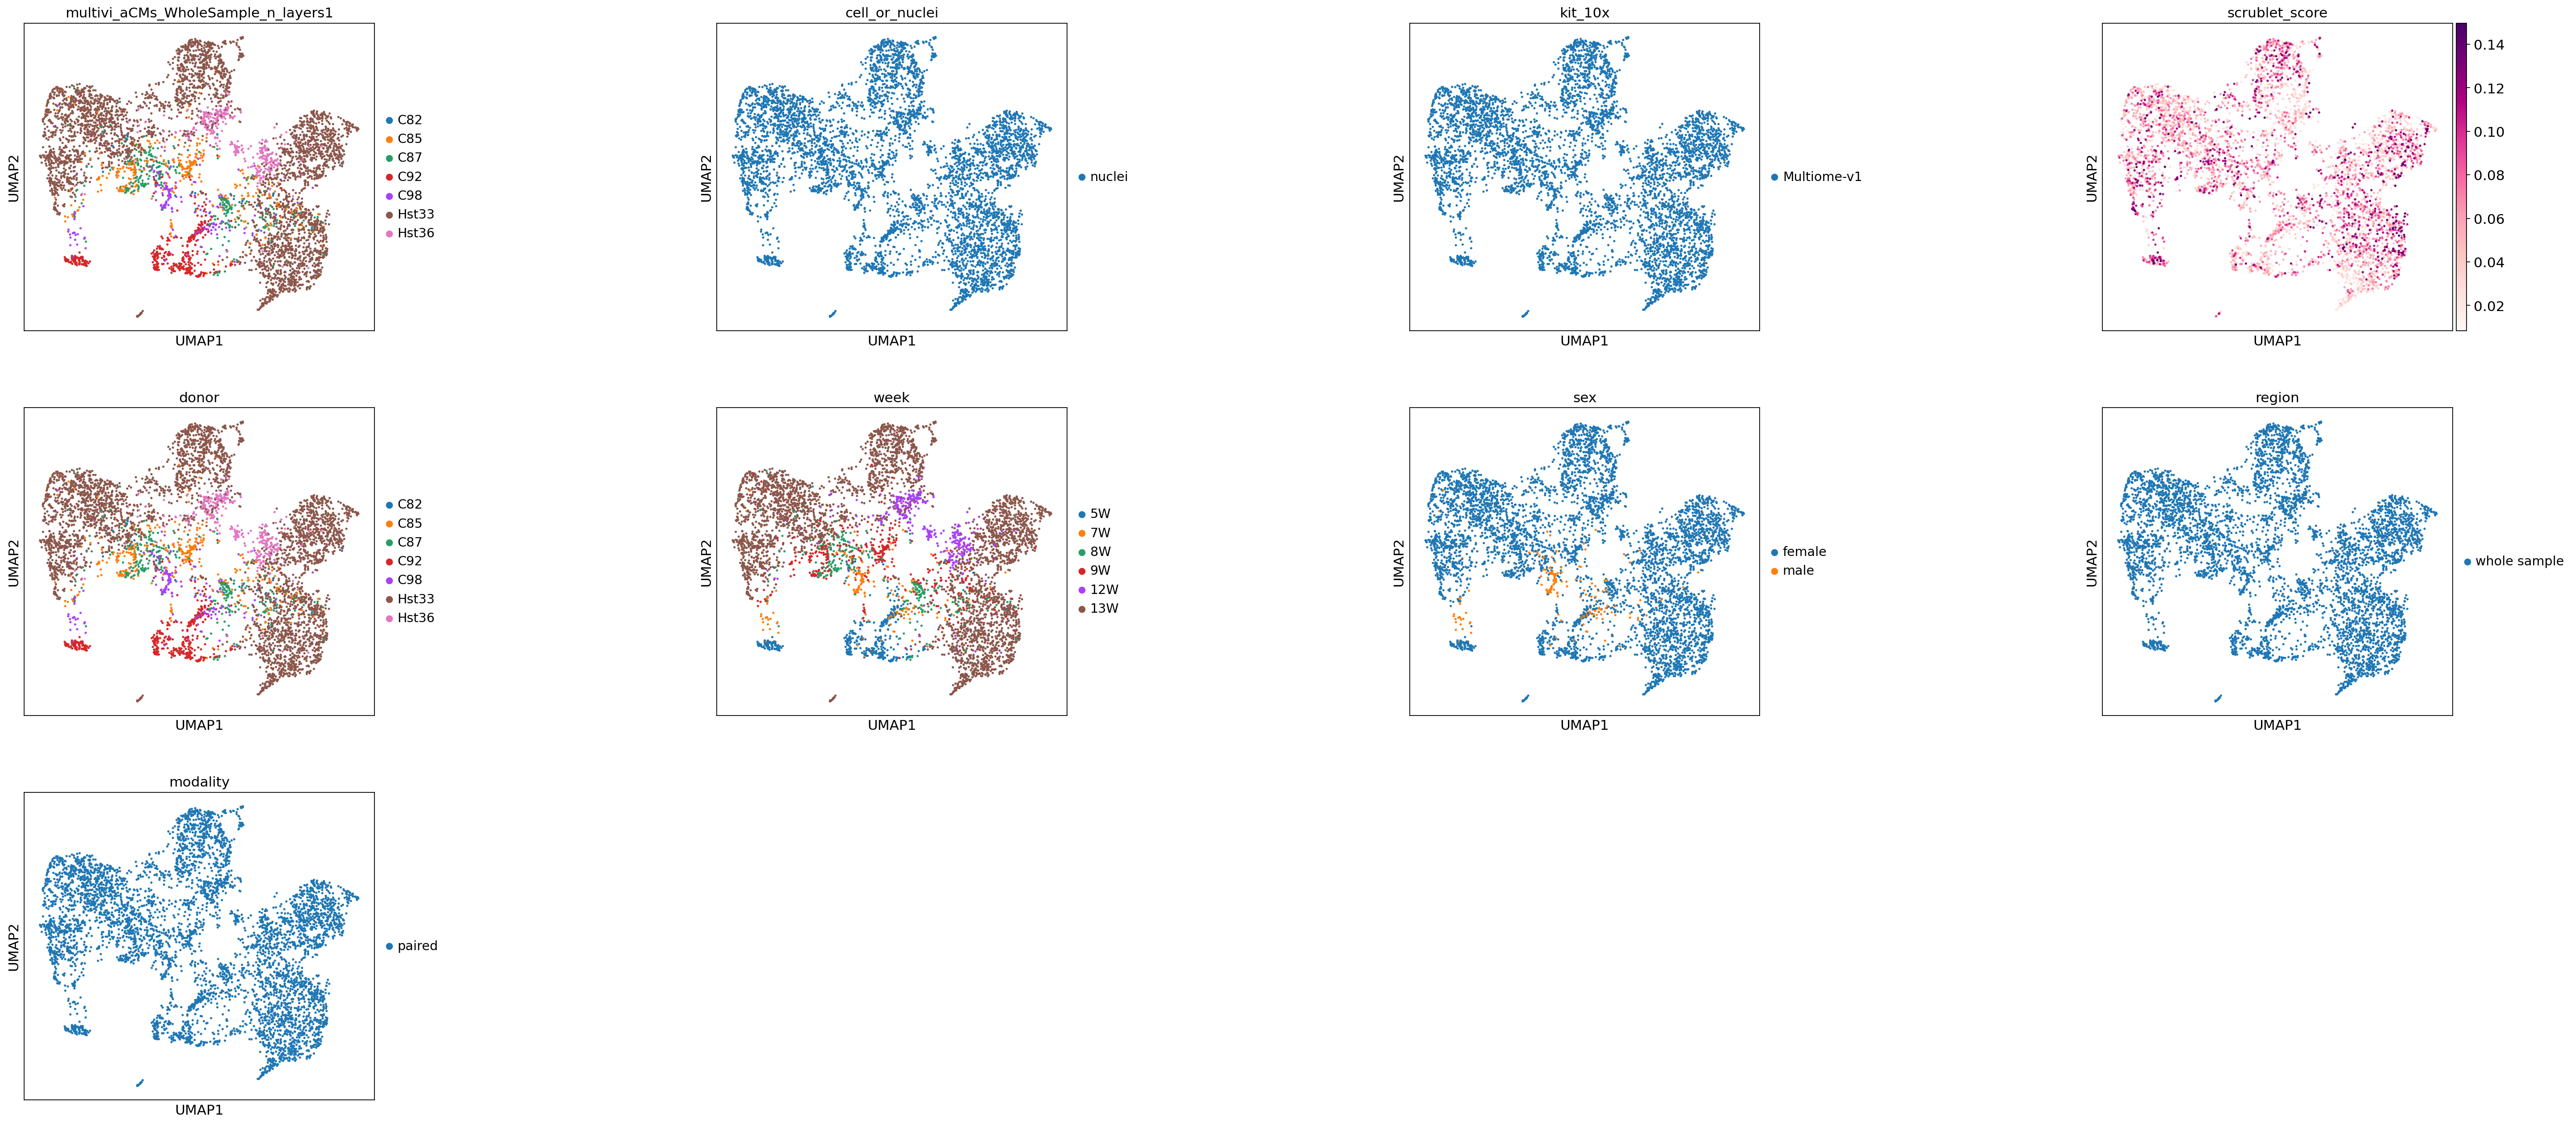

In [31]:
if developing==False:
    sc.pl.umap(adata_mvi,title=combination, color=['donor','cell_or_nuclei','kit_10x','scrublet_score','donor', 'week', 'sex', 'region','modality'],
           wspace=0.8,
           ncols=4,
           save=f"_{combination}.png")
else:
    sc.pl.umap(adata_mvi,title=combination, color=['donor','cell_or_nuclei','kit_10x','scrublet_score','donor', 'week', 'sex', 'region','modality'],
           wspace=0.8,
           ncols=4)